In [ ]:
#import and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import tensorflow as tf
from skimage.io import imread
import tifffile
from tensorflow.keras.utils import Sequence
from PIL import Image

In [ ]:
BASE_PATH = "/content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data"
IMAGES_PATH = os.path.join(BASE_PATH, "MG1655/All_images")
MASKS_PATH = os.path.join(BASE_PATH, "MG1655/All_segmentations")
annotations_path = os.path.join(BASE_PATH, "MG1655/coco_annotations.json")

##Data preparation


In [ ]:
def extract_metadata_from_filename(filename):

    # Split the filename (remove extension first)
    base = os.path.splitext(os.path.basename(filename))[0]
    parts = base.split("_")

    # Map fields based on filename structure
    metadata = {
        "title" : filename,
        "Date": parts[0] if len(parts) > 0 else None,
        "ExperimentID": parts[1] if len(parts) > 1 else None,
        "SpeciesID": parts[2] if len(parts) > 2 else None,
        "TreatmentConcentration": parts[3] if len(parts) > 3 else None,
        "ProjectCode": parts[4] if len(parts) > 4 else None,
        "ProcessingStage": parts[5] if len(parts) > 5 else None,
        "AcquisitionSeries": parts[6] if len(parts) > 6 else None,
        "TreatmentCondition": parts[7] if len(parts) > 7 else None,
        "PositionID": parts[8] if len(parts) > 8 else None,
    }
    return metadata

In [ ]:
def dataset_to_dataframe(base_dir):
    """Convert dataset directory into a structured DataFrame."""
    data = []

    for isolate in tqdm(os.listdir(base_dir), desc="Processing top-level folders"):
        isolate_path = os.path.join(base_dir, isolate)
        if not os.path.isdir(isolate_path):
            continue

        if isolate == "Clinical_Isolates_Titrations":
            # Special handling for Clinical_ISolates_Titrations
            for file in os.listdir(isolate_path):
                if file.endswith('.tif'):
                    file_path = os.path.join(isolate_path, file)
                    metadata = extract_metadata_from_filename(file)
                    data.append({
                        "isolate_type": isolate,
                        "image_path": file_path,
                        "mask_path": None,  # No masks for titrations
                        **metadata
                    })

        else:
            # Standard handling for MG1655 and Clinical_Isolates
            for treatment in os.listdir(os.path.join(isolate_path, "All_images")):
                img_dir = os.path.join(isolate_path, "All_images", treatment)
                mask_dir = os.path.join(isolate_path, "All_segmentations", treatment)

                if not os.path.exists(img_dir):
                    print(f"Warning: Missing image directory: {img_dir}")
                    continue

                for img_file in os.listdir(img_dir):
                    if img_file.endswith('.tif'):
                        img_path = os.path.join(img_dir, img_file)
                        mask_path = os.path.join(mask_dir, img_file) if os.path.exists(mask_dir) else None
                        metadata = extract_metadata_from_filename(img_file)
                        data.append({
                            "isolate_type": isolate,
                            "image_path": img_path,
                            "mask_path": mask_path,
                            **metadata
                        })

    return pd.DataFrame(data)


In [ ]:
data = dataset_to_dataframe(BASE_PATH)

Processing top-level folders: 100%|██████████| 3/3 [00:12<00:00,  4.26s/it]


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5196 entries, 0 to 5195
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   isolate_type            5196 non-null   object
 1   image_path              5196 non-null   object
 2   mask_path               1568 non-null   object
 3   title                   5196 non-null   object
 4   Date                    5196 non-null   object
 5   ExperimentID            5196 non-null   object
 6   SpeciesID               5196 non-null   object
 7   TreatmentConcentration  5196 non-null   object
 8   ProjectCode             5196 non-null   object
 9   ProcessingStage         5196 non-null   object
 10  AcquisitionSeries       5196 non-null   object
 11  TreatmentCondition      5196 non-null   object
 12  PositionID              5196 non-null   object
dtypes: object(13)
memory usage: 527.8+ KB


In [ ]:
data_copy = data.copy()

In [ ]:
clinical_isolates_titrations = data_copy[data_copy['isolate_type'] == 'Clinical_Isolates_Titrations']

unique_treatments = clinical_isolates_titrations['TreatmentConcentration'].unique()
unique_treatments
converted_treatments = []
for treatment in unique_treatments:
    try:
        converted_treatments.append(int(treatment.strip('[]')))
    except ValueError:
        converted_treatments.append(None)
print(converted_treatments)

[2, 16, 1, 4, 8, 1, 0, 1, 1, 5]


In [ ]:
treatment_mapping = dict(zip(unique_treatments, converted_treatments))
data_copy['TreatmentConcentration'] = data_copy['TreatmentConcentration'].map(treatment_mapping)

data_copy.head()

isolate_type                                         image_path  \
0  Clinical_Isolates  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
1  Clinical_Isolates  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
2  Clinical_Isolates  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
3  Clinical_Isolates  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
4  Clinical_Isolates  /content/drive/MyDrive/bacteria_data/Zagajewsk...   

  mask_path                                              title    Date  \
0      None  211110_1_EC1_NA_AMR_combined_1_CIP+ETOH_posXY0...  211110   
1      None  211110_1_EC1_NA_AMR_combined_3_CIP+ETOH_posXY0...  211110   
2      None  211110_1_EC1_NA_AMR_combined_1_CIP+ETOH_posXY1...  211110   
3      None  211110_1_EC1_NA_AMR_combined_1_CIP+ETOH_posXY1...  211110   
4      None  211110_1_EC1_NA_AMR_combined_1_CIP+ETOH_posXY6...  211110   

  ExperimentID SpeciesID  TreatmentConcentration ProjectCode ProcessingStage  \
0            1       EC1                     NaN         AMR        combined   
1            1       EC1                     NaN         AMR        combined   
2            1       EC1                     NaN         AMR        combined   
3            1       EC1                     NaN         AMR        combined   
4            1       EC1                     NaN         AMR        combined   

  AcquisitionSeries TreatmentCondition PositionID  
0                 1           CIP+ETOH     posXY0  
1                 3           CIP+ETOH     posXY0  
2                 1           CIP+ETOH     posXY1  
3                 1           CIP+ETOH    posXY10  
4                 1           CIP+ETOH     posXY6

In [ ]:
data_copy.to_csv("dataset_metadata.csv", index=False)

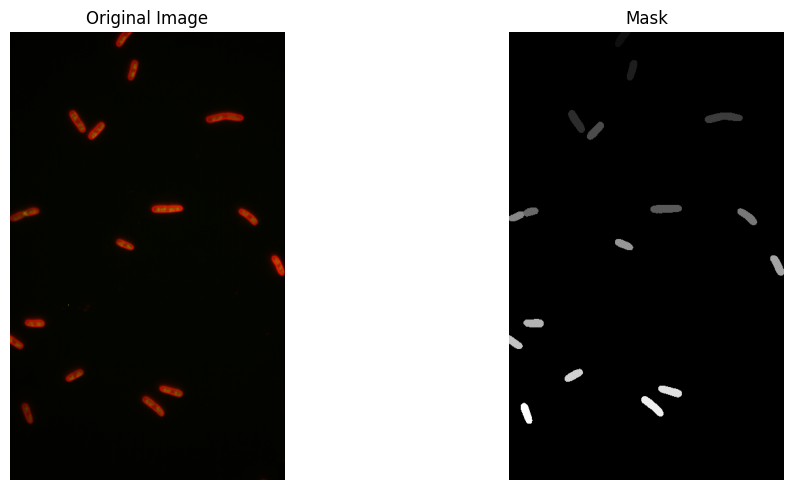

Mask unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
image unique values: [0.         0.00190738 0.00218204 ... 0.9807126  0.99818418 1.        ]
Image shape: (684, 420, 3)
Mask shape: (684, 420)
Image path: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY24.tif
Mask path: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_segmentations/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY24.tif


In [ ]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from PIL import Image

def show_image_and_mask(df):
    """
    Displays a random image and its corresponding mask from the dataframe.
    Specifically handled for 3-channel TIF images and mask files.
    """
    # Filter out rows where 'mask_path' is null
    df_with_masks = df.dropna(subset=['mask_path'])

    if df_with_masks.empty:
        print("No images with masks found in the DataFrame.")
        return

    # Select a random index from the filtered DataFrame
    random_index = random.randint(0, len(df_with_masks) - 1)
    random_row = df_with_masks.iloc[random_index]

    # Load the image using PIL (better handling of TIF files)
    image_path = random_row['image_path']
    try:

        image = tifffile.imread(image_path)
        image = np.transpose(image, (1, 2, 0))
        if image.max() > 1:
                    image = image / image.max()
        if len(image.shape) == 2:
                    image = np.stack([image] * 3, axis=-1)

    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # Load the mask using PIL
    mask_path = random_row['mask_path']
    try:
        mask = Image.open(mask_path)
        mask = np.array(mask)

        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
            mask = ((mask - mask.min()) * 255 / mask.max()).astype(np.uint8)
            mask = (mask > 0).astype(np.uint8)
            # print(f"Mask unique values after preprocessing: {np.unique(mask)}")

    except Exception as e:
        print(f"Error loading mask: {e}")
        return

    # Create figure
    plt.figure(figsize=(12, 5))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Display mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Mask unique values: {np.unique(mask)}")
    print(f"image unique values: {np.unique(image)}")
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    print("Image path:", image_path)
    print("Mask path:", mask_path)

# Call the function
show_image_and_mask(data_copy)

In [ ]:
def show_image_path(image_path):
  image = tifffile.imread(image_path)
  image = np.transpose(image, (1, 2, 0))
  if image.max() > 1:
    image = image / image.max()
  if len(image.shape) == 2:
    image = np.stack([image] * 3, axis=-1)
  plt.imshow(image)
  plt.title('Original Image')

In [ ]:
test_image_path = "/content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif"

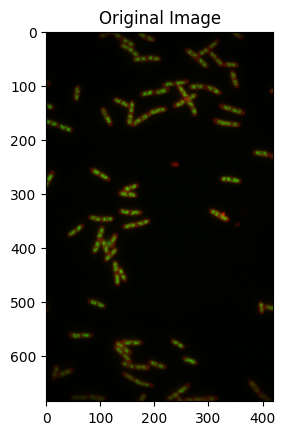

In [ ]:
show_image_path(test_image_path)

In [ ]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5196 entries, 0 to 5195
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isolate_type            5196 non-null   object 
 1   image_path              5196 non-null   object 
 2   mask_path               1568 non-null   object 
 3   title                   5196 non-null   object 
 4   Date                    5196 non-null   object 
 5   ExperimentID            5196 non-null   object 
 6   SpeciesID               5196 non-null   object 
 7   TreatmentConcentration  2392 non-null   float64
 8   ProjectCode             5196 non-null   object 
 9   ProcessingStage         5196 non-null   object 
 10  AcquisitionSeries       5196 non-null   object 
 11  TreatmentCondition      5196 non-null   object 
 12  PositionID              5196 non-null   object 
dtypes: float64(1), object(12)
memory usage: 527.8+ KB


In [ ]:
def load_and_preprocess_image(image_path, mask_path, image_size):
    """
    Load and preprocess a single image-mask pair.
    """
    # Ensure image_size is a flat numpy array
    image_size = np.array(image_size).flatten()
    target_size = (int(image_size[0]), int(image_size[1]))

    # Load and normalize image
    image = tifffile.imread(image_path.numpy().decode())
    if len(image.shape) == 2:  # Handle grayscale images
        image = np.stack([image] * 3, axis=-1)
    elif len(image.shape) == 3 and image.shape[0] < 10:  # Channel-first
        image = np.transpose(image, (1, 2, 0))
    image = image / image.max()  # Normalize to [0, 1]
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

    # Load and normalize mask
    mask = np.array(Image.open(mask_path.numpy().decode()))
    if len(mask.shape) == 3:
        mask = mask[:, :, 0]
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    mask = (mask > 0).astype(np.float32)  # Ensure binary or multi-class as floats
    mask = np.expand_dims(mask, axis=-1)

    return image.astype(np.float32), mask

def create_tensorflow_datasets(df, batch_size=32, image_size=(256, 256), val_split=0.2):
    """
    Create TensorFlow datasets for training and validation.
    """
    # Filter rows with valid masks
    masked_df = df.dropna(subset=['mask_path']).reset_index(drop=True)
    train_df, val_df = train_test_split(masked_df, test_size=val_split, random_state=42)

    # Convert image_size to tensor
    image_size_tensor = tf.constant(image_size, dtype=tf.int32)

    # Create preprocessing function that works with TensorFlow
    def _load_and_preprocess_wrapper(image_path, mask_path):
        image, mask = tf.py_function(
            func=load_and_preprocess_image,
            inp=[image_path, mask_path, image_size_tensor],
            Tout=[tf.float32, tf.float32]
        )
        # Set specific shapes for the outputs
        image.set_shape([image_size[0], image_size[1], 3])
        mask.set_shape([image_size[0], image_size[1], 1])
        return image, mask

    # Create training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((
        train_df['image_path'].values,
        train_df['mask_path'].values
    ))
    train_dataset = train_dataset.map(
        _load_and_preprocess_wrapper,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

    # Create validation dataset
    val_dataset = tf.data.Dataset.from_tensor_slices((
        val_df['image_path'].values,
        val_df['mask_path'].values
    ))
    val_dataset = val_dataset.map(
        _load_and_preprocess_wrapper,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_dataset = val_dataset.batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset

In [ ]:
def show_resized_image(image):
  if image.max() > 1:
    image = image / image.max()
  if len(image.shape) == 2:
    image = np.stack([image] * 3, axis=-1)
  plt.imshow(image)
  plt.title('Resized image')

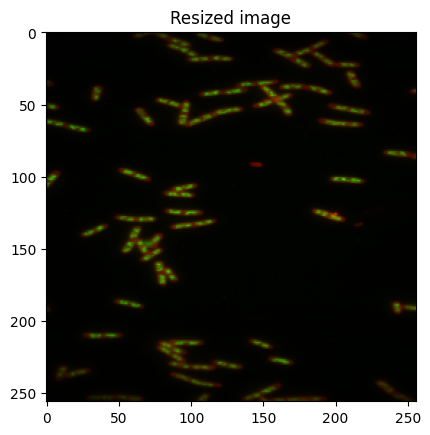

In [ ]:
re_image, re_mask = load_and_preprocess_image(tf.convert_to_tensor(test_image_path), tf.convert_to_tensor("/content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_segmentations/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY24.tif"), (256, 256))
show_resized_image(re_image)

In [ ]:
batch_size = 32
image_size = (256, 256)

segment_train_dataset, segment_val_dataset = create_tensorflow_datasets(
    data_copy,
    batch_size=batch_size,
    image_size=image_size
)
# Print dataset information
print("\nDataset Specs:")
print(f"Training dataset: {segment_train_dataset.element_spec}")
print(f"Validation dataset: {segment_val_dataset.element_spec}")


Dataset Specs:
Training dataset: (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))
Validation dataset: (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))


In [ ]:
for batch in segment_train_dataset.take(1):
    images, masks = batch
    print(images.shape, masks.shape)


(32, 256, 256, 3) (32, 256, 256, 1)


In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import tifffile
from sklearn.model_selection import train_test_split
import cv2

def load_and_preprocess_image_with_condition(image_path, mask_path, condition, image_size):
    """
    Load and preprocess a single image-mask pair, including treatment condition mapped to integers.
    """
    # Define label mapping globally or as a function constant
    label_mapping = {"WT+ETOH": 0, "CIP+ETOH": 1, "COAMOX+ETOH": 2, "GENT+ETOH": 3, "RIF+ETOH": 4}

    # Convert image_size tensor to tuple of ints
    target_size = (int(image_size[0]), int(image_size[1]))

    # Load and normalize image
    image = tifffile.imread(image_path.numpy().decode())
    if len(image.shape) == 2:  # Handle grayscale images
        image = np.stack([image] * 3, axis=-1)
    elif len(image.shape) == 3 and image.shape[0] < 10:  # Channel-first
        image = np.transpose(image, (1, 2, 0))
    image = image / image.max()  # Normalize to [0, 1]
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

    # Load and normalize mask
    mask = np.array(Image.open(mask_path.numpy().decode()))
    if len(mask.shape) == 3:
        mask = mask[:, :, 0]
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    mask = (mask > 0).astype(np.float32)  # Ensure binary or multi-class as floats
    mask = np.expand_dims(mask, axis=-1)

    # Decode and map treatment condition to integer label
    condition = condition.numpy().decode()
    label = label_mapping.get(condition, -1)  # Default to -1 if not found

    return image.astype(np.float32), mask, label

def create_tensorflow_datasets_with_labels(df, batch_size=32, image_size=(256, 256), val_split=0.2):
    """
    Create TensorFlow datasets fo and validation, mapping treatment conditions to labels.

    Args:
        df (DataFrame): DataFrame containing 'image_path', 'mask_path', and 'TreatmentCondition'.
        batch_size (int): Batch size fo.
        image_size (tuple): Target size for images and masks.
        val_split (float): Validation split ratio.

    Returns:
        train_dataset (tf.data.Dataset) dataset with images, masks, and treatment condition labels.
        val_dataset (tf.data.Dataset): Validation dataset with images, masks, and treatment condition labels.
    """
    # Filter rows with valid masks
    masked_df = df.dropna(subset=['mask_path']).reset_index(drop=True)
    train_df, val_df = train_test_split(masked_df, test_size=val_split, random_state=42)

    print(f"Number o samples: {len(train_df)}")
    print(f"Number of validation samples: {len(val_df)}")

    # Create preprocessing function that works with TensorFlow
    def _load_and_preprocess_wrapper(image_path, mask_path, condition):
        image, mask, label = tf.py_function(
            func=load_and_preprocess_image_with_condition,
            inp=[image_path, mask_path, condition, image_size],
            Tout=[tf.float32, tf.float32, tf.int32]
        )
        # Set specific shapes for the outputs
        image.set_shape([256, 256, 3])
        mask.set_shape([256, 256, 1])
        label.set_shape([])  # Scalar for the label
        return image, mask, label

    # Create training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((
        train_df['image_path'].values,
        train_df['mask_path'].values,
        train_df['TreatmentCondition'].values
    ))
    train_dataset = train_dataset.map(
        _load_and_preprocess_wrapper,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

    # Create validation dataset
    val_dataset = tf.data.Dataset.from_tensor_slices((
        val_df['image_path'].values,
        val_df['mask_path'].values,
        val_df['TreatmentCondition'].values
    ))
    val_dataset = val_dataset.map(
        _load_and_preprocess_wrapper,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_dataset = val_dataset.batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset

# Usage example
batch_size = 32
image_size = (256, 256)

train_dataset, val_dataset = create_tensorflow_datasets_with_labels(
    data_copy,
    batch_size=batch_size,
    image_size=image_size
)


Number o samples: 1254
Number of validation samples: 314


In [ ]:

# Test dataset
for image, mask, label in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    print("Label example:", label.numpy()[:5])  # Display first 5 labels

Image shape: (32, 256, 256, 3)
Mask shape: (32, 256, 256, 1)
Label example: [4 0 4 0 2]


image shape  (256, 256, 3)
mask shape  (256, 256, 1)


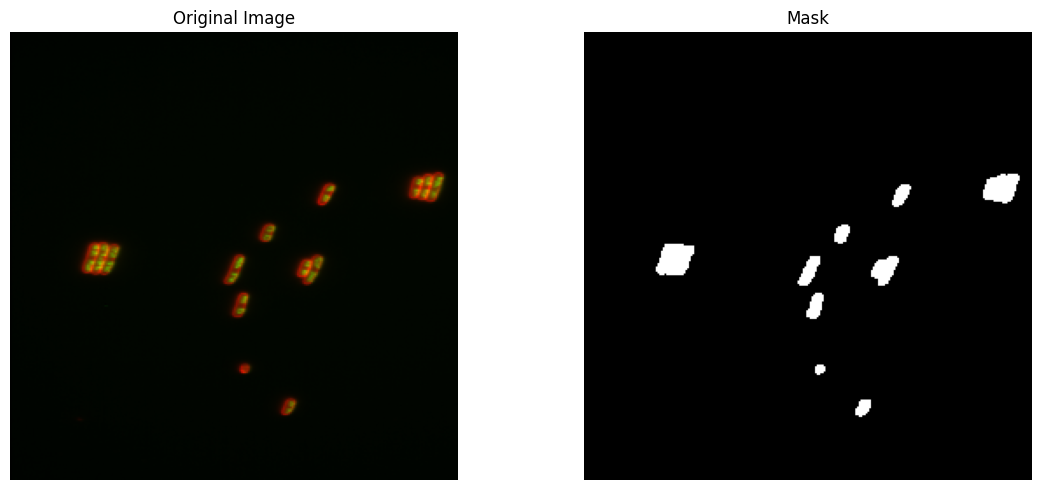

In [ ]:
import matplotlib.pyplot as plt

def visualize_random_sample(dataset):
    # Get a single batch
    for images, masks, labels in dataset.take(1):
        # Select a random index from the batch
        idx = np.random.randint(0, images.shape[0])

        # Get the image and mask
        image = images[idx].numpy()
        mask = masks[idx].numpy()
        print("image shape ",image.shape)
        print("mask shape ",mask.shape)
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Plot original image
        ax1.imshow(image)
        ax1.set_title('Original Image')
        ax1.axis('off')

        # Plot mask
        ax2.imshow(mask[:, :, 0], cmap='gray')
        ax2.set_title('Mask')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

# Visualize a random sample
visualize_random_sample(train_dataset)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D,
    Dropout, concatenate, Lambda
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_unet_model(input_shape=(256, 256, 3), output_channels=1):
    """
    Build U-Net model for image segmentation.
    """
    # Input layer
    inputs = Input(input_shape)

    # Normalization layer
    s = Lambda(lambda x: x / 255.0)(inputs)

    # Encoder (Contracting Path)
    # Block 1
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bridge
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder (Expanding Path)
    # Block 6
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    # Block 7
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    # Block 8
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    # Block 9
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = Conv2D(output_channels, (1, 1), activation='sigmoid')(c9)

    # Create and compile model
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# Create the model
model = build_unet_model(input_shape=(256, 256, 3), output_channels=1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Set up callbacks
filepath = "/content/drive/MyDrive/segment_model.keras"
callbacks_list = [
    EarlyStopping(patience=7, verbose=1),
    ModelCheckpoint(
        filepath,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )
]

# Train the model with your TensorFlow datasets
segment_model_history = model.fit(
    segment_train_dataset,
    validation_data=segment_val_dataset,
    batch_size=32,
    epochs=40,
    verbose = 1,
    callbacks=callbacks_list
)



Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9818 - loss: 0.0450 - precision: 0.8329 - recall: 0.8524
Epoch 1: val_loss improved from inf to 0.03809, saving model to /content/drive/MyDrive/segment_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 685ms/step - accuracy: 0.9818 - loss: 0.0450 - precision: 0.8330 - recall: 0.8525 - val_accuracy: 0.9858 - val_loss: 0.0381 - val_precision: 0.8409 - val_recall: 0.9139
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9841 - loss: 0.0397 - precision: 0.8541 - recall: 0.8722
Epoch 2: val_loss improved from 0.03809 to 0.03198, saving model to /content/drive/MyDrive/segment_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 79s 643ms/step - accuracy: 0.9841 - loss: 0.0397 - precision: 0.8541 - recall: 0.8724 - val_accuracy: 0.9872 - val_loss: 0.0320 - val_precision: 0.8698 - val_recall: 0.9031
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9852 - loss: 0.0371 - precision: 0.8627 - recall: 0.8816
Epoch 3: val_

In [ ]:
import json

# Convert the history object to a dictionary
history_dict = segment_model_history.history

# Define the file path
history_file = "/content/drive/MyDrive/segment_training_history.json"

# Save to JSON
with open(history_file, "w") as f:
    json.dump(history_dict, f)


NameError: name 'segment_model_history' is not defined

In [ ]:
# Extract values
loss = history_dict.get("loss", [])
val_loss = history_dict.get("val_loss", [])
accuracy = history_dict.get("accuracy", [])
val_accuracy = history_dict.get("val_accuracy", [])

epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.savefig("/content/drive/MyDrive/training_validation_loss.png")
plt.show()

# Plot Accuracy (if available)
if accuracy and val_accuracy:
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.savefig("/content/drive/MyDrive/training_validation_accuracy.png")
    plt.show()

NameError: name 'history_dict' is not defined

In [ ]:
for images, labels in train_dataset.take(1):
    print("Train Dataset:")
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

for images, labels in val_dataset.take(1):
    print("\nValidation Dataset:")
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


In [ ]:
model_path =  "/content/drive/MyDrive/segment_model.keras"

In [ ]:
def predict_resized_mask(image):
  model.load_weights(model_path)
  predicted_mask = model.predict(tf.expand_dims(image, axis=0))
  predicted_mask = predicted_mask[0, :, :, 0]  # Remove batch and channel dimensions

    # Plot original image, true mask, and predicted mask
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(predicted_mask, cmap='gray')
  plt.title('Predicted Mask')
  plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


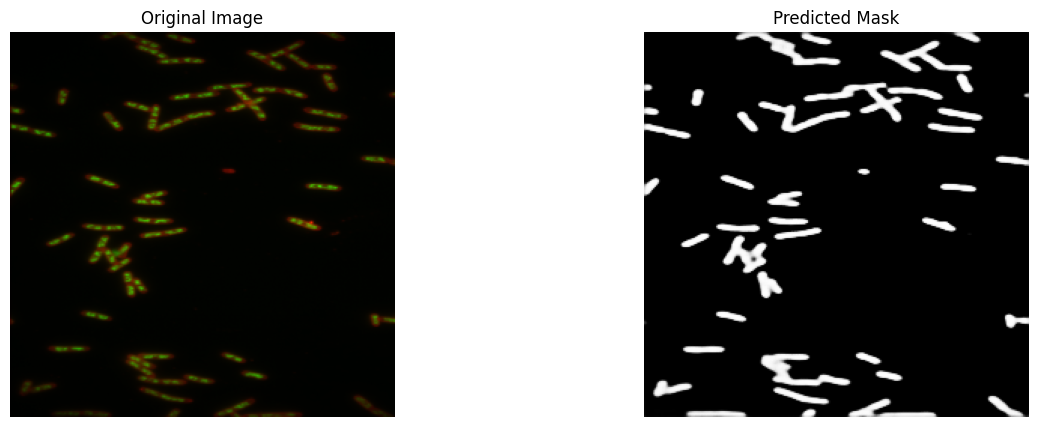

In [ ]:
predict_resized_mask(re_image)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


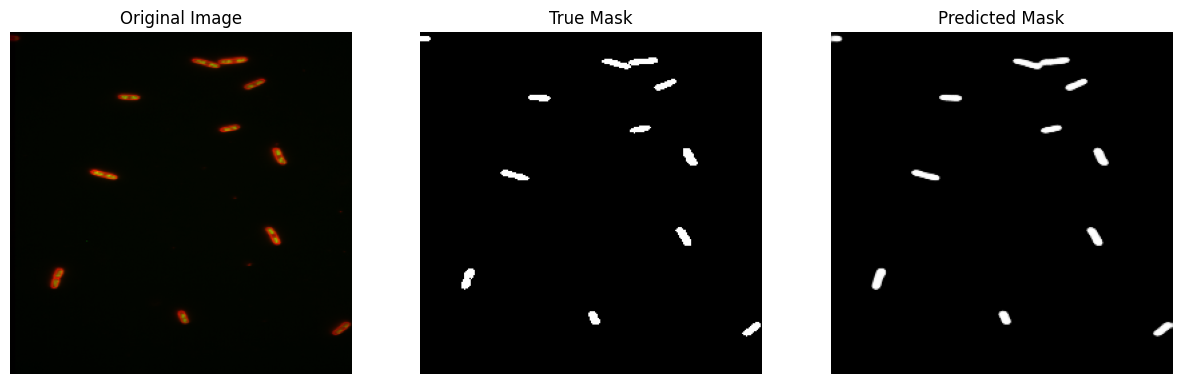

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


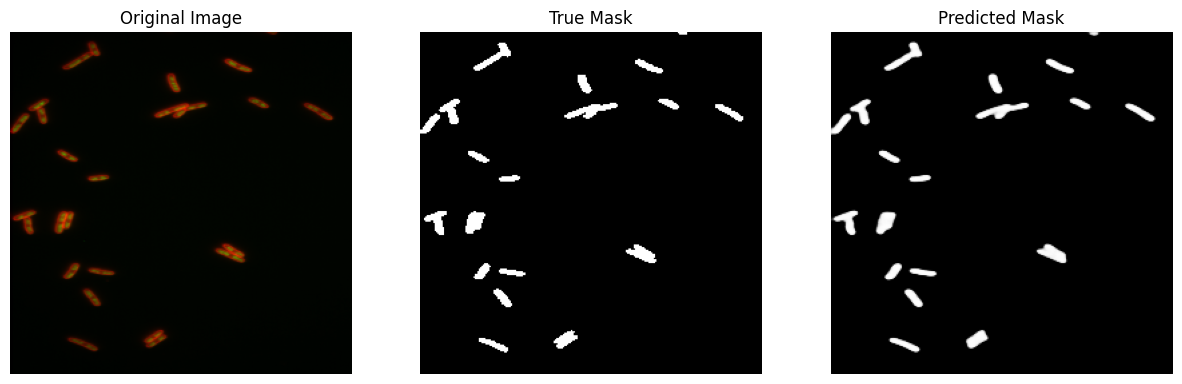

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


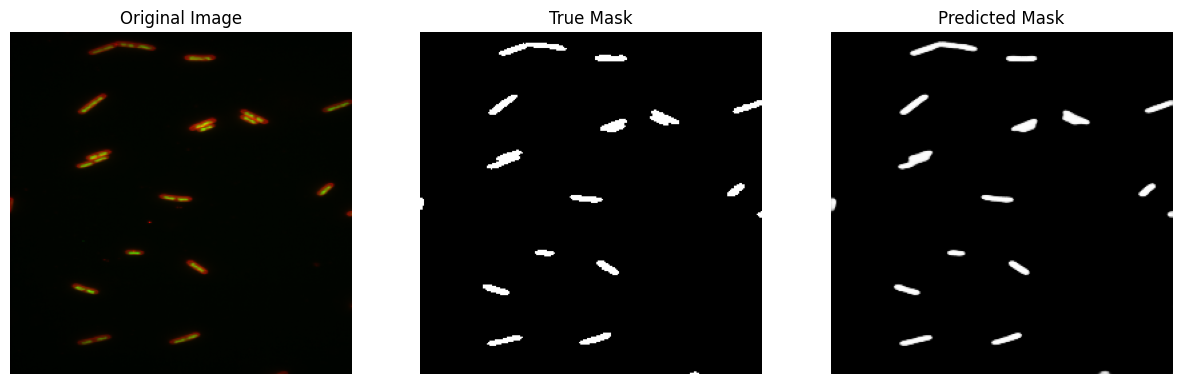

In [ ]:
# prompt: load model weights from model path and preditct mask for 3 random images in val_dataset  and plot images of image original mask and predicted mask
from PIL import Image
import random
import matplotlib.pyplot as plt

# Load the model weights
model.load_weights(model_path)

# Select 3 random images from the validation dataset
random_indices = random.sample(range(len(segment_val_dataset)), 3)

for i in random_indices:
    # Get the image and label from the val_dataset
    image, mask = list(segment_val_dataset.unbatch().take(i+1))[-1]

    # Predict the mask using the loaded model
    predicted_mask = model.predict(tf.expand_dims(image, axis=0))
    predicted_mask = predicted_mask[0, :, :, 0]  # Remove batch and channel dimensions

    # Plot original image, true mask, and predicted mask
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask[:, :, 0], cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tifffile
import cv2

# Load your dataframe (this example assumes it's already loaded as `clinical_isolates_titrations`)
# clinical_isolates_titrations = pd.read_csv('your_file.csv')  # Example loading

# Specify the target size for resizing
target_size = (256, 256)  # Replace with your desired dimensions

# Initialize a list to store processed images
test_dataset = []

# Process the first 10 images
for image_path in clinical_isolates_titrations['image_path'][:10]:
    # Load and normalize image
    image = tifffile.imread(image_path)

    if len(image.shape) == 2:  # Handle grayscale images
        image = np.stack([image] * 3, axis=-1)
    elif len(image.shape) == 3 and image.shape[0] < 10:  # Channel-first
        image = np.transpose(image, (1, 2, 0))

    image = image / image.max()  # Normalize to [0, 1]
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

    # Append the processed image to the test dataset
    test_dataset.append(image)

# Convert test dataset to a NumPy array
test_dataset = np.array(test_dataset)

# Output the shape of the test dataset for verification
print("Test dataset shape:", test_dataset.shape)


Test dataset shape: (10, 256, 256, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[0.0000000e+00 1.8842858e-11 2.1693803e-11 ... 9.9926567e-01 9.9997050e-01
 1.0000000e+00]
[0.0000000e+00 6.7562791e-12 1.1508005e-11 ... 9.9960405e-01 9.9962568e-01
 1.0000000e+00]
[0.0000000e+00 2.8978859e-11 3.4289717e-11 ... 9.9915981e-01 9.9978369e-01
 1.0000000e+00]
[0.0000000e+00 4.8496791e-13 8.4815445e-12 ... 9.9956018e-01 9.9958158e-01
 1.0000000e+00]
[0.0000000e+00 5.1263833e-12 5.9836836e-12 ... 9.9948305e-01 9.9951857e-01
 1.0000000e+00]
[0.0000000e+00 7.1764504e-12 1.3242201e-11 ... 9.9964911e-01 9.9979895e-01
 1.0000000e+00]
[0.0000000e+00 1.0928937e-11 1.4050212e-11 ... 9.9963206e-01 9.9963856e-01
 1.0000000e+00]
[0.0000000e+00 1.9865812e-11 4.4179650e-11 ... 9.9867344e-01 9.9869269e-01
 1.0000000e+00]
[0.0000000e+00 4.9780527e-12 5.2549462e-12 ... 9.9983233e-01 9.9983281e-01
 1.0000000e+00]
[0.0000000e+00 7.3520513e-12 1.3160107e-11 ... 9.9978620e-01 9.9992573e-01
 1.0000000e+00]


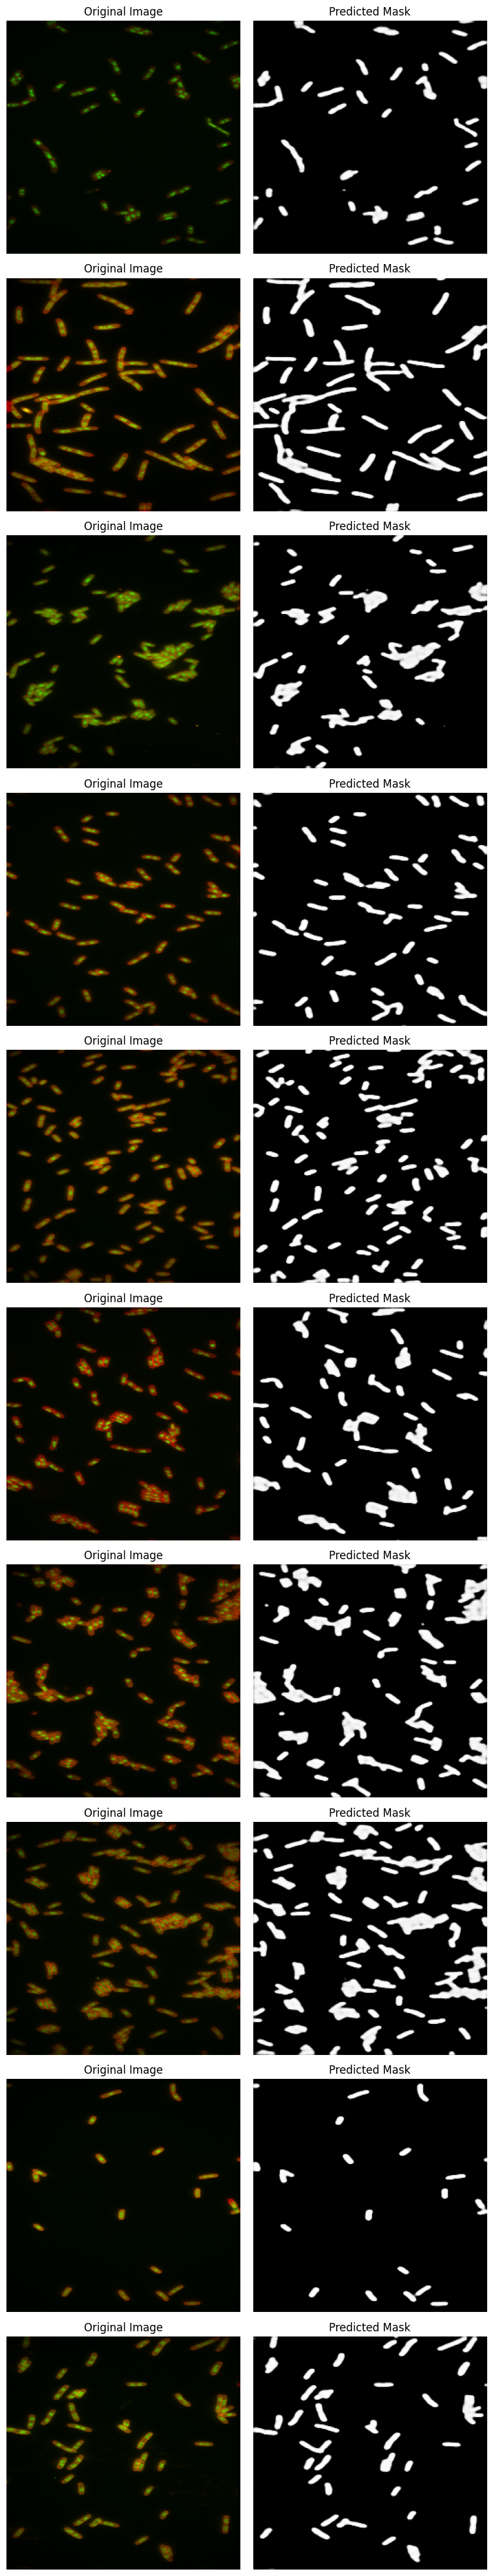

In [ ]:
import matplotlib.pyplot as plt

# Predict masks for images in the test_dataset
predicted_masks = model.predict(test_dataset)

# Plot the images and their corresponding predicted masks
num_images = len(test_dataset)  # Number of images in the test dataset
fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 4))

for i in range(num_images):
    # Original image
    image = test_dataset[i]

    # Predicted mask (assuming it has shape [height, width, channels])
    mask = predicted_masks[i]

    # If the mask has multiple channels, reduce to a single channel (e.g., via argmax or averaging)
    if mask.shape[-1] > 1:
        mask = np.argmax(mask, axis=-1)  # For segmentation with multiple classes

    # Normalize mask to [0, 1] for visualization
    mask = (mask - mask.min()) / (mask.max() - mask.min())

    # Plot the original image
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    # Plot the predicted mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title("Predicted Mask")
    axes[i, 1].axis("off")
    print(np.unique(mask))

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)


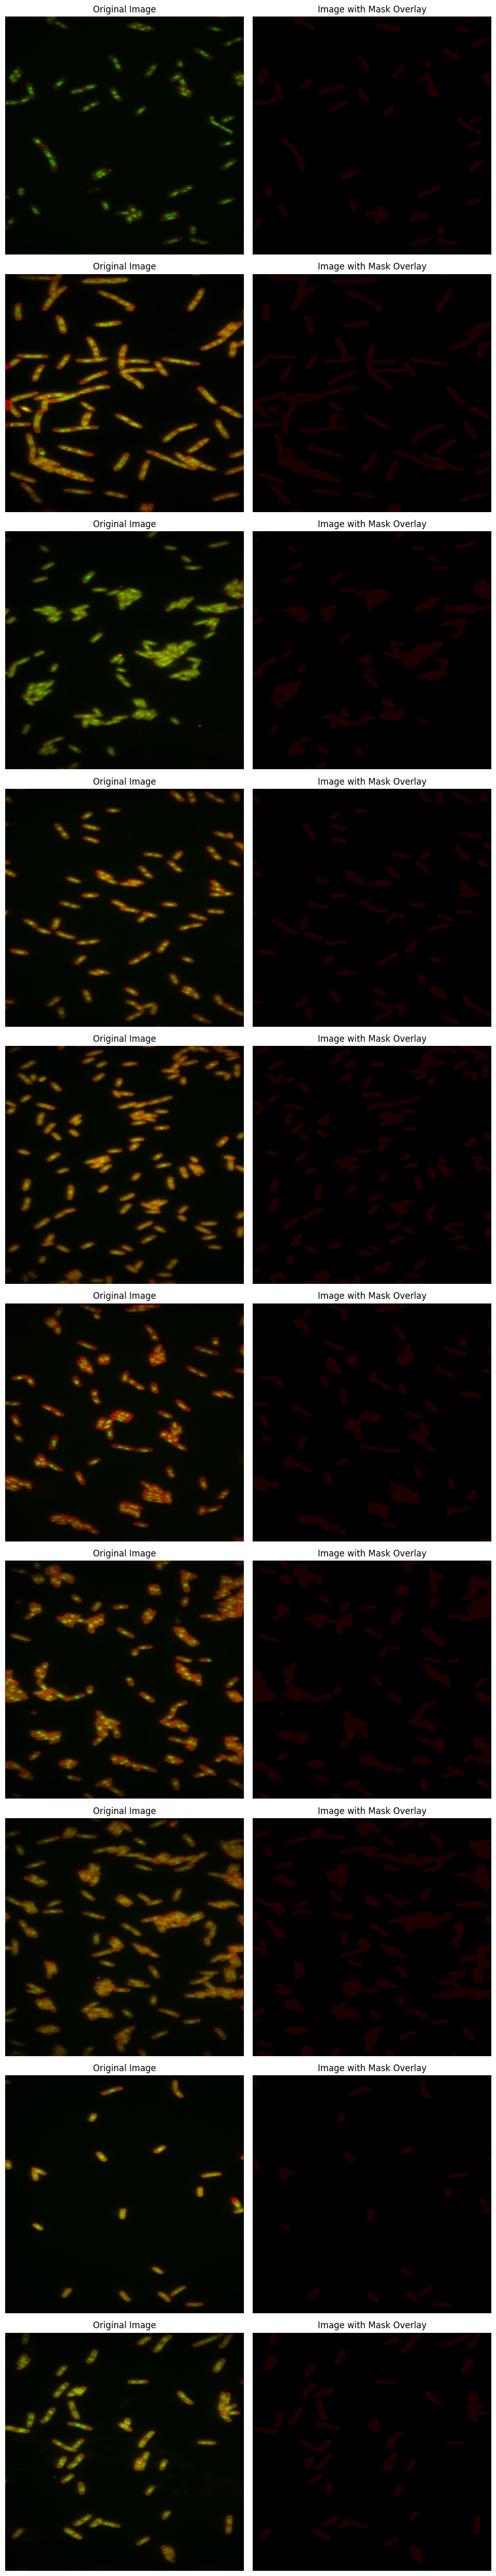

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict masks for images in the test_dataset
predicted_masks = model.predict(test_dataset)

opacity = 0.125

# Plot the images and their corresponding predicted masks
num_images = len(test_dataset)  # Number of images in the test dataset
fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

for i in range(num_images):
    # Original image
    image = test_dataset[i]

    # Predicted mask
    mask = predicted_masks[i]

    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")

    # If the mask has multiple channels, reduce to a single channel
    if mask.shape[-1] > 1:
        mask = np.argmax(mask, axis=-1)  # For multi-class masks

    # Ensure mask is 2D by squeezing extra dimensions
    mask = np.squeeze(mask)

    # Normalize the mask to [0, 1] for consistent overlay
    mask = (mask - mask.min()) / (mask.max() - mask.min())

    # Reshape mask to match image dimensions
    mask = mask[..., np.newaxis]  # Add channel dimension

    # Overlay the mask on the original image
    overlay = image.copy()
    overlay[..., 0] = np.clip(image[..., 0] * (1 - opacity) + (image[..., 0] + mask[..., 0] * 255) * opacity,0,255)
    overlay[..., 1] = image[..., 1]  # Keep green channel as-is
    overlay[..., 2] = image[..., 2]  # Keep blue channel as-is
    overlay = overlay.astype(np.uint8)

    # Plot the original image
    axes[i, 0].imshow(image)  # Normalize image for display
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    # Plot the overlaid mask
    axes[i, 1].imshow(overlay / 255.0)  # Normalize overlay for display
    axes[i, 1].set_title("Image with Mask Overlay")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/segment_model.keras"
unet_model = tf.keras.models.load_model(model_path, compile=False, safe_mode=False)
unet_model.load_weights(model_path)

In [ ]:
print("DataFrame shape:", data_copy.shape)
print(data_copy.head())

DataFrame shape: (5196, 13)
        isolate_type                                         image_path  \
0  Clinical_Isolates  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
1  Clinical_Isolates  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
2  Clinical_Isolates  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
3  Clinical_Isolates  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
4  Clinical_Isolates  /content/drive/MyDrive/bacteria_data/Zagajewsk...   

  mask_path                                              title    Date  \
0      None  211110_1_EC1_NA_AMR_combined_1_CIP+ETOH_posXY0...  211110   
1      None  211110_1_EC1_NA_AMR_combined_3_CIP+ETOH_posXY0...  211110   
2      None  211110_1_EC1_NA_AMR_combined_1_CIP+ETOH_posXY1...  211110   
3      None  211110_1_EC1_NA_AMR_combined_1_CIP+ETOH_posXY1...  211110   
4      None  211110_1_EC1_NA_AMR_combined_1_CIP+ETOH_posXY6...  211110   

  ExperimentID SpeciesID  TreatmentConcentration ProjectCode ProcessingStage

In [ ]:
# Select rows where the isolate_type is 'MG1655'
mg1655_data = data_copy[data_copy['isolate_type'] == 'MG1655']
# Display the selected data (optional)
mg1655_data


isolate_type                                         image_path  \
3628       MG1655  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
3629       MG1655  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
3630       MG1655  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
3631       MG1655  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
3632       MG1655  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
...           ...                                                ...   
5191       MG1655  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
5192       MG1655  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
5193       MG1655  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
5194       MG1655  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
5195       MG1655  /content/drive/MyDrive/bacteria_data/Zagajewsk...   

                                              mask_path  \
3628  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
3629  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
3630  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
3631  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
3632  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
...                                                 ...   
5191  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
5192  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
5193  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
5194  /content/drive/MyDrive/bacteria_data/Zagajewsk...   
5195  /content/drive/MyDrive/bacteria_data/Zagajewsk...   

                                                  title    Date ExperimentID  \
3628  200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_pos...  200818            1   
3629  200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_pos...  200818            1   
3630  200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_pos...  200818            1   
3631  200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_pos...  200818            1   
3632  200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_pos...  200818            1   
...                                                 ...     ...          ...   
5191  220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posX...  220920            1   
5192  220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posX...  220920            1   
5193  220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posX...  220920            1   
5194  220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posX...  220920            1   
5195  220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posX...  220920            1   

     SpeciesID  TreatmentConcentration ProjectCode ProcessingStage  \
3628    MG1655                     NaN         AMR        combined   
3629    MG1655                     NaN         AMR        combined   
3630    MG1655                     NaN         AMR        combined   
3631    MG1655                     NaN         AMR        combined   
3632    MG1655                     NaN         AMR        combined   
...        ...                     ...         ...             ...   
5191    MG1655                     NaN         AMR        combined   
5192    MG1655                     NaN         AMR        combined   
5193    MG1655                     NaN         AMR        combined   
5194    MG1655                     NaN         AMR        combined   
5195    MG1655                     NaN         AMR        combined   

     AcquisitionSeries TreatmentCondition PositionID  
3628                 1           CIP+ETOH     posXY1  
3629                 1           CIP+ETOH    posXY12  
3630                 1           CIP+ETOH     posXY3  
3631                 1           CIP+ETOH    posXY19  
3632                 1           CIP+ETOH     posXY2  
...                ...                ...        ...  
5191                 2            WT+ETOH     posXY9  
5192                 2            WT+ETOH     posXY5  
5193                 2            WT+ETOH     posXY8  
5194                 2            WT+ETOH     posXY6  
5195                 2  

In [ ]:
import numpy as np
import pandas as pd
import cv2
import tifffile
from skimage.measure import label, regionprops
from tqdm import tqdm
import tensorflow as tf

def predict_mask(image_path, model, target_size=(256,256)):
    # Load the image from image_path, ensure it is a 3-channel image,
    # resize it to target_size, normalize, expand dimensions, and then predict.
    image = tifffile.imread(image_path)
    if len(image.shape) == 2:  # Handle grayscale images
        image = np.stack([image] * 3, axis=-1)
    elif len(image.shape) == 3 and image.shape[0] < 10:  # Handle channel-first images
        image = np.transpose(image, (1, 2, 0))

    image = image / image.max()  # Normalize to [0, 1]
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

    # Predict the mask using the loaded model
    predicted_mask = model.predict(tf.expand_dims(image, axis=0))
    predicted_mask = predicted_mask[0, :, :, 0]

    # Apply thresholding to obtain a binary mask.
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)
    return binary_mask

In [ ]:
def extract_morph_features_and_prepare_classification_dataset(df, unet_model, target_size=(256,256), use_predicted_masks=True):
    """
    For each image in the DataFrame, this function:
      1. Loads the image and either predicts the segmentation mask using the U-Net model or loads a provided mask.
      2. Converts the original image to grayscale (for intensity-based feature extraction).
      3. Uses skimage.measure.regionprops to extract morphological features from each segmented cell.
      4. Combines the extracted features with the metadata from the filename.
      5. Assigns a resistance label based on TreatmentCondition.
    """
    all_features = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        image_path = row['image_path']
        print(f"Processing: {image_path}")
        try:
            if use_predicted_masks:
                mask = predict_mask(image_path, unet_model, target_size)
            else:
                if pd.notnull(row.get('mask_path')):
                    mask = tifffile.imread(row['mask_path'])
                    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
                    mask = (mask > 0).astype(np.uint8)
                else:
                    continue
        except Exception as e:
            print(f"Error processing mask for {image_path}: {e}")
            continue

        # Debug: print summary stats for the mask
        print("Mask sum:", np.sum(mask))

        # Load and process the image for intensity measurements
        try:
            image = tifffile.imread(image_path)
            if image.ndim == 3:
                image_gray = np.mean(image, axis=2)
            else:
                image_gray = image
            image_gray = cv2.resize(image_gray, target_size, interpolation=cv2.INTER_LINEAR)
        except Exception as e:
            print(f"Error processing image for {image_path}: {e}")
            continue

        labeled_mask = label(mask)
        regions = regionprops(labeled_mask, intensity_image=image_gray)
        print("Regions found:", len(regions))

        # Extract morphological features for each segmented region.
        for region in regions:
            feat = {
                "area": region.area,
                "perimeter": region.perimeter,
                "eccentricity": region.eccentricity,
                "solidity": region.solidity,
                "aspect_ratio": region.major_axis_length / (region.minor_axis_length + 1e-5),
                "mean_intensity": region.mean_intensity,
                "std_intensity": np.std(region.intensity_image)
            }

            # Add metadata from the filename
            feat["image_path"] = image_path
            feat["Date"] = row.get("Date")
            feat["ExperimentID"] = row.get("ExperimentID")
            feat["SpeciesID"] = row.get("SpeciesID")
            feat["TreatmentConcentration"] = row.get("TreatmentConcentration")
            feat["ProjectCode"] = row.get("ProjectCode")
            feat["ProcessingStage"] = row.get("ProcessingStage")
            feat["AcquisitionSeries"] = row.get("AcquisitionSeries")
            feat["TreatmentCondition"] = row.get("TreatmentCondition")
            feat["PositionID"] = row.get("PositionID")

            # Assign a label based on TreatmentCondition:
            # 0 for "WT+ETOH" (untreated) → susceptible, 1 for antibiotic-treated conditions.
            treatment = row.get("TreatmentCondition")
            feat["label"] = 0 if treatment == "WT+ETOH" else 1

            all_features.append(feat)

    df_features = pd.DataFrame(all_features)
    return df_features

df_classification = extract_morph_features_and_prepare_classification_dataset(
    mg1655_data,
    unet_model,
    target_size=(256, 256),
    use_predicted_masks=True
)

# Display a sample of the prepared dataset:
print(df_classification.head())

# Optionally, save to CSV for later use:
df_classification.to_csv("/content/drive/MyDrive/classification_dataframe.csv", index=False)


Extracting features:   0%|          | 0/1568 [00:00<?, ?it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Mask sum: 4497
Regions found: 42


Extracting features:   0%|          | 1/1568 [00:00<06:17,  4.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Extracting features:   0%|          | 2/1568 [00:00<05:28,  4.76it/s]

Mask sum: 5367
Regions found: 43
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Mask sum: 5587
Regions found: 39


Extracting features:   0%|          | 3/1568 [00:00<04:43,  5.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting features:   0%|          | 4/1568 [00:00<04:05,  6.37it/s]

Mask sum: 1668
Regions found: 23
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting features:   0%|          | 5/1568 [00:00<04:05,  6.36it/s]

Mask sum: 5903
Regions found: 46
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Mask sum: 2841
Regions found: 32


Extracting features:   0%|          | 6/1568 [00:01<04:01,  6.46it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Mask sum: 5270
Regions found: 42


Extracting features:   0%|          | 7/1568 [00:01<03:55,  6.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Mask sum: 4106


Extracting features:   1%|          | 8/1568 [00:01<04:10,  6.24it/s]

Regions found: 37
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   1%|          | 9/1568 [00:01<05:59,  4.33it/s]

Mask sum: 1463
Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 18615
Regions found: 62


Extracting features:   1%|          | 10/1568 [00:01<05:35,  4.65it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 6788
Regions found: 53


Extracting features:   1%|          | 11/1568 [00:02<05:12,  4.99it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1426
Regions found: 22


Extracting features:   1%|          | 12/1568 [00:02<04:41,  5.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 7897
Regions found: 47


Extracting features:   1%|          | 13/1568 [00:02<04:40,  5.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 14/1568 [00:02<04:47,  5.40it/s]

Mask sum: 4508
Regions found: 44
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 5219
Regions found: 40


Extracting features:   1%|          | 15/1568 [00:02<04:47,  5.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 820
Regions found: 9


Extracting features:   1%|          | 16/1568 [00:02<04:13,  6.12it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 5689
Regions found: 43


Extracting features:   1%|          | 17/1568 [00:03<04:27,  5.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 997
Regions found: 11


Extracting features:   1%|          | 18/1568 [00:03<04:03,  6.36it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 9919
Regions found: 42


Extracting features:   1%|          | 19/1568 [00:03<04:20,  5.95it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 1949
Regions found: 23


Extracting features:   1%|▏         | 20/1568 [00:03<04:17,  6.02it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 6468
Regions found: 37


Extracting features:   1%|▏         | 21/1568 [00:03<04:25,  5.83it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 5459
Regions found: 31


Extracting features:   1%|▏         | 22/1568 [00:03<04:28,  5.75it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 2832
Regions found: 28


Extracting features:   1%|▏         | 23/1568 [00:04<04:21,  5.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   2%|▏         | 24/1568 [00:04<04:12,  6.11it/s]

Mask sum: 869
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   2%|▏         | 25/1568 [00:04<03:54,  6.59it/s]

Mask sum: 699
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 26/1568 [00:04<03:47,  6.78it/s]

Mask sum: 1102
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   2%|▏         | 27/1568 [00:04<03:42,  6.94it/s]

Mask sum: 303
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   2%|▏         | 28/1568 [00:04<03:43,  6.89it/s]

Mask sum: 319
Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 634
Regions found: 11


Extracting features:   2%|▏         | 29/1568 [00:04<03:50,  6.68it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 1436
Regions found: 13


Extracting features:   2%|▏         | 30/1568 [00:05<03:47,  6.77it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2005


Extracting features:   2%|▏         | 31/1568 [00:05<03:54,  6.55it/s]

Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 1883
Regions found: 20


Extracting features:   2%|▏         | 32/1568 [00:05<03:48,  6.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 3473
Regions found: 20


Extracting features:   2%|▏         | 33/1568 [00:05<03:55,  6.52it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 7396
Regions found: 46


Extracting features:   2%|▏         | 34/1568 [00:05<04:03,  6.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 570
Regions found: 7


Extracting features:   2%|▏         | 35/1568 [00:05<03:43,  6.85it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:   2%|▏         | 36/1568 [00:05<03:33,  7.19it/s]

Mask sum: 527
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 37/1568 [00:06<03:30,  7.28it/s]

Mask sum: 2155
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   2%|▏         | 38/1568 [00:06<03:28,  7.34it/s]

Mask sum: 2398
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 3480
Regions found: 26


Extracting features:   2%|▏         | 39/1568 [00:06<03:45,  6.79it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 3626


Extracting features:   3%|▎         | 40/1568 [00:06<04:05,  6.23it/s]

Regions found: 30
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   3%|▎         | 41/1568 [00:06<04:01,  6.32it/s]

Mask sum: 1922
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY23.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1651
Regions found: 13


Extracting features:   3%|▎         | 42/1568 [00:06<03:44,  6.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 43/1568 [00:06<03:31,  7.21it/s]

Mask sum: 433
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   3%|▎         | 44/1568 [00:07<03:40,  6.91it/s]

Mask sum: 1928
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY22.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Mask sum: 2275
Regions found: 18


Extracting features:   3%|▎         | 45/1568 [00:07<04:05,  6.20it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Mask sum: 1760
Regions found: 15


Extracting features:   3%|▎         | 46/1568 [00:07<05:15,  4.83it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   3%|▎         | 47/1568 [00:08<06:34,  3.86it/s]

Mask sum: 1839
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   3%|▎         | 48/1568 [00:08<07:21,  3.44it/s]

Mask sum: 1486
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:   3%|▎         | 49/1568 [00:08<07:32,  3.35it/s]

Mask sum: 1059
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting features:   3%|▎         | 50/1568 [00:09<08:20,  3.03it/s]

Mask sum: 1075
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:   3%|▎         | 51/1568 [00:09<07:28,  3.38it/s]

Mask sum: 2340
Regions found: 20
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Mask sum: 3214
Regions found: 25


Extracting features:   3%|▎         | 52/1568 [00:09<08:11,  3.08it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   3%|▎         | 53/1568 [00:10<08:31,  2.96it/s]

Mask sum: 4633
Regions found: 26
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   3%|▎         | 54/1568 [00:10<08:27,  2.99it/s]

Mask sum: 2086
Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   4%|▎         | 55/1568 [00:10<08:39,  2.91it/s]

Mask sum: 1399
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY21.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Mask sum: 2218
Regions found: 21


Extracting features:   4%|▎         | 56/1568 [00:11<09:24,  2.68it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   4%|▎         | 57/1568 [00:11<09:19,  2.70it/s]

Mask sum: 2279
Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Mask sum: 2074
Regions found: 24


Extracting features:   4%|▎         | 58/1568 [00:12<09:55,  2.54it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Mask sum: 2086


Extracting features:   4%|▍         | 59/1568 [00:12<08:45,  2.87it/s]

Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Mask sum: 14821


Extracting features:   4%|▍         | 60/1568 [00:12<07:45,  3.24it/s]

Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:   4%|▍         | 61/1568 [00:12<06:30,  3.86it/s]

Mask sum: 952
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   4%|▍         | 62/1568 [00:12<05:21,  4.68it/s]

Mask sum: 508
Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   4%|▍         | 63/1568 [00:12<04:40,  5.36it/s]

Mask sum: 4517
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 6401
Regions found: 43


Extracting features:   4%|▍         | 64/1568 [00:13<04:41,  5.33it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1012
Regions found: 10


Extracting features:   4%|▍         | 65/1568 [00:13<04:11,  5.98it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   4%|▍         | 66/1568 [00:13<04:05,  6.11it/s]

Mask sum: 1581
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 1166
Regions found: 10


Extracting features:   4%|▍         | 67/1568 [00:13<04:12,  5.96it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 665
Regions found: 8


Extracting features:   4%|▍         | 68/1568 [00:13<04:03,  6.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1764
Regions found: 15


Extracting features:   4%|▍         | 69/1568 [00:13<04:03,  6.17it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2374
Regions found: 21


Extracting features:   4%|▍         | 70/1568 [00:13<03:49,  6.52it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   5%|▍         | 71/1568 [00:14<03:36,  6.91it/s]

Mask sum: 1587
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1673
Regions found: 21


Extracting features:   5%|▍         | 72/1568 [00:14<03:49,  6.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2064
Regions found: 15


Extracting features:   5%|▍         | 73/1568 [00:14<03:40,  6.79it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 4442
Regions found: 14


Extracting features:   5%|▍         | 74/1568 [00:14<04:00,  6.22it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 950


Extracting features:   5%|▍         | 75/1568 [00:14<03:58,  6.26it/s]

Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 4424
Regions found: 31


Extracting features:   5%|▍         | 76/1568 [00:14<03:52,  6.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2312
Regions found: 22


Extracting features:   5%|▍         | 77/1568 [00:15<03:56,  6.30it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 3351
Regions found: 30


Extracting features:   5%|▍         | 78/1568 [00:15<04:08,  5.99it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:   5%|▌         | 79/1568 [00:15<03:46,  6.57it/s]

Mask sum: 563
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Mask sum: 589
Regions found: 6


Extracting features:   5%|▌         | 80/1568 [00:15<03:51,  6.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 2675
Regions found: 38


Extracting features:   5%|▌         | 81/1568 [00:15<04:08,  5.97it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   5%|▌         | 82/1568 [00:15<03:45,  6.59it/s]

Mask sum: 754
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   5%|▌         | 83/1568 [00:15<03:30,  7.07it/s]

Mask sum: 554
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:   5%|▌         | 84/1568 [00:16<03:24,  7.27it/s]

Mask sum: 1821
Regions found: 20
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   5%|▌         | 85/1568 [00:16<03:18,  7.46it/s]

Mask sum: 933
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   5%|▌         | 86/1568 [00:16<03:17,  7.50it/s]

Mask sum: 1454
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 412
Regions found: 5


Extracting features:   6%|▌         | 87/1568 [00:16<03:35,  6.88it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 700


Extracting features:   6%|▌         | 88/1568 [00:16<03:40,  6.71it/s]

Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   6%|▌         | 89/1568 [00:16<03:31,  6.98it/s]

Mask sum: 1548
Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   6%|▌         | 90/1568 [00:16<03:18,  7.44it/s]

Mask sum: 979
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:   6%|▌         | 91/1568 [00:17<03:25,  7.20it/s]

Mask sum: 5282
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 674
Regions found: 6


Extracting features:   6%|▌         | 92/1568 [00:17<03:22,  7.30it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   6%|▌         | 93/1568 [00:17<03:20,  7.36it/s]

Mask sum: 723
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 94/1568 [00:17<03:28,  7.07it/s]

Mask sum: 664
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 590
Regions found: 10


Extracting features:   6%|▌         | 95/1568 [00:17<03:44,  6.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1362
Regions found: 17


Extracting features:   6%|▌         | 96/1568 [00:17<03:56,  6.22it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   6%|▌         | 97/1568 [00:17<03:40,  6.68it/s]

Mask sum: 511
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2096
Regions found: 27


Extracting features:   6%|▋         | 98/1568 [00:18<03:49,  6.40it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 525


Extracting features:   6%|▋         | 99/1568 [00:18<03:31,  6.93it/s]

Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/200818_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:   6%|▋         | 100/1568 [00:18<03:32,  6.90it/s]

Mask sum: 457
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 7657
Regions found: 83


Extracting features:   6%|▋         | 101/1568 [00:18<04:21,  5.60it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2041
Regions found: 27


Extracting features:   7%|▋         | 102/1568 [00:18<04:03,  6.03it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 4265
Regions found: 46


Extracting features:   7%|▋         | 103/1568 [00:18<03:57,  6.18it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1887
Regions found: 33


Extracting features:   7%|▋         | 104/1568 [00:19<03:53,  6.27it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1276


Extracting features:   7%|▋         | 105/1568 [00:19<04:00,  6.08it/s]

Regions found: 26
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:   7%|▋         | 106/1568 [00:19<03:55,  6.21it/s]

Mask sum: 724
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 6691
Regions found: 67


Extracting features:   7%|▋         | 107/1568 [00:19<04:14,  5.74it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   7%|▋         | 108/1568 [00:19<04:14,  5.74it/s]

Mask sum: 3326
Regions found: 36
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1475
Regions found: 21


Extracting features:   7%|▋         | 109/1568 [00:19<04:09,  5.84it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 3056
Regions found: 40


Extracting features:   7%|▋         | 110/1568 [00:20<04:17,  5.66it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1545
Regions found: 20


Extracting features:   7%|▋         | 111/1568 [00:20<04:11,  5.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 11433
Regions found: 90


Extracting features:   7%|▋         | 112/1568 [00:20<04:37,  5.24it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 113/1568 [00:20<04:29,  5.40it/s]

Mask sum: 1428
Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 5476
Regions found: 70


Extracting features:   7%|▋         | 114/1568 [00:20<04:42,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 6965
Regions found: 83


Extracting features:   7%|▋         | 115/1568 [00:21<04:47,  5.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 116/1568 [00:21<04:32,  5.32it/s]

Mask sum: 1063
Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 2698
Regions found: 29


Extracting features:   7%|▋         | 117/1568 [00:21<04:30,  5.36it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2399
Regions found: 36


Extracting features:   8%|▊         | 118/1568 [00:21<04:30,  5.36it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1392
Regions found: 18


Extracting features:   8%|▊         | 119/1568 [00:21<04:21,  5.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 6844
Regions found: 86


Extracting features:   8%|▊         | 120/1568 [00:22<04:43,  5.10it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2342


Extracting features:   8%|▊         | 121/1568 [00:22<04:19,  5.58it/s]

Regions found: 27
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 14094
Regions found: 94


Extracting features:   8%|▊         | 122/1568 [00:22<04:56,  4.87it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:   8%|▊         | 123/1568 [00:22<04:44,  5.08it/s]

Mask sum: 745
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Mask sum: 1656


Extracting features:   8%|▊         | 124/1568 [00:22<04:51,  4.95it/s]

Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:   8%|▊         | 125/1568 [00:23<04:59,  4.81it/s]

Mask sum: 2180
Regions found: 30
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:   8%|▊         | 126/1568 [00:23<05:14,  4.59it/s]

Mask sum: 5527
Regions found: 50
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting features:   8%|▊         | 127/1568 [00:23<05:11,  4.63it/s]

Mask sum: 854
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 759
Regions found: 12


Extracting features:   8%|▊         | 128/1568 [00:23<04:59,  4.81it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 5403
Regions found: 49


Extracting features:   8%|▊         | 129/1568 [00:23<05:05,  4.71it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 4765
Regions found: 52


Extracting features:   8%|▊         | 130/1568 [00:24<05:20,  4.49it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   8%|▊         | 131/1568 [00:24<04:59,  4.80it/s]

Mask sum: 792
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:   8%|▊         | 132/1568 [00:24<05:03,  4.74it/s]

Mask sum: 973
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 980


Extracting features:   8%|▊         | 133/1568 [00:24<04:56,  4.84it/s]

Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:   9%|▊         | 134/1568 [00:24<04:59,  4.80it/s]

Mask sum: 784
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 1041


Extracting features:   9%|▊         | 135/1568 [00:25<04:56,  4.84it/s]

Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 5056


Extracting features:   9%|▊         | 136/1568 [00:25<05:17,  4.51it/s]

Regions found: 47
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:   9%|▊         | 137/1568 [00:25<05:07,  4.65it/s]

Mask sum: 797
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210325_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 6442
Regions found: 62


Extracting features:   9%|▉         | 138/1568 [00:25<05:23,  4.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:   9%|▉         | 139/1568 [00:26<05:02,  4.73it/s]

Mask sum: 1051
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:   9%|▉         | 140/1568 [00:26<04:58,  4.78it/s]

Mask sum: 867
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:   9%|▉         | 141/1568 [00:26<05:02,  4.72it/s]

Mask sum: 1390
Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:   9%|▉         | 142/1568 [00:26<04:53,  4.85it/s]

Mask sum: 790
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 618
Regions found: 10


Extracting features:   9%|▉         | 143/1568 [00:26<04:31,  5.25it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 1856
Regions found: 30


Extracting features:   9%|▉         | 144/1568 [00:27<04:21,  5.45it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3377
Regions found: 46


Extracting features:   9%|▉         | 145/1568 [00:27<04:11,  5.66it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3879
Regions found: 54


Extracting features:   9%|▉         | 146/1568 [00:27<04:23,  5.40it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 4237
Regions found: 47


Extracting features:   9%|▉         | 147/1568 [00:27<04:35,  5.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2217
Regions found: 29


Extracting features:   9%|▉         | 148/1568 [00:27<04:13,  5.60it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 6335
Regions found: 72


Extracting features:  10%|▉         | 149/1568 [00:27<04:35,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 6147
Regions found: 75


Extracting features:  10%|▉         | 150/1568 [00:28<04:44,  4.98it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  10%|▉         | 151/1568 [00:28<04:23,  5.39it/s]

Mask sum: 529
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 954
Regions found: 12


Extracting features:  10%|▉         | 152/1568 [00:28<04:03,  5.82it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 555
Regions found: 10


Extracting features:  10%|▉         | 153/1568 [00:28<03:56,  6.00it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 678
Regions found: 9


Extracting features:  10%|▉         | 154/1568 [00:28<03:49,  6.17it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 795
Regions found: 11


Extracting features:  10%|▉         | 155/1568 [00:28<03:44,  6.28it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 766


Extracting features:  10%|▉         | 156/1568 [00:29<03:45,  6.27it/s]

Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 5014
Regions found: 64


Extracting features:  10%|█         | 157/1568 [00:29<04:07,  5.69it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  10%|█         | 158/1568 [00:29<04:01,  5.83it/s]

Mask sum: 885
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2491
Regions found: 38


Extracting features:  10%|█         | 159/1568 [00:29<04:12,  5.57it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 977

Extracting features:  10%|█         | 160/1568 [00:29<03:51,  6.08it/s]


Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 6236
Regions found: 88


Extracting features:  10%|█         | 161/1568 [00:30<04:10,  5.62it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  10%|█         | 162/1568 [00:30<03:59,  5.88it/s]

Mask sum: 829
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1106
Regions found: 14


Extracting features:  10%|█         | 163/1568 [00:30<03:42,  6.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  10%|█         | 164/1568 [00:30<03:31,  6.65it/s]

Mask sum: 774
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210401_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 4862
Regions found: 57


Extracting features:  11%|█         | 165/1568 [00:30<03:59,  5.87it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 374
Regions found: 7


Extracting features:  11%|█         | 166/1568 [00:30<03:48,  6.12it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 729
Regions found: 10


Extracting features:  11%|█         | 167/1568 [00:30<03:44,  6.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 636
Regions found: 9


Extracting features:  11%|█         | 168/1568 [00:31<03:41,  6.33it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 570
Regions found: 8


Extracting features:  11%|█         | 169/1568 [00:31<03:40,  6.33it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  11%|█         | 170/1568 [00:31<03:47,  6.14it/s]

Mask sum: 955
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  11%|█         | 171/1568 [00:31<03:50,  6.07it/s]

Mask sum: 1277
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1599


Extracting features:  11%|█         | 172/1568 [00:31<03:53,  5.98it/s]

Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1601
Regions found: 20


Extracting features:  11%|█         | 173/1568 [00:31<03:41,  6.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1612
Regions found: 27


Extracting features:  11%|█         | 174/1568 [00:32<03:50,  6.05it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 3017
Regions found: 37


Extracting features:  11%|█         | 175/1568 [00:32<03:45,  6.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1494
Regions found: 21


Extracting features:  11%|█         | 176/1568 [00:32<03:51,  6.02it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1556


Extracting features:  11%|█▏        | 177/1568 [00:32<03:45,  6.18it/s]

Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1347
Regions found: 23


Extracting features:  11%|█▏        | 178/1568 [00:32<03:50,  6.04it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 517
Regions found: 8


Extracting features:  11%|█▏        | 179/1568 [00:32<03:35,  6.45it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1227
Regions found: 19


Extracting features:  11%|█▏        | 180/1568 [00:33<03:38,  6.35it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1443
Regions found: 20


Extracting features:  12%|█▏        | 181/1568 [00:33<03:33,  6.50it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  12%|█▏        | 182/1568 [00:33<03:23,  6.81it/s]

Mask sum: 471
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1402
Regions found: 21


Extracting features:  12%|█▏        | 183/1568 [00:33<03:39,  6.30it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1674
Regions found: 22


Extracting features:  12%|█▏        | 184/1568 [00:33<03:33,  6.49it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  12%|█▏        | 185/1568 [00:33<03:34,  6.46it/s]

Mask sum: 921
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2269
Regions found: 28


Extracting features:  12%|█▏        | 186/1568 [00:33<03:28,  6.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  12%|█▏        | 187/1568 [00:34<03:17,  6.98it/s]

Mask sum: 1554
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  12%|█▏        | 188/1568 [00:34<03:19,  6.93it/s]

Mask sum: 1675
Regions found: 26
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1142
Regions found: 15


Extracting features:  12%|█▏        | 189/1568 [00:34<03:28,  6.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 1061
Regions found: 14


Extracting features:  12%|█▏        | 190/1568 [00:34<03:37,  6.33it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  12%|█▏        | 191/1568 [00:34<03:27,  6.62it/s]

Mask sum: 1578
Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  12%|█▏        | 192/1568 [00:34<03:19,  6.88it/s]

Mask sum: 1685
Regions found: 20
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2673
Regions found: 39


Extracting features:  12%|█▏        | 193/1568 [00:34<03:25,  6.68it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 4515
Regions found: 49


Extracting features:  12%|█▏        | 194/1568 [00:35<03:53,  5.87it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2208


Extracting features:  12%|█▏        | 195/1568 [00:35<03:55,  5.83it/s]

Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 2050


Extracting features:  12%|█▎        | 196/1568 [00:35<04:08,  5.52it/s]

Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3456
Regions found: 35


Extracting features:  13%|█▎        | 197/1568 [00:35<03:57,  5.76it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  13%|█▎        | 198/1568 [00:35<03:40,  6.21it/s]

Mask sum: 1087
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2241
Regions found: 31


Extracting features:  13%|█▎        | 199/1568 [00:36<03:34,  6.39it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1612
Regions found: 20


Extracting features:  13%|█▎        | 200/1568 [00:36<03:45,  6.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 3524
Regions found: 40


Extracting features:  13%|█▎        | 201/1568 [00:36<03:58,  5.74it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 3103
Regions found: 39


Extracting features:  13%|█▎        | 202/1568 [00:36<04:12,  5.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2370
Regions found: 32


Extracting features:  13%|█▎        | 203/1568 [00:36<04:12,  5.40it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  13%|█▎        | 204/1568 [00:36<04:15,  5.34it/s]

Mask sum: 961
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 1190
Regions found: 13


Extracting features:  13%|█▎        | 205/1568 [00:37<04:15,  5.33it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/210403_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 4155
Regions found: 47


Extracting features:  13%|█▎        | 206/1568 [00:37<04:54,  4.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  13%|█▎        | 207/1568 [00:37<04:40,  4.85it/s]

Mask sum: 1145
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 2847


Extracting features:  13%|█▎        | 208/1568 [00:37<04:44,  4.77it/s]

Regions found: 31
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  13%|█▎        | 209/1568 [00:38<04:40,  4.85it/s]

Mask sum: 921
Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 3271
Regions found: 38


Extracting features:  13%|█▎        | 210/1568 [00:38<04:41,  4.82it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 2645
Regions found: 34


Extracting features:  13%|█▎        | 211/1568 [00:38<04:50,  4.67it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 3698


Extracting features:  14%|█▎        | 212/1568 [00:38<04:44,  4.77it/s]

Regions found: 41
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1898


Extracting features:  14%|█▎        | 213/1568 [00:38<04:32,  4.97it/s]

Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 2367
Regions found: 26


Extracting features:  14%|█▎        | 214/1568 [00:39<04:22,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Mask sum: 3281
Regions found: 42


Extracting features:  14%|█▎        | 215/1568 [00:39<04:40,  4.83it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Mask sum: 3227
Regions found: 39


Extracting features:  14%|█▍        | 216/1568 [00:39<04:57,  4.54it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mask sum: 3411
Regions found: 32


Extracting features:  14%|█▍        | 217/1568 [00:39<05:01,  4.48it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 2708
Regions found: 37


Extracting features:  14%|█▍        | 218/1568 [00:39<05:05,  4.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Mask sum: 3373
Regions found: 33


Extracting features:  14%|█▍        | 219/1568 [00:40<05:07,  4.38it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Mask sum: 3762
Regions found: 38


Extracting features:  14%|█▍        | 220/1568 [00:40<05:13,  4.30it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 2636
Regions found: 28


Extracting features:  14%|█▍        | 221/1568 [00:40<05:08,  4.36it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Mask sum: 2045
Regions found: 24


Extracting features:  14%|█▍        | 222/1568 [00:40<05:03,  4.43it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 7256
Regions found: 71


Extracting features:  14%|█▍        | 223/1568 [00:41<04:50,  4.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  14%|█▍        | 224/1568 [00:41<04:26,  5.04it/s]

Mask sum: 1045
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211019_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 3246
Regions found: 33


Extracting features:  14%|█▍        | 225/1568 [00:41<04:27,  5.03it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 3263
Regions found: 32


Extracting features:  14%|█▍        | 226/1568 [00:41<04:08,  5.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3551
Regions found: 35


Extracting features:  14%|█▍        | 227/1568 [00:41<03:52,  5.76it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 5072
Regions found: 51


Extracting features:  15%|█▍        | 228/1568 [00:41<04:03,  5.50it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 6945
Regions found: 57


Extracting features:  15%|█▍        | 229/1568 [00:42<04:13,  5.28it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 8695
Regions found: 57


Extracting features:  15%|█▍        | 230/1568 [00:42<04:09,  5.37it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Mask sum: 6165
Regions found:

Extracting features:  15%|█▍        | 231/1568 [00:42<05:08,  4.33it/s]

 55
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 11331
Regions found: 73


Extracting features:  15%|█▍        | 232/1568 [00:43<05:54,  3.77it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 3462
Regions found: 40


Extracting features:  15%|█▍        | 233/1568 [00:43<05:45,  3.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 4305
Regions found: 45


Extracting features:  15%|█▍        | 234/1568 [00:43<05:13,  4.26it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 5682
Regions found: 52


Extracting features:  15%|█▍        | 235/1568 [00:43<05:03,  4.39it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 5093
Regions found: 42


Extracting features:  15%|█▌        | 236/1568 [00:43<04:34,  4.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2179
Regions found: 26


Extracting features:  15%|█▌        | 237/1568 [00:43<04:11,  5.30it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting features:  15%|█▌        | 238/1568 [00:44<05:14,  4.23it/s]

Mask sum: 6501
Regions found: 61
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  15%|█▌        | 239/1568 [00:44<05:19,  4.16it/s]

Mask sum: 5252
Regions found: 51
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  15%|█▌        | 240/1568 [00:44<05:15,  4.20it/s]

Mask sum: 2545
Regions found: 33
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  15%|█▌        | 241/1568 [00:45<05:24,  4.10it/s]

Mask sum: 6411
Regions found: 51
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  15%|█▌        | 242/1568 [00:45<05:28,  4.03it/s]

Mask sum: 5986
Regions found: 52
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Mask sum: 6543
Regions found: 51


Extracting features:  15%|█▌        | 243/1568 [00:45<06:14,  3.54it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 5722
Regions found: 55


Extracting features:  16%|█▌        | 244/1568 [00:45<06:05,  3.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 2863
Regions found: 33


Extracting features:  16%|█▌        | 245/1568 [00:46<05:48,  3.79it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 3447
Regions found: 43


Extracting features:  16%|█▌        | 246/1568 [00:46<05:04,  4.34it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 2745
Regions found: 33


Extracting features:  16%|█▌        | 247/1568 [00:46<04:57,  4.45it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 2691
Regions found: 33


Extracting features:  16%|█▌        | 248/1568 [00:46<04:37,  4.76it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 8434
Regions found: 65


Extracting features:  16%|█▌        | 249/1568 [00:46<04:27,  4.93it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  16%|█▌        | 250/1568 [00:47<04:12,  5.21it/s]

Mask sum: 3331
Regions found: 37
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 3687
Regions found: 41


Extracting features:  16%|█▌        | 251/1568 [00:47<04:17,  5.12it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 4771
Regions found: 54


Extracting features:  16%|█▌        | 252/1568 [00:47<04:23,  4.99it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 5059
Regions found: 47


Extracting features:  16%|█▌        | 253/1568 [00:47<04:33,  4.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 3823
Regions found: 38


Extracting features:  16%|█▌        | 254/1568 [00:47<04:15,  5.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/211025_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3210
Regions found:

Extracting features:  16%|█▋        | 255/1568 [00:48<04:11,  5.22it/s]

 35
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 8354
Regions found: 39


Extracting features:  16%|█▋        | 256/1568 [00:48<04:16,  5.12it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 8426


Extracting features:  16%|█▋        | 257/1568 [00:48<04:18,  5.08it/s]

Regions found: 41
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  16%|█▋        | 258/1568 [00:48<04:19,  5.04it/s]

Mask sum: 20036
Regions found: 33
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_1_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 9231


Extracting features:  17%|█▋        | 259/1568 [00:48<04:18,  5.06it/s]

Regions found: 43
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 9745
Regions found: 41


Extracting features:  17%|█▋        | 260/1568 [00:49<04:06,  5.30it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 11335
Regions found: 58


Extracting features:  17%|█▋        | 261/1568 [00:49<04:12,  5.17it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 5851


Extracting features:  17%|█▋        | 262/1568 [00:49<04:15,  5.12it/s]

Regions found: 45
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 10730
Regions found: 48


Extracting features:  17%|█▋        | 263/1568 [00:49<04:13,  5.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  17%|█▋        | 264/1568 [00:49<04:15,  5.10it/s]

Mask sum: 9130
Regions found: 43
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 6129
Regions found: 46


Extracting features:  17%|█▋        | 265/1568 [00:49<04:03,  5.35it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 13241
Regions found: 47


Extracting features:  17%|█▋        | 266/1568 [00:50<03:57,  5.48it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 9606
Regions found: 49


Extracting features:  17%|█▋        | 267/1568 [00:50<04:03,  5.34it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 7391
Regions found: 53


Extracting features:  17%|█▋        | 268/1568 [00:50<04:14,  5.10it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 14115
Regions found: 46


Extracting features:  17%|█▋        | 269/1568 [00:50<04:08,  5.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 5130
Regions found: 43


Extracting features:  17%|█▋        | 270/1568 [00:50<03:57,  5.47it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Mask sum: 20957
Regions found: 61


Extracting features:  17%|█▋        | 271/1568 [00:51<04:29,  4.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 16894
Regions found: 67


Extracting features:  17%|█▋        | 272/1568 [00:51<04:58,  4.34it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Mask sum: 12352
Regions found: 43


Extracting features:  17%|█▋        | 273/1568 [00:51<05:08,  4.20it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 21967
Regions found: 37


Extracting features:  17%|█▋        | 274/1568 [00:51<05:11,  4.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 7380
Regions found: 50


Extracting features:  18%|█▊        | 275/1568 [00:52<05:03,  4.26it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_3_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 6885
Regions found: 42


Extracting features:  18%|█▊        | 276/1568 [00:52<05:08,  4.19it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 11267
Regions found: 51


Extracting features:  18%|█▊        | 277/1568 [00:52<05:16,  4.08it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Mask sum: 8893
Regions found: 41


Extracting features:  18%|█▊        | 278/1568 [00:52<05:16,  4.07it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 7312
Regions found: 53


Extracting features:  18%|█▊        | 279/1568 [00:53<05:15,  4.08it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_4_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Mask sum: 5520
Regions found: 36


Extracting features:  18%|█▊        | 280/1568 [00:53<05:14,  4.09it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_5_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 21844
Regions found: 39


Extracting features:  18%|█▊        | 281/1568 [00:53<05:19,  4.03it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_2_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 15397
Regions found: 55


Extracting features:  18%|█▊        | 282/1568 [00:53<05:33,  3.85it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_6_CIP+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 33336
Regions found: 22


Extracting features:  18%|█▊        | 283/1568 [00:54<05:22,  3.98it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_6_CIP+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Mask sum: 24510
Regions found: 39


Extracting features:  18%|█▊        | 284/1568 [00:54<05:25,  3.94it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH/220223_1_MG1655_NA_AMR_combined_6_CIP+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Mask sum: 29072
Regions found: 31


Extracting features:  18%|█▊        | 285/1568 [00:54<05:30,  3.88it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 10982
Regions found: 69


Extracting features:  18%|█▊        | 286/1568 [00:55<05:46,  3.70it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 19712
Regions found: 68


Extracting features:  18%|█▊        | 287/1568 [00:55<05:37,  3.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  18%|█▊        | 288/1568 [00:55<05:11,  4.10it/s]

Mask sum: 9814
Regions found: 60
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  18%|█▊        | 289/1568 [00:55<05:00,  4.26it/s]

Mask sum: 20924
Regions found: 57
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 10074
Regions found: 52


Extracting features:  18%|█▊        | 290/1568 [00:55<04:42,  4.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  19%|█▊        | 291/1568 [00:56<04:29,  4.74it/s]

Mask sum: 12014
Regions found: 45
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 10931
Regions found: 66


Extracting features:  19%|█▊        | 292/1568 [00:56<04:24,  4.82it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  19%|█▊        | 293/1568 [00:56<04:13,  5.03it/s]

Mask sum: 4083
Regions found: 32
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 9241


Extracting features:  19%|█▉        | 294/1568 [00:56<04:21,  4.88it/s]

Regions found: 59
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 5849
Regions found: 48


Extracting features:  19%|█▉        | 295/1568 [00:56<04:07,  5.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 12833
Regions found: 54


Extracting features:  19%|█▉        | 296/1568 [00:57<04:07,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 9905


Extracting features:  19%|█▉        | 297/1568 [00:57<04:03,  5.22it/s]

Regions found: 60
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  19%|█▉        | 298/1568 [00:57<04:06,  5.14it/s]

Mask sum: 7190
Regions found: 47
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  19%|█▉        | 299/1568 [00:57<04:16,  4.95it/s]

Mask sum: 10020
Regions found: 46
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 16490


Extracting features:  19%|█▉        | 300/1568 [00:57<04:19,  4.89it/s]

Regions found: 53
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 4041


Extracting features:  19%|█▉        | 301/1568 [00:58<04:13,  4.99it/s]

Regions found: 34
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 8262
Regions found: 59


Extracting features:  19%|█▉        | 302/1568 [00:58<04:15,  4.96it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 8193
Regions found: 51


Extracting features:  19%|█▉        | 303/1568 [00:58<04:20,  4.85it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220926_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  19%|█▉        | 304/1568 [00:58<04:18,  4.89it/s]

Mask sum: 4498
Regions found: 40
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 3255
Regions found: 27


Extracting features:  19%|█▉        | 305/1568 [00:58<04:07,  5.11it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 3310
Regions found: 30


Extracting features:  20%|█▉        | 306/1568 [00:59<04:04,  5.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3974
Regions found: 34


Extracting features:  20%|█▉        | 307/1568 [00:59<04:05,  5.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 6080
Regions found: 43


Extracting features:  20%|█▉        | 308/1568 [00:59<03:57,  5.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  20%|█▉        | 309/1568 [00:59<03:58,  5.29it/s]

Mask sum: 2493
Regions found: 25
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 4917
Regions found: 37


Extracting features:  20%|█▉        | 310/1568 [00:59<03:48,  5.50it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3214
Regions found: 27


Extracting features:  20%|█▉        | 311/1568 [00:59<03:48,  5.50it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 3946
Regions found: 33


Extracting features:  20%|█▉        | 312/1568 [01:00<03:56,  5.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 4318
Regions found: 32


Extracting features:  20%|█▉        | 313/1568 [01:00<03:41,  5.68it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 3409
Regions found: 22


Extracting features:  20%|██        | 314/1568 [01:00<03:42,  5.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 6313
Regions found: 44


Extracting features:  20%|██        | 315/1568 [01:00<03:41,  5.66it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 3262
Regions found: 27


Extracting features:  20%|██        | 316/1568 [01:00<03:34,  5.83it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 3064
Regions found: 28


Extracting features:  20%|██        | 317/1568 [01:00<03:38,  5.73it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 6502
Regions found: 43


Extracting features:  20%|██        | 318/1568 [01:01<03:47,  5.50it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 12783
Regions found: 61


Extracting features:  20%|██        | 319/1568 [01:01<04:02,  5.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 14590
Regions found: 56


Extracting features:  20%|██        | 320/1568 [01:01<04:17,  4.84it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  20%|██        | 321/1568 [01:01<04:11,  4.97it/s]

Mask sum: 6331
Regions found: 49
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 12719
Regions found: 63


Extracting features:  21%|██        | 322/1568 [01:02<04:06,  5.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 13942
Regions found: 54


Extracting features:  21%|██        | 323/1568 [01:02<04:02,  5.13it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 13953


Extracting features:  21%|██        | 324/1568 [01:02<03:55,  5.28it/s]

Regions found: 49
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  21%|██        | 325/1568 [01:02<04:16,  4.85it/s]

Mask sum: 18054
Regions found: 63
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  21%|██        | 326/1568 [01:02<04:15,  4.87it/s]

Mask sum: 7572
Regions found: 47
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 13222


Extracting features:  21%|██        | 327/1568 [01:03<04:20,  4.77it/s]

Regions found: 68
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  21%|██        | 328/1568 [01:03<04:18,  4.80it/s]

Mask sum: 7307
Regions found: 48
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 13482
Regions found: 55


Extracting features:  21%|██        | 329/1568 [01:03<04:09,  4.97it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  21%|██        | 330/1568 [01:03<03:55,  5.26it/s]

Mask sum: 1709
Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 5278
Regions found: 44


Extracting features:  21%|██        | 331/1568 [01:03<03:58,  5.20it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 5219
Regions found: 44


Extracting features:  21%|██        | 332/1568 [01:03<03:57,  5.21it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 12860
Regions found: 50


Extracting features:  21%|██        | 333/1568 [01:04<04:00,  5.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220816_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  21%|██▏       | 334/1568 [01:04<04:02,  5.09it/s]

Mask sum: 5020
Regions found: 39
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  21%|██▏       | 335/1568 [01:04<04:02,  5.09it/s]

Mask sum: 3032
Regions found: 32
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3023
Regions found: 23


Extracting features:  21%|██▏       | 336/1568 [01:04<03:49,  5.36it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 3393
Regions found: 26


Extracting features:  21%|██▏       | 337/1568 [01:04<03:43,  5.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 3338
Regions found: 26


Extracting features:  22%|██▏       | 338/1568 [01:05<03:47,  5.40it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Mask sum: 3328
Regions found: 29


Extracting features:  22%|██▏       | 339/1568 [01:05<04:02,  5.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Mask sum: 3827
Regions found: 33


Extracting features:  22%|██▏       | 340/1568 [01:05<04:22,  4.67it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 4551
Regions found: 40


Extracting features:  22%|██▏       | 341/1568 [01:05<04:28,  4.56it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  22%|██▏       | 342/1568 [01:06<04:19,  4.72it/s]

Mask sum: 2373
Regions found: 20
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  22%|██▏       | 343/1568 [01:06<04:26,  4.60it/s]

Mask sum: 3107
Regions found: 32
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:  22%|██▏       | 344/1568 [01:06<04:31,  4.51it/s]

Mask sum: 2615
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  22%|██▏       | 345/1568 [01:06<04:30,  4.52it/s]

Mask sum: 2698
Regions found: 26
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220907_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  22%|██▏       | 346/1568 [01:06<04:35,  4.44it/s]

Mask sum: 5564
Regions found: 42
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  22%|██▏       | 347/1568 [01:07<04:25,  4.60it/s]

Mask sum: 1932
Regions found: 30
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 7720


Extracting features:  22%|██▏       | 348/1568 [01:07<04:35,  4.43it/s]

Regions found: 55
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  22%|██▏       | 349/1568 [01:07<04:41,  4.33it/s]

Mask sum: 4257
Regions found: 32
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  22%|██▏       | 350/1568 [01:07<04:57,  4.09it/s]

Mask sum: 10630
Regions found: 65
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  22%|██▏       | 351/1568 [01:08<04:55,  4.11it/s]

Mask sum: 3399
Regions found: 29
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:  22%|██▏       | 352/1568 [01:08<05:04,  3.99it/s]

Mask sum: 5388
Regions found: 43
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:  23%|██▎       | 353/1568 [01:08<05:01,  4.03it/s]

Mask sum: 4391
Regions found: 37
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:  23%|██▎       | 354/1568 [01:08<04:53,  4.14it/s]

Mask sum: 5438
Regions found: 39
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Mask sum: 4621
Regions found: 42


Extracting features:  23%|██▎       | 355/1568 [01:09<05:29,  3.69it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Mask sum: 4265
Regions found: 32


Extracting features:  23%|██▎       | 356/1568 [01:09<05:19,  3.79it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  23%|██▎       | 357/1568 [01:09<04:53,  4.13it/s]

Mask sum: 2819
Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 415


Extracting features:  23%|██▎       | 358/1568 [01:09<04:11,  4.82it/s]

Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 859
Regions found: 8


Extracting features:  23%|██▎       | 359/1568 [01:09<03:52,  5.20it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2885
Regions found: 26


Extracting features:  23%|██▎       | 360/1568 [01:10<03:34,  5.62it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 6431
Regions found: 42


Extracting features:  23%|██▎       | 361/1568 [01:10<03:31,  5.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 3195
Regions found: 29


Extracting features:  23%|██▎       | 362/1568 [01:10<03:25,  5.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 3044
Regions found: 26


Extracting features:  23%|██▎       | 363/1568 [01:10<03:37,  5.54it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 516


Extracting features:  23%|██▎       | 364/1568 [01:10<03:31,  5.69it/s]

Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 7071
Regions found: 47


Extracting features:  23%|██▎       | 365/1568 [01:10<03:39,  5.49it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 4044


Extracting features:  23%|██▎       | 366/1568 [01:11<03:39,  5.48it/s]

Regions found: 39
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220912_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3134
Regions found: 27


Extracting features:  23%|██▎       | 367/1568 [01:11<03:29,  5.74it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 2140
Regions found: 21


Extracting features:  23%|██▎       | 368/1568 [01:11<03:34,  5.61it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 729
Regions found: 8


Extracting features:  24%|██▎       | 369/1568 [01:11<03:18,  6.04it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1063
Regions found: 11


Extracting features:  24%|██▎       | 370/1568 [01:11<03:15,  6.11it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1449
Regions found: 18


Extracting features:  24%|██▎       | 371/1568 [01:11<03:08,  6.36it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  24%|██▎       | 372/1568 [01:12<03:00,  6.64it/s]

Mask sum: 770
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY21.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  24%|██▍       | 373/1568 [01:12<02:51,  6.98it/s]

Mask sum: 631
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  24%|██▍       | 374/1568 [01:12<02:55,  6.79it/s]

Mask sum: 609
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  24%|██▍       | 375/1568 [01:12<03:02,  6.52it/s]

Mask sum: 455
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 389


Extracting features:  24%|██▍       | 376/1568 [01:12<02:59,  6.65it/s]

Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  24%|██▍       | 377/1568 [01:12<02:59,  6.63it/s]

Mask sum: 747
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 652


Extracting features:  24%|██▍       | 378/1568 [01:12<03:02,  6.54it/s]

Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1301
Regions found: 14


Extracting features:  24%|██▍       | 379/1568 [01:13<03:05,  6.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  24%|██▍       | 380/1568 [01:13<03:08,  6.31it/s]

Mask sum: 1743
Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 903


Extracting features:  24%|██▍       | 381/1568 [01:13<03:10,  6.23it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum:

Extracting features:  24%|██▍       | 382/1568 [01:13<03:11,  6.21it/s]

 521
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 779
Regions found: 8


Extracting features:  24%|██▍       | 383/1568 [01:13<03:10,  6.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 635


Extracting features:  24%|██▍       | 384/1568 [01:13<03:09,  6.24it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2819
Regions found: 41


Extracting features:  25%|██▍       | 385/1568 [01:14<03:21,  5.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 749


Extracting features:  25%|██▍       | 386/1568 [01:14<03:03,  6.45it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  25%|██▍       | 387/1568 [01:14<03:02,  6.46it/s]

Mask sum: 566
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum:

Extracting features:  25%|██▍       | 388/1568 [01:14<02:59,  6.57it/s]

 557
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 604


Extracting features:  25%|██▍       | 389/1568 [01:14<03:05,  6.35it/s]

Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 776
Regions found: 13


Extracting features:  25%|██▍       | 390/1568 [01:14<02:56,  6.68it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 620
Regions found: 7


Extracting features:  25%|██▍       | 391/1568 [01:15<02:57,  6.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  25%|██▌       | 392/1568 [01:15<02:47,  7.04it/s]

Mask sum: 591
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1204
Regions found: 11


Extracting features:  25%|██▌       | 393/1568 [01:15<02:53,  6.77it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 472
Regions found: 5


Extracting features:  25%|██▌       | 394/1568 [01:15<02:53,  6.76it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1065
Regions found: 13


Extracting features:  25%|██▌       | 395/1568 [01:15<03:03,  6.40it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  25%|██▌       | 396/1568 [01:15<03:09,  6.20it/s]

Mask sum: 1039
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 873
Regions found: 8


Extracting features:  25%|██▌       | 397/1568 [01:15<03:07,  6.25it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1213


Extracting features:  25%|██▌       | 398/1568 [01:16<03:08,  6.20it/s]

Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1068


Extracting features:  25%|██▌       | 399/1568 [01:16<03:07,  6.24it/s]

Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 1078
Regions found: 12


Extracting features:  26%|██▌       | 400/1568 [01:16<03:03,  6.37it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 560


Extracting features:  26%|██▌       | 401/1568 [01:16<03:09,  6.17it/s]

Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 482


Extracting features:  26%|██▌       | 402/1568 [01:16<03:09,  6.15it/s]

Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 952
Regions found: 12


Extracting features:  26%|██▌       | 403/1568 [01:16<03:08,  6.18it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 589


Extracting features:  26%|██▌       | 404/1568 [01:17<03:03,  6.33it/s]

Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  26%|██▌       | 405/1568 [01:17<02:50,  6.83it/s]

Mask sum: 631
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  26%|██▌       | 406/1568 [01:17<02:52,  6.74it/s]

Mask sum: 698
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 1376

Extracting features:  26%|██▌       | 407/1568 [01:17<03:01,  6.39it/s]


Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1604


Extracting features:  26%|██▌       | 408/1568 [01:17<03:04,  6.28it/s]

Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  26%|██▌       | 409/1568 [01:17<03:06,  6.21it/s]

Mask sum: 895
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 438


Extracting features:  26%|██▌       | 410/1568 [01:18<03:04,  6.29it/s]

Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1403


Extracting features:  26%|██▌       | 411/1568 [01:18<03:08,  6.13it/s]

Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  26%|██▋       | 412/1568 [01:18<03:08,  6.12it/s]

Mask sum: 1433
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1100
Regions found: 13


Extracting features:  26%|██▋       | 413/1568 [01:18<03:16,  5.89it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  26%|██▋       | 414/1568 [01:18<03:11,  6.02it/s]

Mask sum: 929
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 1082
Regions found: 14


Extracting features:  26%|██▋       | 415/1568 [01:18<03:08,  6.12it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  27%|██▋       | 416/1568 [01:18<03:03,  6.29it/s]

Mask sum: 426
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 924
Regions found: 10


Extracting features:  27%|██▋       | 417/1568 [01:19<03:05,  6.22it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220913_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 756
Regions found: 11


Extracting features:  27%|██▋       | 418/1568 [01:19<02:54,  6.59it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  27%|██▋       | 419/1568 [01:19<02:47,  6.85it/s]

Mask sum: 392
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 308


Extracting features:  27%|██▋       | 420/1568 [01:19<02:51,  6.69it/s]

Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Mask sum: 452
Regions found: 6


Extracting features:  27%|██▋       | 421/1568 [01:19<03:07,  6.13it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 517
Regions found: 5


Extracting features:  27%|██▋       | 422/1568 [01:19<03:11,  5.98it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 664


Extracting features:  27%|██▋       | 423/1568 [01:20<03:15,  5.84it/s]

Regions found: 2
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 438


Extracting features:  27%|██▋       | 424/1568 [01:20<03:17,  5.79it/s]

Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Mask sum: 646
Regions found: 7


Extracting features:  27%|██▋       | 425/1568 [01:20<03:23,  5.61it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Mask sum: 561
Regions found: 8


Extracting features:  27%|██▋       | 426/1568 [01:20<03:38,  5.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Mask sum: 580
Regions found: 6


Extracting features:  27%|██▋       | 427/1568 [01:20<03:27,  5.49it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  27%|██▋       | 428/1568 [01:21<03:18,  5.74it/s]

Mask sum: 346
Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 492
Regions found: 7


Extracting features:  27%|██▋       | 429/1568 [01:21<03:22,  5.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  27%|██▋       | 430/1568 [01:21<03:21,  5.66it/s]

Mask sum: 623
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 389
Regions found: 6


Extracting features:  27%|██▋       | 431/1568 [01:21<03:22,  5.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 726
Regions found: 7


Extracting features:  28%|██▊       | 432/1568 [01:21<03:21,  5.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 538
Regions found: 11


Extracting features:  28%|██▊       | 433/1568 [01:21<03:31,  5.37it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 360
Regions found: 5


Extracting features:  28%|██▊       | 434/1568 [01:22<03:24,  5.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 737


Extracting features:  28%|██▊       | 435/1568 [01:22<03:28,  5.42it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


Extracting features:  28%|██▊       | 436/1568 [01:23<08:00,  2.36it/s]

Mask sum: 644
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  28%|██▊       | 437/1568 [01:23<07:21,  2.56it/s]

Mask sum: 1253
Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:  28%|██▊       | 438/1568 [01:23<06:16,  3.00it/s]

Mask sum: 701
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 314


Extracting features:  28%|██▊       | 439/1568 [01:23<05:21,  3.51it/s]

Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Mask sum: 694
Regions found: 

Extracting features:  28%|██▊       | 440/1568 [01:24<04:58,  3.77it/s]

8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 833
Regions found: 20


Extracting features:  28%|██▊       | 441/1568 [01:24<04:29,  4.18it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 1098
Regions found: 11


Extracting features:  28%|██▊       | 442/1568 [01:24<04:10,  4.49it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  28%|██▊       | 443/1568 [01:24<03:46,  4.97it/s]

Mask sum: 298
Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  28%|██▊       | 444/1568 [01:24<03:29,  5.36it/s]

Mask sum: 637
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 620
Regions found: 12


Extracting features:  28%|██▊       | 445/1568 [01:25<03:20,  5.60it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  28%|██▊       | 446/1568 [01:25<03:14,  5.77it/s]

Mask sum: 504
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 613
Regions found: 10


Extracting features:  29%|██▊       | 447/1568 [01:25<03:09,  5.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY35.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  29%|██▊       | 448/1568 [01:25<03:10,  5.88it/s]

Mask sum: 486
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY23.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1550
Regions found: 16


Extracting features:  29%|██▊       | 449/1568 [01:25<03:09,  5.89it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  29%|██▊       | 450/1568 [01:25<03:05,  6.04it/s]

Mask sum: 600
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY27.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 690


Extracting features:  29%|██▉       | 451/1568 [01:26<03:06,  6.00it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY22.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 639


Extracting features:  29%|██▉       | 452/1568 [01:26<03:02,  6.12it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY30.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1018
Regions found: 13


Extracting features:  29%|██▉       | 453/1568 [01:26<03:01,  6.13it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY28.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  29%|██▉       | 454/1568 [01:26<03:01,  6.15it/s]

Mask sum: 766
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY25.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1325
Regions found: 16


Extracting features:  29%|██▉       | 455/1568 [01:26<03:02,  6.11it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  29%|██▉       | 456/1568 [01:26<03:01,  6.11it/s]

Mask sum: 713
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY26.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 992
Regions found: 11


Extracting features:  29%|██▉       | 457/1568 [01:26<02:52,  6.44it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY31.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1675
Regions found: 20


Extracting features:  29%|██▉       | 458/1568 [01:27<03:02,  6.10it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY33.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 921
Regions found: 11


Extracting features:  29%|██▉       | 459/1568 [01:27<03:01,  6.10it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY24.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 1481
Regions found: 16


Extracting features:  29%|██▉       | 460/1568 [01:27<03:09,  5.84it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY21.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 886
Regions found: 13


Extracting features:  29%|██▉       | 461/1568 [01:27<03:07,  5.89it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY34.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 785


Extracting features:  29%|██▉       | 462/1568 [01:27<03:04,  5.99it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY32.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1918
Regions found: 16


Extracting features:  30%|██▉       | 463/1568 [01:27<02:55,  6.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY29.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 923
Regions found: 12


Extracting features:  30%|██▉       | 464/1568 [01:28<02:55,  6.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  30%|██▉       | 465/1568 [01:28<02:55,  6.29it/s]

Mask sum: 236
Regions found: 3
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY41.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 526
Regions found: 6


Extracting features:  30%|██▉       | 466/1568 [01:28<02:53,  6.34it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:  30%|██▉       | 467/1568 [01:28<03:33,  5.16it/s]

Mask sum: 773
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  30%|██▉       | 468/1568 [01:29<04:50,  3.78it/s]

Mask sum: 500
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  30%|██▉       | 469/1568 [01:29<04:50,  3.78it/s]

Mask sum: 550
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 630


Extracting features:  30%|██▉       | 470/1568 [01:29<04:16,  4.27it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY43.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1037
Regions found: 14


Extracting features:  30%|███       | 471/1568 [01:29<04:29,  4.07it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY37.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:  30%|███       | 472/1568 [01:30<05:48,  3.15it/s]

Mask sum: 742
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY38.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  30%|███       | 473/1568 [01:30<05:37,  3.24it/s]

Mask sum: 649
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY42.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  30%|███       | 474/1568 [01:30<04:36,  3.96it/s]

Mask sum: 541
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY44.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  30%|███       | 475/1568 [01:30<04:04,  4.48it/s]

Mask sum: 1147
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:  30%|███       | 476/1568 [01:31<04:41,  3.88it/s]

Mask sum: 688
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  30%|███       | 477/1568 [01:31<05:49,  3.12it/s]

Mask sum: 1397
Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 532


Extracting features:  30%|███       | 478/1568 [01:31<04:47,  3.79it/s]

Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY40.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 807


Extracting features:  31%|███       | 479/1568 [01:32<04:16,  4.24it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 696


Extracting features:  31%|███       | 480/1568 [01:32<03:41,  4.91it/s]

Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY36.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  31%|███       | 481/1568 [01:32<03:22,  5.36it/s]

Mask sum: 599
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY39.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 938


Extracting features:  31%|███       | 482/1568 [01:32<03:16,  5.54it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1075


Extracting features:  31%|███       | 483/1568 [01:32<03:10,  5.71it/s]

Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY24.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1068
Regions found: 13


Extracting features:  31%|███       | 484/1568 [01:32<02:58,  6.07it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  31%|███       | 485/1568 [01:32<02:47,  6.46it/s]

Mask sum: 857
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1301
Regions found: 15


Extracting features:  31%|███       | 486/1568 [01:33<02:51,  6.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY21.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 734


Extracting features:  31%|███       | 487/1568 [01:33<02:52,  6.27it/s]

Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY25.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 696


Extracting features:  31%|███       | 488/1568 [01:33<02:54,  6.17it/s]

Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY23.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 902


Extracting features:  31%|███       | 489/1568 [01:33<02:52,  6.25it/s]

Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  31%|███▏      | 490/1568 [01:33<02:41,  6.68it/s]

Mask sum: 492
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  31%|███▏      | 491/1568 [01:33<02:41,  6.68it/s]

Mask sum: 727
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 470


Extracting features:  31%|███▏      | 492/1568 [01:33<02:45,  6.48it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1191
Regions found: 16


Extracting features:  31%|███▏      | 493/1568 [01:34<02:40,  6.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 595
Regions found: 11


Extracting features:  32%|███▏      | 494/1568 [01:34<02:44,  6.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY22.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Mask sum: 538
Regions found: 

Extracting features:  32%|███▏      | 495/1568 [01:34<02:59,  5.99it/s]

8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  32%|███▏      | 496/1568 [01:34<03:19,  5.38it/s]

Mask sum: 1593
Regions found: 20
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:  32%|███▏      | 497/1568 [01:34<03:22,  5.29it/s]

Mask sum: 549
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  32%|███▏      | 498/1568 [01:35<03:13,  5.53it/s]

Mask sum: 905
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY34.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Mask sum: 590


Extracting features:  32%|███▏      | 499/1568 [01:35<03:19,  5.36it/s]

Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY31.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Mask sum: 589
Regions found:

Extracting features:  32%|███▏      | 500/1568 [01:35<03:18,  5.39it/s]

 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY30.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 589
Regions found: 7


Extracting features:  32%|███▏      | 501/1568 [01:35<03:20,  5.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY33.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 719
Regions found: 7


Extracting features:  32%|███▏      | 502/1568 [01:35<03:12,  5.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY26.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 1135
Regions found: 13


Extracting features:  32%|███▏      | 503/1568 [01:36<03:22,  5.26it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY35.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 652


Extracting features:  32%|███▏      | 504/1568 [01:36<03:13,  5.51it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY38.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 790
Regions found: 9


Extracting features:  32%|███▏      | 505/1568 [01:36<03:13,  5.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Mask sum: 385


Extracting features:  32%|███▏      | 506/1568 [01:36<03:20,  5.30it/s]

Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY29.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 696
Regions found: 8


Extracting features:  32%|███▏      | 507/1568 [01:36<03:24,  5.19it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY32.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 536


Extracting features:  32%|███▏      | 508/1568 [01:36<03:21,  5.26it/s]

Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY28.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Mask sum: 634
Regions found: 8


Extracting features:  32%|███▏      | 509/1568 [01:37<03:20,  5.28it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY36.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 597
Regions found: 7


Extracting features:  33%|███▎      | 510/1568 [01:37<03:20,  5.27it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 735
Regions found: 11


Extracting features:  33%|███▎      | 511/1568 [01:37<03:24,  5.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY37.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Mask sum: 550
Regions found: 7


Extracting features:  33%|███▎      | 512/1568 [01:37<03:29,  5.04it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY27.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Mask sum: 936
Regions found: 9


Extracting features:  33%|███▎      | 513/1568 [01:37<03:25,  5.13it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY39.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 638


Extracting features:  33%|███▎      | 514/1568 [01:38<03:27,  5.09it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 570


Extracting features:  33%|███▎      | 515/1568 [01:38<03:27,  5.08it/s]

Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY40.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Mask sum: 580
Regions found: 7


Extracting features:  33%|███▎      | 516/1568 [01:38<03:27,  5.07it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY47.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 679
Regions found: 8


Extracting features:  33%|███▎      | 517/1568 [01:38<03:31,  4.98it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 565


Extracting features:  33%|███▎      | 518/1568 [01:38<03:32,  4.95it/s]

Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY44.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  33%|███▎      | 519/1568 [01:39<03:27,  5.07it/s]

Mask sum: 979
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY48.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  33%|███▎      | 520/1568 [01:39<03:13,  5.42it/s]

Mask sum: 479
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY46.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 538
Regions found: 6


Extracting features:  33%|███▎      | 521/1568 [01:39<02:57,  5.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  33%|███▎      | 522/1568 [01:39<02:58,  5.87it/s]

Mask sum: 626
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY41.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 737


Extracting features:  33%|███▎      | 523/1568 [01:39<02:54,  5.98it/s]

Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  33%|███▎      | 524/1568 [01:39<02:39,  6.55it/s]

Mask sum: 552
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY42.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  33%|███▎      | 525/1568 [01:39<02:32,  6.86it/s]

Mask sum: 781
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  34%|███▎      | 526/1568 [01:40<02:30,  6.93it/s]

Mask sum: 393
Regions found: 3
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY45.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  34%|███▎      | 527/1568 [01:40<02:33,  6.80it/s]

Mask sum: 620
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY43.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 858
Regions found: 10


Extracting features:  34%|███▎      | 528/1568 [01:40<02:31,  6.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 793
Regions found: 10


Extracting features:  34%|███▎      | 529/1568 [01:40<02:43,  6.34it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220914_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 656


Extracting features:  34%|███▍      | 530/1568 [01:40<02:42,  6.39it/s]

Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1258


Extracting features:  34%|███▍      | 531/1568 [01:40<02:44,  6.30it/s]

Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 496
Regions found: 5


Extracting features:  34%|███▍      | 532/1568 [01:41<02:33,  6.75it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  34%|███▍      | 533/1568 [01:41<02:25,  7.11it/s]

Mask sum: 1012
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  34%|███▍      | 534/1568 [01:41<02:22,  7.23it/s]

Mask sum: 558
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  34%|███▍      | 535/1568 [01:41<02:22,  7.24it/s]

Mask sum: 677
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 739


Extracting features:  34%|███▍      | 536/1568 [01:41<02:32,  6.79it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 430

Extracting features:  34%|███▍      | 537/1568 [01:41<02:36,  6.60it/s]


Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 3631


Extracting features:  34%|███▍      | 538/1568 [01:41<02:43,  6.30it/s]

Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 731


Extracting features:  34%|███▍      | 539/1568 [01:42<02:33,  6.68it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 765
Regions found: 7


Extracting features:  34%|███▍      | 540/1568 [01:42<02:36,  6.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  35%|███▍      | 541/1568 [01:42<02:27,  6.96it/s]

Mask sum: 500
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 933
Regions found: 13


Extracting features:  35%|███▍      | 542/1568 [01:42<02:41,  6.37it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1199


Extracting features:  35%|███▍      | 543/1568 [01:42<02:45,  6.20it/s]

Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 947
Regions found: 11


Extracting features:  35%|███▍      | 544/1568 [01:42<02:49,  6.02it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 696
Regions found: 6


Extracting features:  35%|███▍      | 545/1568 [01:43<02:38,  6.46it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  35%|███▍      | 546/1568 [01:43<02:29,  6.83it/s]

Mask sum: 861
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  35%|███▍      | 547/1568 [01:43<02:31,  6.73it/s]

Mask sum: 492
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 479


Extracting features:  35%|███▍      | 548/1568 [01:43<02:30,  6.77it/s]

Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  35%|███▌      | 549/1568 [01:43<02:35,  6.57it/s]

Mask sum: 471
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  35%|███▌      | 550/1568 [01:43<02:26,  6.94it/s]

Mask sum: 642
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY24.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  35%|███▌      | 551/1568 [01:43<02:21,  7.17it/s]

Mask sum: 281
Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  35%|███▌      | 552/1568 [01:44<02:25,  7.00it/s]

Mask sum: 782
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  35%|███▌      | 553/1568 [01:44<02:26,  6.94it/s]

Mask sum: 503
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1361
Regions found: 14


Extracting features:  35%|███▌      | 554/1568 [01:44<02:23,  7.09it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_1_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 1178
Regions found: 13


Extracting features:  35%|███▌      | 555/1568 [01:44<02:31,  6.69it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  35%|███▌      | 556/1568 [01:44<02:26,  6.89it/s]

Mask sum: 554
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  36%|███▌      | 557/1568 [01:44<02:23,  7.03it/s]

Mask sum: 1241
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 618
Regions found: 7


Extracting features:  36%|███▌      | 558/1568 [01:44<02:31,  6.67it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 649
Regions found: 7


Extracting features:  36%|███▌      | 559/1568 [01:45<02:33,  6.57it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY21.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 826


Extracting features:  36%|███▌      | 560/1568 [01:45<02:37,  6.41it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 560


Extracting features:  36%|███▌      | 561/1568 [01:45<02:36,  6.43it/s]

Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 1132
Regions found: 13


Extracting features:  36%|███▌      | 562/1568 [01:45<02:34,  6.49it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 879
Regions found: 9


Extracting features:  36%|███▌      | 563/1568 [01:45<02:37,  6.39it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY23.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 911


Extracting features:  36%|███▌      | 564/1568 [01:45<02:36,  6.40it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY22.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  36%|███▌      | 565/1568 [01:46<02:38,  6.33it/s]

Mask sum: 958
Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 684
Regions found: 7


Extracting features:  36%|███▌      | 566/1568 [01:46<02:38,  6.32it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY27.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 622
Regions found: 9


Extracting features:  36%|███▌      | 567/1568 [01:46<02:37,  6.34it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  36%|███▌      | 568/1568 [01:46<02:41,  6.21it/s]

Mask sum: 432
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 467
Regions found: 5


Extracting features:  36%|███▋      | 569/1568 [01:46<02:32,  6.56it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 516
Regions found: 5


Extracting features:  36%|███▋      | 570/1568 [01:46<02:33,  6.52it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY26.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 437


Extracting features:  36%|███▋      | 571/1568 [01:46<02:35,  6.43it/s]

Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  36%|███▋      | 572/1568 [01:47<02:25,  6.83it/s]

Mask sum: 424
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  37%|███▋      | 573/1568 [01:47<02:28,  6.69it/s]

Mask sum: 434
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 584
Regions found: 4


Extracting features:  37%|███▋      | 574/1568 [01:47<02:29,  6.66it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  37%|███▋      | 575/1568 [01:47<02:33,  6.45it/s]

Mask sum: 382
Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY29.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1076
Regions found: 13


Extracting features:  37%|███▋      | 576/1568 [01:47<02:34,  6.40it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY28.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 777


Extracting features:  37%|███▋      | 577/1568 [01:47<02:28,  6.69it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 684
Regions found: 6


Extracting features:  37%|███▋      | 578/1568 [01:48<02:30,  6.58it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2122
Regions found: 21


Extracting features:  37%|███▋      | 579/1568 [01:48<02:26,  6.75it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_2_COAMOX+ETOH_posXY25.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 885
Regions found: 10


Extracting features:  37%|███▋      | 580/1568 [01:48<02:31,  6.52it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY25.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  37%|███▋      | 581/1568 [01:48<02:38,  6.24it/s]

Mask sum: 1187
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2389


Extracting features:  37%|███▋      | 582/1568 [01:48<02:49,  5.83it/s]

Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY24.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  37%|███▋      | 583/1568 [01:48<02:43,  6.01it/s]

Mask sum: 787
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3416
Regions found: 28


Extracting features:  37%|███▋      | 584/1568 [01:49<02:48,  5.83it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 1329
Regions found: 14


Extracting features:  37%|███▋      | 585/1568 [01:49<02:47,  5.87it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 4037
Regions found: 30


Extracting features:  37%|███▋      | 586/1568 [01:49<03:07,  5.24it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY21.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Mask sum: 917


Extracting features:  37%|███▋      | 587/1568 [01:49<03:17,  4.96it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY22.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 1787
Regions found: 16


Extracting features:  38%|███▊      | 588/1568 [01:49<03:16,  4.98it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 2171

Extracting features:  38%|███▊      | 589/1568 [01:50<03:15,  5.02it/s]


Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  38%|███▊      | 590/1568 [01:50<03:16,  4.98it/s]

Mask sum: 1632
Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Mask sum: 1936
Regions found:

Extracting features:  38%|███▊      | 591/1568 [01:50<03:14,  5.03it/s]

 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 2029
Regions found: 17


Extracting features:  38%|███▊      | 592/1568 [01:50<03:13,  5.04it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Mask sum: 854


Extracting features:  38%|███▊      | 593/1568 [01:50<03:07,  5.20it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Mask sum: 1977
Regions found: 19


Extracting features:  38%|███▊      | 594/1568 [01:51<03:14,  5.00it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY23.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 1188
Regions found: 13


Extracting features:  38%|███▊      | 595/1568 [01:51<03:12,  5.07it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 2676
Regions found: 27


Extracting features:  38%|███▊      | 596/1568 [01:51<03:22,  4.79it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY26.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Mask sum: 1014
Regions found: 10


Extracting features:  38%|███▊      | 597/1568 [01:51<03:25,  4.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Mask sum: 797


Extracting features:  38%|███▊      | 598/1568 [01:51<03:16,  4.93it/s]

Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 1603
Regions found: 8


Extracting features:  38%|███▊      | 599/1568 [01:52<03:16,  4.94it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mask sum: 1234
Regions found: 10


Extracting features:  38%|███▊      | 600/1568 [01:52<03:19,  4.84it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY29.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Mask sum: 1335
Regions found: 15


Extracting features:  38%|███▊      | 601/1568 [01:52<03:21,  4.79it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY28.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  38%|███▊      | 602/1568 [01:52<03:18,  4.85it/s]

Mask sum: 870
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum:

Extracting features:  38%|███▊      | 603/1568 [01:52<03:17,  4.87it/s]

 1142
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 994


Extracting features:  39%|███▊      | 604/1568 [01:53<03:16,  4.92it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Mask sum: 920


Extracting features:  39%|███▊      | 605/1568 [01:53<03:16,  4.90it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Mask sum: 734
Regions found: 5


Extracting features:  39%|███▊      | 606/1568 [01:53<03:11,  5.03it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY30.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 1045
Regions found: 7


Extracting features:  39%|███▊      | 607/1568 [01:53<03:06,  5.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 1217
Regions found: 9


Extracting features:  39%|███▉      | 608/1568 [01:53<03:09,  5.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Mask sum: 1693
Regions found: 10


Extracting features:  39%|███▉      | 609/1568 [01:54<03:15,  4.91it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY27.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 1609


Extracting features:  39%|███▉      | 610/1568 [01:54<03:13,  4.96it/s]

Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 872
Regions found: 9


Extracting features:  39%|███▉      | 611/1568 [01:54<03:01,  5.27it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY31.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  39%|███▉      | 612/1568 [01:54<02:55,  5.46it/s]

Mask sum: 926
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_3_COAMOX+ETOH_posXY32.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1239
Regions found: 13


Extracting features:  39%|███▉      | 613/1568 [01:54<02:40,  5.96it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  39%|███▉      | 614/1568 [01:54<02:29,  6.39it/s]

Mask sum: 1418
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2547
Regions found: 15


Extracting features:  39%|███▉      | 615/1568 [01:55<02:31,  6.28it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  39%|███▉      | 616/1568 [01:55<02:32,  6.24it/s]

Mask sum: 1664
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 2025
Regions found: 19


Extracting features:  39%|███▉      | 617/1568 [01:55<02:30,  6.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY22.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 2247
Regions found: 22


Extracting features:  39%|███▉      | 618/1568 [01:55<02:41,  5.87it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  39%|███▉      | 619/1568 [01:55<02:37,  6.04it/s]

Mask sum: 1134
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1441
Regions found: 9


Extracting features:  40%|███▉      | 620/1568 [01:55<02:27,  6.44it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 2508
Regions found: 22


Extracting features:  40%|███▉      | 621/1568 [01:56<02:35,  6.10it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 714
Regions found: 7


Extracting features:  40%|███▉      | 622/1568 [01:56<02:40,  5.89it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY23.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 3268
Regions found: 25


Extracting features:  40%|███▉      | 623/1568 [01:56<02:41,  5.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY21.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1929


Extracting features:  40%|███▉      | 624/1568 [01:56<02:45,  5.71it/s]

Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 4393
Regions found: 26


Extracting features:  40%|███▉      | 625/1568 [01:56<02:46,  5.65it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1271
Regions found: 10


Extracting features:  40%|███▉      | 626/1568 [01:56<02:32,  6.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  40%|███▉      | 627/1568 [01:57<02:20,  6.68it/s]

Mask sum: 938
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  40%|████      | 628/1568 [01:57<02:15,  6.92it/s]

Mask sum: 894
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1453
Regions found: 13


Extracting features:  40%|████      | 629/1568 [01:57<02:26,  6.43it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 1828
Regions found: 13


Extracting features:  40%|████      | 630/1568 [01:57<02:30,  6.24it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 856
Regions found: 8


Extracting features:  40%|████      | 631/1568 [01:57<02:32,  6.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1117


Extracting features:  40%|████      | 632/1568 [01:57<02:33,  6.12it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1250


Extracting features:  40%|████      | 633/1568 [01:57<02:31,  6.16it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1803
Regions found: 15


Extracting features:  40%|████      | 634/1568 [01:58<02:32,  6.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/COAMOX+ETOH/220920_1_MG1655_NA_AMR_combined_4_COAMOX+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1796
Regions found: 14


Extracting features:  40%|████      | 635/1568 [01:58<02:35,  6.00it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 703


Extracting features:  41%|████      | 636/1568 [01:58<02:39,  5.86it/s]

Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2711
Regions found: 27


Extracting features:  41%|████      | 637/1568 [01:58<02:41,  5.76it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1784
Regions found: 20


Extracting features:  41%|████      | 638/1568 [01:58<02:32,  6.08it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 466


Extracting features:  41%|████      | 639/1568 [01:58<02:31,  6.15it/s]

Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 3922
Regions found: 40


Extracting features:  41%|████      | 640/1568 [01:59<02:42,  5.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1204


Extracting features:  41%|████      | 641/1568 [01:59<02:30,  6.15it/s]

Regions found: 20
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 3023
Regions found: 36


Extracting features:  41%|████      | 642/1568 [01:59<02:40,  5.79it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2203
Regions found: 31


Extracting features:  41%|████      | 643/1568 [01:59<02:36,  5.89it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 3125
Regions found: 28


Extracting features:  41%|████      | 644/1568 [01:59<02:34,  5.98it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 3429
Regions found: 36


Extracting features:  41%|████      | 645/1568 [02:00<02:33,  6.00it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 8501
Regions found: 68


Extracting features:  41%|████      | 646/1568 [02:00<02:53,  5.32it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  41%|████▏     | 647/1568 [02:00<02:53,  5.31it/s]

Mask sum: 3049
Regions found: 32
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2913
Regions found: 31


Extracting features:  41%|████▏     | 648/1568 [02:00<02:50,  5.39it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 691
Regions found: 8


Extracting features:  41%|████▏     | 649/1568 [02:00<02:41,  5.70it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 4148
Regions found: 33


Extracting features:  41%|████▏     | 650/1568 [02:00<02:39,  5.76it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 2949
Regions found: 35


Extracting features:  42%|████▏     | 651/1568 [02:01<02:46,  5.49it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1254
Regions found: 13


Extracting features:  42%|████▏     | 652/1568 [02:01<02:35,  5.88it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 1858
Regions found: 19


Extracting features:  42%|████▏     | 653/1568 [02:01<02:36,  5.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  42%|████▏     | 654/1568 [02:01<02:40,  5.69it/s]

Mask sum: 958
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 837


Extracting features:  42%|████▏     | 655/1568 [02:01<02:36,  5.84it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1681
Regions found: 20


Extracting features:  42%|████▏     | 656/1568 [02:01<02:39,  5.71it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1661
Regions found: 16


Extracting features:  42%|████▏     | 657/1568 [02:02<02:41,  5.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 3183
Regions found: 35


Extracting features:  42%|████▏     | 658/1568 [02:02<02:48,  5.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  42%|████▏     | 659/1568 [02:02<02:48,  5.41it/s]

Mask sum: 584
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2710
Regions found: 27


Extracting features:  42%|████▏     | 660/1568 [02:02<02:47,  5.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2430
Regions found: 25


Extracting features:  42%|████▏     | 661/1568 [02:02<02:35,  5.85it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 4176
Regions found: 42


Extracting features:  42%|████▏     | 662/1568 [02:03<02:40,  5.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1674
Regions found: 20


Extracting features:  42%|████▏     | 663/1568 [02:03<02:33,  5.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 928
Regions found: 13


Extracting features:  42%|████▏     | 664/1568 [02:03<02:33,  5.88it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1052


Extracting features:  42%|████▏     | 665/1568 [02:03<02:29,  6.04it/s]

Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  42%|████▏     | 666/1568 [02:03<02:22,  6.32it/s]

Mask sum: 970
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  43%|████▎     | 667/1568 [02:03<02:19,  6.44it/s]

Mask sum: 2172
Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 877
Regions found: 10


Extracting features:  43%|████▎     | 668/1568 [02:04<02:23,  6.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 949


Extracting features:  43%|████▎     | 669/1568 [02:04<02:25,  6.18it/s]

Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 1838
Regions found: 22


Extracting features:  43%|████▎     | 670/1568 [02:04<02:34,  5.82it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Mask sum: 2315
Regions found: 24


Extracting features:  43%|████▎     | 671/1568 [02:04<02:45,  5.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 1323
Regions found: 15


Extracting features:  43%|████▎     | 672/1568 [02:04<02:50,  5.26it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Mask sum: 2117
Regions found: 13


Extracting features:  43%|████▎     | 673/1568 [02:04<02:53,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220816_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 2188
Regions found: 21


Extracting features:  43%|████▎     | 674/1568 [02:05<03:01,  4.92it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 3634
Regions found: 36


Extracting features:  43%|████▎     | 675/1568 [02:05<02:56,  5.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 8484
Regions found: 48


Extracting features:  43%|████▎     | 676/1568 [02:05<03:14,  4.58it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 1642
Regions found: 13


Extracting features:  43%|████▎     | 677/1568 [02:05<03:11,  4.66it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 2093
Regions found: 24


Extracting features:  43%|████▎     | 678/1568 [02:06<03:07,  4.74it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 1892
Regions found: 24


Extracting features:  43%|████▎     | 679/1568 [02:06<03:05,  4.78it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Mask sum: 1963
Regions found: 22


Extracting features:  43%|████▎     | 680/1568 [02:06<03:08,  4.70it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1245


Extracting features:  43%|████▎     | 681/1568 [02:06<02:56,  5.02it/s]

Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Mask sum: 3283


Extracting features:  43%|████▎     | 682/1568 [02:06<03:05,  4.78it/s]

Regions found: 32
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Mask sum: 938


Extracting features:  44%|████▎     | 683/1568 [02:07<02:58,  4.95it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 3089
Regions found: 27


Extracting features:  44%|████▎     | 684/1568 [02:07<03:05,  4.77it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Mask sum: 3306
Regions found: 31


Extracting features:  44%|████▎     | 685/1568 [02:07<03:13,  4.57it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Mask sum: 3129
Regions found: 18


Extracting features:  44%|████▍     | 686/1568 [02:07<03:11,  4.61it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  44%|████▍     | 687/1568 [02:07<03:06,  4.72it/s]

Mask sum: 1798
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 2779
Regions found: 28


Extracting features:  44%|████▍     | 688/1568 [02:08<03:14,  4.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Mask sum: 2052
Regions found: 25


Extracting features:  44%|████▍     | 689/1568 [02:08<03:15,  4.50it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Mask sum: 2650
Regions found: 30


Extracting features:  44%|████▍     | 690/1568 [02:08<03:20,  4.38it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 5207
Regions found: 52


Extracting features:  44%|████▍     | 691/1568 [02:08<03:31,  4.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 2974
Regions found: 23


Extracting features:  44%|████▍     | 692/1568 [02:09<03:23,  4.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  44%|████▍     | 693/1568 [02:09<03:10,  4.60it/s]

Mask sum: 2644
Regions found: 27
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 2212


Extracting features:  44%|████▍     | 694/1568 [02:09<03:03,  4.77it/s]

Regions found: 23
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 2133
Regions found: 19


Extracting features:  44%|████▍     | 695/1568 [02:09<02:53,  5.04it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1454
Regions found: 14


Extracting features:  44%|████▍     | 696/1568 [02:09<02:44,  5.32it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 1353
Regions found: 10


Extracting features:  44%|████▍     | 697/1568 [02:10<02:38,  5.50it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220907_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2382
Regions found: 29


Extracting features:  45%|████▍     | 698/1568 [02:10<02:35,  5.60it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 6264
Regions found: 35


Extracting features:  45%|████▍     | 699/1568 [02:10<02:44,  5.30it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  45%|████▍     | 700/1568 [02:10<02:39,  5.43it/s]

Mask sum: 1518
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 958


Extracting features:  45%|████▍     | 701/1568 [02:10<02:36,  5.52it/s]

Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 7770
Regions found: 50


Extracting features:  45%|████▍     | 702/1568 [02:10<02:41,  5.38it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 4307


Extracting features:  45%|████▍     | 703/1568 [02:11<02:36,  5.54it/s]

Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 7270
Regions found: 47


Extracting features:  45%|████▍     | 704/1568 [02:11<02:44,  5.25it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  45%|████▍     | 705/1568 [02:11<02:42,  5.33it/s]

Mask sum: 2541
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1308
Regions found: 20


Extracting features:  45%|████▌     | 706/1568 [02:11<02:30,  5.71it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 5845
Regions found: 42


Extracting features:  45%|████▌     | 707/1568 [02:11<02:44,  5.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 5890
Regions found: 37


Extracting features:  45%|████▌     | 708/1568 [02:12<02:46,  5.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 8689
Regions found: 49


Extracting features:  45%|████▌     | 709/1568 [02:12<02:50,  5.04it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 6867


Extracting features:  45%|████▌     | 710/1568 [02:12<02:51,  5.00it/s]

Regions found: 33
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 8798
Regions found: 50


Extracting features:  45%|████▌     | 711/1568 [02:12<02:55,  4.89it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  45%|████▌     | 712/1568 [02:12<02:45,  5.17it/s]

Mask sum: 1317
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 8190
Regions found: 38


Extracting features:  45%|████▌     | 713/1568 [02:13<02:53,  4.93it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 3316


Extracting features:  46%|████▌     | 714/1568 [02:13<02:44,  5.19it/s]

Regions found: 23
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 2844
Regions found: 16


Extracting features:  46%|████▌     | 715/1568 [02:13<02:43,  5.21it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2820
Regions found: 23


Extracting features:  46%|████▌     | 716/1568 [02:13<02:34,  5.50it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 6249
Regions found: 37


Extracting features:  46%|████▌     | 717/1568 [02:13<02:37,  5.39it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2322


Extracting features:  46%|████▌     | 718/1568 [02:14<02:34,  5.50it/s]

Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2842
Regions found: 21


Extracting features:  46%|████▌     | 719/1568 [02:14<02:30,  5.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2155
Regions found: 19


Extracting features:  46%|████▌     | 720/1568 [02:14<02:30,  5.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220912_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 19318
Regions found: 32


Extracting features:  46%|████▌     | 721/1568 [02:14<02:41,  5.25it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1988
Regions found: 31


Extracting features:  46%|████▌     | 722/1568 [02:14<02:33,  5.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1553


Extracting features:  46%|████▌     | 723/1568 [02:14<02:34,  5.47it/s]

Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1210
Regions found: 15


Extracting features:  46%|████▌     | 724/1568 [02:15<02:32,  5.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 1513
Regions found: 38


Extracting features:  46%|████▌     | 725/1568 [02:15<02:35,  5.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 2575
Regions found: 29


Extracting features:  46%|████▋     | 726/1568 [02:15<02:35,  5.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  46%|████▋     | 727/1568 [02:15<02:33,  5.49it/s]

Mask sum: 1938
Regions found: 25
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1877
Regions found: 18


Extracting features:  46%|████▋     | 728/1568 [02:15<02:24,  5.81it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1550
Regions found: 23


Extracting features:  46%|████▋     | 729/1568 [02:15<02:25,  5.76it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 1696
Regions found: 19


Extracting features:  47%|████▋     | 730/1568 [02:16<02:23,  5.84it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1234
Regions found: 16


Extracting features:  47%|████▋     | 731/1568 [02:16<02:25,  5.74it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1024
Regions found: 13


Extracting features:  47%|████▋     | 732/1568 [02:16<02:25,  5.73it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1698
Regions found: 18


Extracting features:  47%|████▋     | 733/1568 [02:16<02:20,  5.95it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 763
Regions found: 10


Extracting features:  47%|████▋     | 734/1568 [02:16<02:18,  6.03it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 943


Extracting features:  47%|████▋     | 735/1568 [02:16<02:17,  6.05it/s]

Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  47%|████▋     | 736/1568 [02:17<02:18,  5.99it/s]

Mask sum: 1760
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 8100
Regions found: 57


Extracting features:  47%|████▋     | 737/1568 [02:17<02:35,  5.33it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  47%|████▋     | 738/1568 [02:17<02:34,  5.37it/s]

Mask sum: 1228
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 985


Extracting features:  47%|████▋     | 739/1568 [02:17<02:30,  5.51it/s]

Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1230
Regions found: 19


Extracting features:  47%|████▋     | 740/1568 [02:17<02:23,  5.76it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1838
Regions found: 21


Extracting features:  47%|████▋     | 741/1568 [02:18<02:24,  5.73it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1196
Regions found: 22


Extracting features:  47%|████▋     | 742/1568 [02:18<02:18,  5.95it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 936


Extracting features:  47%|████▋     | 743/1568 [02:18<02:23,  5.76it/s]

Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 997
Regions found: 15


Extracting features:  47%|████▋     | 744/1568 [02:18<02:25,  5.66it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1636
Regions found: 24


Extracting features:  48%|████▊     | 745/1568 [02:18<02:17,  6.00it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1560
Regions found: 25


Extracting features:  48%|████▊     | 746/1568 [02:18<02:20,  5.85it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2260
Regions found: 28


Extracting features:  48%|████▊     | 747/1568 [02:19<02:21,  5.81it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 4244
Regions found: 40


Extracting features:  48%|████▊     | 748/1568 [02:19<02:32,  5.38it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mask sum: 4325
Regions found: 45


Extracting features:  48%|████▊     | 749/1568 [02:19<02:54,  4.69it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 2318
Regions found: 28


Extracting features:  48%|████▊     | 750/1568 [02:19<03:00,  4.54it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mask sum: 1868
Regions found: 24


Extracting features:  48%|████▊     | 751/1568 [02:20<03:03,  4.46it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 4108
Regions found: 46


Extracting features:  48%|████▊     | 752/1568 [02:20<03:08,  4.32it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Mask sum: 1756
Regions found: 22


Extracting features:  48%|████▊     | 753/1568 [02:20<03:10,  4.28it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Mask sum: 2936
Regions found: 29


Extracting features:  48%|████▊     | 754/1568 [02:20<03:06,  4.36it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 8723
Regions found: 64


Extracting features:  48%|████▊     | 755/1568 [02:21<03:16,  4.13it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 2267
Regions found: 26


Extracting features:  48%|████▊     | 756/1568 [02:21<03:11,  4.25it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220913_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Mask sum: 1101
Regions found: 14


Extracting features:  48%|████▊     | 757/1568 [02:21<03:06,  4.35it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Mask sum: 2311


Extracting features:  48%|████▊     | 758/1568 [02:21<03:13,  4.18it/s]

Regions found: 26
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  48%|████▊     | 759/1568 [02:21<03:13,  4.17it/s]

Mask sum: 5063
Regions found: 54
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  48%|████▊     | 760/1568 [02:22<03:07,  4.32it/s]

Mask sum: 1971
Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  49%|████▊     | 761/1568 [02:22<03:04,  4.38it/s]

Mask sum: 1768
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:  49%|████▊     | 762/1568 [02:22<03:06,  4.32it/s]

Mask sum: 1841
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  49%|████▊     | 763/1568 [02:22<03:18,  4.06it/s]

Mask sum: 5192
Regions found: 61
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  49%|████▊     | 764/1568 [02:23<03:09,  4.24it/s]

Mask sum: 2942
Regions found: 40
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:  49%|████▉     | 765/1568 [02:23<03:14,  4.12it/s]

Mask sum: 2845
Regions found: 32
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  49%|████▉     | 766/1568 [02:23<03:23,  3.94it/s]

Mask sum: 3166
Regions found: 37
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  49%|████▉     | 767/1568 [02:23<03:20,  4.00it/s]

Mask sum: 3577
Regions found: 42
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  49%|████▉     | 768/1568 [02:24<03:23,  3.92it/s]

Mask sum: 3799
Regions found: 50
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  49%|████▉     | 769/1568 [02:24<03:13,  4.12it/s]

Mask sum: 2443
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 15059
Regions found: 81


Extracting features:  49%|████▉     | 770/1568 [02:24<03:07,  4.24it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 11764
Regions found: 77


Extracting features:  49%|████▉     | 771/1568 [02:24<03:10,  4.19it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  49%|████▉     | 772/1568 [02:25<02:56,  4.50it/s]

Mask sum: 2897
Regions found: 29
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 17534
Regions found: 83


Extracting features:  49%|████▉     | 773/1568 [02:25<03:07,  4.24it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 15559
Regions found: 91


Extracting features:  49%|████▉     | 774/1568 [02:25<03:15,  4.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  49%|████▉     | 775/1568 [02:25<03:03,  4.33it/s]

Mask sum: 4524
Regions found: 46
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 18966

Extracting features:  49%|████▉     | 776/1568 [02:26<03:07,  4.22it/s]


Regions found: 85
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  50%|████▉     | 777/1568 [02:26<03:12,  4.12it/s]

Mask sum: 14707
Regions found: 99
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  50%|████▉     | 778/1568 [02:26<03:12,  4.10it/s]

Mask sum: 11883
Regions found: 83
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  50%|████▉     | 779/1568 [02:26<02:50,  4.63it/s]

Mask sum: 2756
Regions found: 27
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 15865
Regions found: 84


Extracting features:  50%|████▉     | 780/1568 [02:26<02:58,  4.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 28413
Regions found: 47


Extracting features:  50%|████▉     | 781/1568 [02:27<02:58,  4.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 21137
Regions found: 70


Extracting features:  50%|████▉     | 782/1568 [02:27<03:04,  4.27it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 15468
Regions found: 86


Extracting features:  50%|████▉     | 783/1568 [02:27<03:02,  4.30it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 25203
Regions found: 62


Extracting features:  50%|█████     | 784/1568 [02:27<03:02,  4.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  50%|█████     | 785/1568 [02:28<02:54,  4.49it/s]

Mask sum: 19533
Regions found: 67
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  50%|█████     | 786/1568 [02:28<02:58,  4.39it/s]

Mask sum: 14099
Regions found: 82
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  50%|█████     | 787/1568 [02:28<02:47,  4.67it/s]

Mask sum: 2088
Regions found: 27
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 14660
Regions found: 91


Extracting features:  50%|█████     | 788/1568 [02:28<03:37,  3.58it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Mask sum: 13604
Regions found: 89


Extracting features:  50%|█████     | 789/1568 [02:29<04:36,  2.82it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 12377
Regions found: 86


Extracting features:  50%|█████     | 790/1568 [02:29<04:00,  3.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220914_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  50%|█████     | 791/1568 [02:29<03:24,  3.79it/s]

Mask sum: 3141
Regions found: 40
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Mask sum: 14220
Regions found: 89


Extracting features:  51%|█████     | 792/1568 [02:30<05:12,  2.48it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220920_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 15390
Regions found: 96


Extracting features:  51%|█████     | 793/1568 [02:30<04:39,  2.77it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  51%|█████     | 794/1568 [02:30<03:57,  3.25it/s]

Mask sum: 2091
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1990
Regions found: 22


Extracting features:  51%|█████     | 795/1568 [02:31<03:27,  3.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1577
Regions found: 20


Extracting features:  51%|█████     | 796/1568 [02:31<02:59,  4.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 1515


Extracting features:  51%|█████     | 797/1568 [02:31<02:49,  4.56it/s]

Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1092
Regions found: 12


Extracting features:  51%|█████     | 798/1568 [02:31<02:37,  4.87it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2391
Regions found: 25


Extracting features:  51%|█████     | 799/1568 [02:31<02:26,  5.24it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1656


Extracting features:  51%|█████     | 800/1568 [02:32<02:26,  5.23it/s]

Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2266
Regions found: 24


Extracting features:  51%|█████     | 801/1568 [02:32<02:19,  5.49it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1595
Regions found: 16


Extracting features:  51%|█████     | 802/1568 [02:32<02:09,  5.93it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 5336
Regions found: 47


Extracting features:  51%|█████     | 803/1568 [02:32<02:24,  5.28it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1951
Regions found: 20


Extracting features:  51%|█████▏    | 804/1568 [02:32<02:12,  5.79it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 3925
Regions found: 29


Extracting features:  51%|█████▏    | 805/1568 [02:32<02:13,  5.71it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 2241
Regions found: 25


Extracting features:  51%|█████▏    | 806/1568 [02:33<02:10,  5.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1918
Regions found: 22


Extracting features:  51%|█████▏    | 807/1568 [02:33<02:07,  5.95it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1836
Regions found: 21


Extracting features:  52%|█████▏    | 808/1568 [02:33<02:09,  5.89it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 3472
Regions found: 37


Extracting features:  52%|█████▏    | 809/1568 [02:33<02:19,  5.45it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 6658


Extracting features:  52%|█████▏    | 810/1568 [02:33<02:21,  5.36it/s]

Regions found: 45
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  52%|█████▏    | 811/1568 [02:33<02:09,  5.86it/s]

Mask sum: 1806
Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 4379
Regions found: 39


Extracting features:  52%|█████▏    | 812/1568 [02:34<02:17,  5.48it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1996
Regions found: 23


Extracting features:  52%|█████▏    | 813/1568 [02:34<02:08,  5.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Mask sum: 2732
Regions found: 27


Extracting features:  52%|█████▏    | 814/1568 [02:34<02:24,  5.21it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  52%|█████▏    | 815/1568 [02:34<02:22,  5.27it/s]

Mask sum: 1346
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 2006
Regions found: 20


Extracting features:  52%|█████▏    | 816/1568 [02:34<02:22,  5.26it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Mask sum: 2584
Regions found: 29


Extracting features:  52%|█████▏    | 817/1568 [02:35<02:31,  4.96it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 2422


Extracting features:  52%|█████▏    | 818/1568 [02:35<02:29,  5.03it/s]

Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:  52%|█████▏    | 819/1568 [02:35<02:42,  4.61it/s]

Mask sum: 4841
Regions found: 37
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_1_GENT+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  52%|█████▏    | 820/1568 [02:35<02:42,  4.59it/s]

Mask sum: 2662
Regions found: 25
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 1819
Regions found: 17


Extracting features:  52%|█████▏    | 821/1568 [02:35<02:33,  4.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Mask sum: 2902
Regions found: 33


Extracting features:  52%|█████▏    | 822/1568 [02:36<02:38,  4.70it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 2861
Regions found: 32


Extracting features:  52%|█████▏    | 823/1568 [02:36<02:40,  4.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Mask sum: 1680
Regions found: 18


Extracting features:  53%|█████▎    | 824/1568 [02:36<02:43,  4.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 2674
Regions found: 32


Extracting features:  53%|█████▎    | 825/1568 [02:36<02:47,  4.43it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_2_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Mask sum: 2527
Regions found: 25


Extracting features:  53%|█████▎    | 826/1568 [02:37<02:45,  4.49it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1620
Regions found: 19


Extracting features:  53%|█████▎    | 827/1568 [02:37<02:40,  4.62it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Mask sum: 8957
Regions found: 49


Extracting features:  53%|█████▎    | 828/1568 [02:37<02:54,  4.25it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Mask sum: 2338
Regions found: 23


Extracting features:  53%|█████▎    | 829/1568 [02:37<02:55,  4.21it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Mask sum: 1834
Regions found: 20


Extracting features:  53%|█████▎    | 830/1568 [02:38<02:52,  4.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:  53%|█████▎    | 831/1568 [02:38<02:44,  4.49it/s]

Mask sum: 1310
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:  53%|█████▎    | 832/1568 [02:38<02:59,  4.09it/s]

Mask sum: 6446
Regions found: 50
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  53%|█████▎    | 833/1568 [02:38<03:06,  3.94it/s]

Mask sum: 9884
Regions found: 51
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/GENT+ETOH/220926_1_MG1655_NA_AMR_combined_3_GENT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  53%|█████▎    | 834/1568 [02:39<03:03,  4.00it/s]

Mask sum: 3675
Regions found: 32
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  53%|█████▎    | 835/1568 [02:39<03:05,  3.95it/s]

Mask sum: 14596
Regions found: 78
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  53%|█████▎    | 836/1568 [02:39<02:49,  4.32it/s]

Mask sum: 3609
Regions found: 42
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2518


Extracting features:  53%|█████▎    | 837/1568 [02:39<02:37,  4.65it/s]

Regions found: 29
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2264
Regions found: 23


Extracting features:  53%|█████▎    | 838/1568 [02:39<02:28,  4.92it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1799
Regions found: 18


Extracting features:  54%|█████▎    | 839/1568 [02:40<02:18,  5.27it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2195
Regions found: 23


Extracting features:  54%|█████▎    | 840/1568 [02:40<02:14,  5.40it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 6334
Regions found: 49


Extracting features:  54%|█████▎    | 841/1568 [02:40<02:20,  5.18it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 4106
Regions found: 47


Extracting features:  54%|█████▎    | 842/1568 [02:40<02:25,  4.98it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2426


Extracting features:  54%|█████▍    | 843/1568 [02:40<02:19,  5.19it/s]

Regions found: 25
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 4688
Regions found: 35


Extracting features:  54%|█████▍    | 844/1568 [02:40<02:19,  5.19it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 6172
Regions found: 47


Extracting features:  54%|█████▍    | 845/1568 [02:41<02:19,  5.17it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  54%|█████▍    | 846/1568 [02:41<02:17,  5.25it/s]

Mask sum: 3077
Regions found: 31
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 11492


Extracting features:  54%|█████▍    | 847/1568 [02:41<02:29,  4.83it/s]

Regions found: 66
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  54%|█████▍    | 848/1568 [02:41<02:25,  4.95it/s]

Mask sum: 3791
Regions found: 42
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3769
Regions found: 36


Extracting features:  54%|█████▍    | 849/1568 [02:41<02:17,  5.24it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 3695
Regions found: 36


Extracting features:  54%|█████▍    | 850/1568 [02:42<02:08,  5.58it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 7960
Regions found: 52


Extracting features:  54%|█████▍    | 851/1568 [02:42<02:08,  5.57it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 14227
Regions found: 61


Extracting features:  54%|█████▍    | 852/1568 [02:42<02:25,  4.93it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  54%|█████▍    | 853/1568 [02:42<02:22,  5.02it/s]

Mask sum: 5226
Regions found: 39
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3784
Regions found: 30


Extracting features:  54%|█████▍    | 854/1568 [02:42<02:19,  5.12it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 10717
Regions found: 62


Extracting features:  55%|█████▍    | 855/1568 [02:43<02:23,  4.96it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  55%|█████▍    | 856/1568 [02:43<02:23,  4.95it/s]

Mask sum: 8236
Regions found: 47
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 5646
Regions found: 33


Extracting features:  55%|█████▍    | 857/1568 [02:43<02:28,  4.77it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 3085
Regions found: 35


Extracting features:  55%|█████▍    | 858/1568 [02:43<02:24,  4.91it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 5833
Regions found: 41


Extracting features:  55%|█████▍    | 859/1568 [02:43<02:24,  4.89it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 5200
Regions found: 36


Extracting features:  55%|█████▍    | 860/1568 [02:44<02:21,  4.99it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 4938
Regions found: 43


Extracting features:  55%|█████▍    | 861/1568 [02:44<02:16,  5.20it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 5332
Regions found: 39


Extracting features:  55%|█████▍    | 862/1568 [02:44<02:20,  5.02it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/220223_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 5435
Regions found: 36


Extracting features:  55%|█████▌    | 863/1568 [02:44<02:17,  5.11it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 40472
Regions found: 6


Extracting features:  55%|█████▌    | 864/1568 [02:44<02:08,  5.48it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 33596
Regions found: 15


Extracting features:  55%|█████▌    | 865/1568 [02:45<02:02,  5.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 36974
Regions found: 19


Extracting features:  55%|█████▌    | 866/1568 [02:45<02:07,  5.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 25941
Regions found: 45


Extracting features:  55%|█████▌    | 867/1568 [02:45<02:20,  4.98it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  55%|█████▌    | 868/1568 [02:45<02:15,  5.16it/s]

Mask sum: 37890
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  55%|█████▌    | 869/1568 [02:45<02:07,  5.46it/s]

Mask sum: 1176
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 25550
Regions found: 43


Extracting features:  55%|█████▌    | 870/1568 [02:46<02:15,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 41570
Regions found: 9


Extracting features:  56%|█████▌    | 871/1568 [02:46<02:04,  5.58it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 29299
Regions found: 38


Extracting features:  56%|█████▌    | 872/1568 [02:46<02:13,  5.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 24033
Regions found: 46


Extracting features:  56%|█████▌    | 873/1568 [02:46<02:21,  4.93it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  56%|█████▌    | 874/1568 [02:46<02:10,  5.31it/s]

Mask sum: 40546
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 25474
Regions found: 43


Extracting features:  56%|█████▌    | 875/1568 [02:47<02:17,  5.05it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 27627


Extracting features:  56%|█████▌    | 876/1568 [02:47<02:17,  5.05it/s]

Regions found: 35
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3957
Regions found: 23


Extracting features:  56%|█████▌    | 877/1568 [02:47<02:14,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 6655
Regions found: 27


Extracting features:  56%|█████▌    | 878/1568 [02:47<02:14,  5.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 947
Regions found: 10


Extracting features:  56%|█████▌    | 879/1568 [02:47<02:07,  5.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 11628
Regions found: 72


Extracting features:  56%|█████▌    | 880/1568 [02:47<02:12,  5.18it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 8807
Regions found: 68


Extracting features:  56%|█████▌    | 881/1568 [02:48<02:17,  5.00it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 14989
Regions found: 49


Extracting features:  56%|█████▋    | 882/1568 [02:48<02:21,  4.84it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 8502
Regions found: 68


Extracting features:  56%|█████▋    | 883/1568 [02:48<02:27,  4.65it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  56%|█████▋    | 884/1568 [02:48<02:18,  4.92it/s]

Mask sum: 6263
Regions found: 29
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 11238
Regions found: 67


Extracting features:  56%|█████▋    | 885/1568 [02:49<02:25,  4.70it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  57%|█████▋    | 886/1568 [02:49<02:21,  4.82it/s]

Mask sum: 3333
Regions found: 30
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:  57%|█████▋    | 887/1568 [02:49<02:39,  4.27it/s]

Mask sum: 8517
Regions found: 70
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:  57%|█████▋    | 888/1568 [02:49<02:35,  4.36it/s]

Mask sum: 1193
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 2117
Regions found: 18


Extracting features:  57%|█████▋    | 889/1568 [02:49<02:29,  4.54it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 13599
Regions found: 69


Extracting features:  57%|█████▋    | 890/1568 [02:50<02:43,  4.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Mask sum: 2493
Regions found: 20


Extracting features:  57%|█████▋    | 891/1568 [02:50<02:38,  4.28it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Mask sum: 2795
Regions found: 22


Extracting features:  57%|█████▋    | 892/1568 [02:50<02:37,  4.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 3843
Regions found: 20


Extracting features:  57%|█████▋    | 893/1568 [02:50<02:36,  4.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY23.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Mask sum: 15469
Regions found: 87


Extracting features:  57%|█████▋    | 894/1568 [02:51<02:55,  3.85it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY24.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Mask sum: 12230
Regions found: 71


Extracting features:  57%|█████▋    | 895/1568 [02:51<03:01,  3.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY27.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  57%|█████▋    | 896/1568 [02:51<02:46,  4.03it/s]

Mask sum: 2553
Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Mask sum: 11968
Regions found: 60


Extracting features:  57%|█████▋    | 897/1568 [02:52<02:56,  3.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY26.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 3603
Regions found: 36


Extracting features:  57%|█████▋    | 898/1568 [02:52<02:48,  3.97it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY28.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Mask sum: 4276
Regions found: 25


Extracting features:  57%|█████▋    | 899/1568 [02:52<02:43,  4.08it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Mask sum: 9384
Regions found: 70


Extracting features:  57%|█████▋    | 900/1568 [02:52<02:55,  3.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 6487
Regions found: 78


Extracting features:  57%|█████▋    | 901/1568 [02:53<03:07,  3.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY25.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 7984
Regions found: 46


Extracting features:  58%|█████▊    | 902/1568 [02:53<03:02,  3.65it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mask sum: 8893


Extracting features:  58%|█████▊    | 903/1568 [02:53<03:10,  3.48it/s]

Regions found: 66
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY29.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:  58%|█████▊    | 904/1568 [02:53<03:04,  3.60it/s]

Mask sum: 4708
Regions found: 29
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  58%|█████▊    | 905/1568 [02:54<03:00,  3.67it/s]

Mask sum: 4832
Regions found: 62
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 12745


Extracting features:  58%|█████▊    | 906/1568 [02:54<02:50,  3.88it/s]

Regions found: 64
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  58%|█████▊    | 907/1568 [02:54<02:44,  4.03it/s]

Mask sum: 7269
Regions found: 72
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY21.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  58%|█████▊    | 908/1568 [02:54<02:38,  4.16it/s]

Mask sum: 10770
Regions found: 76
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY22.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  58%|█████▊    | 909/1568 [02:55<02:36,  4.22it/s]

Mask sum: 13462
Regions found: 85
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  58%|█████▊    | 910/1568 [02:55<02:27,  4.47it/s]

Mask sum: 9082
Regions found: 44
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_4_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 5029


Extracting features:  58%|█████▊    | 911/1568 [02:55<02:19,  4.71it/s]

Regions found: 29
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 14351
Regions found: 79


Extracting features:  58%|█████▊    | 912/1568 [02:55<02:23,  4.56it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  58%|█████▊    | 913/1568 [02:55<02:19,  4.71it/s]

Mask sum: 11610
Regions found: 61
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY31.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 10897


Extracting features:  58%|█████▊    | 914/1568 [02:56<02:20,  4.66it/s]

Regions found: 78
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_4_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  58%|█████▊    | 915/1568 [02:56<02:10,  5.00it/s]

Mask sum: 3745
Regions found: 25
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_4_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Mask sum: 6873
Regions found: 27


Extracting features:  58%|█████▊    | 916/1568 [02:56<02:11,  4.96it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1335
Regions found: 13


Extracting features:  58%|█████▊    | 917/1568 [02:56<02:04,  5.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_4_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 6828
Regions found: 50


Extracting features:  59%|█████▊    | 918/1568 [02:56<02:01,  5.34it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 10998
Regions found: 77


Extracting features:  59%|█████▊    | 919/1568 [02:57<02:13,  4.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  59%|█████▊    | 920/1568 [02:57<02:09,  4.99it/s]

Mask sum: 9544
Regions found: 70
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_4_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  59%|█████▊    | 921/1568 [02:57<02:03,  5.24it/s]

Mask sum: 1735
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 17338
Regions found: 70


Extracting features:  59%|█████▉    | 922/1568 [02:57<02:12,  4.89it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY30.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  59%|█████▉    | 923/1568 [02:57<02:11,  4.91it/s]

Mask sum: 5946
Regions found: 47
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  59%|█████▉    | 924/1568 [02:58<02:14,  4.79it/s]

Mask sum: 6262
Regions found: 57
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 4906
Regions found: 31


Extracting features:  59%|█████▉    | 925/1568 [02:58<02:04,  5.18it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 4567
Regions found: 29


Extracting features:  59%|█████▉    | 926/1568 [02:58<02:01,  5.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1893
Regions found: 21


Extracting features:  59%|█████▉    | 927/1568 [02:58<01:54,  5.59it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 1162
Regions found: 14


Extracting features:  59%|█████▉    | 928/1568 [02:58<01:52,  5.71it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  59%|█████▉    | 929/1568 [02:58<01:49,  5.83it/s]

Mask sum: 1681
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 5492
Regions found: 34


Extracting features:  59%|█████▉    | 930/1568 [02:59<01:53,  5.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2001
Regions found: 21


Extracting features:  59%|█████▉    | 931/1568 [02:59<01:51,  5.73it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY22.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 2198
Regions found: 22


Extracting features:  59%|█████▉    | 932/1568 [02:59<01:52,  5.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2567
Regions found: 25


Extracting features:  60%|█████▉    | 933/1568 [02:59<01:46,  5.94it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY21.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1481
Regions found: 18


Extracting features:  60%|█████▉    | 934/1568 [02:59<01:41,  6.26it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 8759
Regions found: 44


Extracting features:  60%|█████▉    | 935/1568 [02:59<01:50,  5.74it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  60%|█████▉    | 936/1568 [03:00<01:42,  6.18it/s]

Mask sum: 402
Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 1482
Regions found: 17


Extracting features:  60%|█████▉    | 937/1568 [03:00<01:45,  6.00it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 5326
Regions found: 35


Extracting features:  60%|█████▉    | 938/1568 [03:00<01:52,  5.61it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2662
Regions found: 20


Extracting features:  60%|█████▉    | 939/1568 [03:00<01:46,  5.93it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 397
Regions found: 4


Extracting features:  60%|█████▉    | 940/1568 [03:00<01:44,  6.01it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 1972


Extracting features:  60%|██████    | 941/1568 [03:00<01:46,  5.89it/s]

Regions found: 23
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 10685
Regions found: 39


Extracting features:  60%|██████    | 942/1568 [03:01<01:55,  5.44it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_7_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 9875


Extracting features:  60%|██████    | 943/1568 [03:01<01:58,  5.30it/s]

Regions found: 34
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  60%|██████    | 944/1568 [03:01<01:59,  5.22it/s]

Mask sum: 2728
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_7_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 8864
Regions found: 36


Extracting features:  60%|██████    | 945/1568 [03:01<01:55,  5.39it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_7_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 9146
Regions found: 45


Extracting features:  60%|██████    | 946/1568 [03:01<01:57,  5.27it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2650


Extracting features:  60%|██████    | 947/1568 [03:02<01:58,  5.22it/s]

Regions found: 33
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2783
Regions found: 41


Extracting features:  60%|██████    | 948/1568 [03:02<02:01,  5.11it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 4276
Regions found: 50


Extracting features:  61%|██████    | 949/1568 [03:02<02:03,  5.03it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_7_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 20115
Regions found: 45


Extracting features:  61%|██████    | 950/1568 [03:02<02:06,  4.89it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 9201
Regions found: 42


Extracting features:  61%|██████    | 951/1568 [03:02<02:04,  4.97it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 9623
Regions found: 44


Extracting features:  61%|██████    | 952/1568 [03:03<02:06,  4.88it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_7_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 13685
Regions found: 47


Extracting features:  61%|██████    | 953/1568 [03:03<02:11,  4.69it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 5972
Regions found: 75


Extracting features:  61%|██████    | 954/1568 [03:03<02:18,  4.43it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_7_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 14979
Regions found: 43


Extracting features:  61%|██████    | 955/1568 [03:03<02:15,  4.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 3835
Regions found: 48


Extracting features:  61%|██████    | 956/1568 [03:04<02:09,  4.74it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_6_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 3534
Regions found: 27


Extracting features:  61%|██████    | 957/1568 [03:04<02:09,  4.71it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/200818_1_MG1655_NA_AMR_combined_7_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Mask sum: 10379
Regions found: 34


Extracting features:  61%|██████    | 958/1568 [03:04<02:18,  4.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 3592
Regions found: 42


Extracting features:  61%|██████    | 959/1568 [03:04<02:22,  4.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 5405
Regions found: 66


Extracting features:  61%|██████    | 960/1568 [03:05<02:30,  4.05it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 7743
Regions found: 80


Extracting features:  61%|██████▏   | 961/1568 [03:05<02:38,  3.82it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 4313
Regions found: 50


Extracting features:  61%|██████▏   | 962/1568 [03:05<02:37,  3.85it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 3095
Regions found: 44


Extracting features:  61%|██████▏   | 963/1568 [03:05<02:30,  4.01it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 6973
Regions found: 83


Extracting features:  61%|██████▏   | 964/1568 [03:06<02:40,  3.77it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 10396
Regions found: 78


Extracting features:  62%|██████▏   | 965/1568 [03:06<02:48,  3.57it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 4989
Regions found: 60


Extracting features:  62%|██████▏   | 966/1568 [03:06<02:40,  3.75it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 3288
Regions found: 39


Extracting features:  62%|██████▏   | 967/1568 [03:06<02:32,  3.94it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 6239
Regions found: 71


Extracting features:  62%|██████▏   | 968/1568 [03:07<02:34,  3.88it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Mask sum: 4523
Regions found: 54


Extracting features:  62%|██████▏   | 969/1568 [03:07<02:37,  3.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Mask sum: 3317
Regions found: 48


Extracting features:  62%|██████▏   | 970/1568 [03:07<02:36,  3.82it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mask sum: 5439
Regions found: 67


Extracting features:  62%|██████▏   | 971/1568 [03:08<02:40,  3.73it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 3049
Regions found: 42


Extracting features:  62%|██████▏   | 972/1568 [03:08<02:37,  3.79it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mask sum: 3001
Regions found: 36


Extracting features:  62%|██████▏   | 973/1568 [03:08<02:32,  3.91it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 4487
Regions found: 68


Extracting features:  62%|██████▏   | 974/1568 [03:08<02:35,  3.83it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Mask sum: 6250
Regions found: 67


Extracting features:  62%|██████▏   | 975/1568 [03:09<02:41,  3.68it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 6013
Regions found: 58


Extracting features:  62%|██████▏   | 976/1568 [03:09<02:41,  3.67it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Mask sum: 6723
Regions found: 59


Extracting features:  62%|██████▏   | 977/1568 [03:09<02:45,  3.56it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  62%|██████▏   | 978/1568 [03:09<02:31,  3.90it/s]

Mask sum: 2584
Regions found: 36
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 4279
Regions found: 39


Extracting features:  62%|██████▏   | 979/1568 [03:10<02:21,  4.18it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3760
Regions found: 52


Extracting features:  62%|██████▎   | 980/1568 [03:10<02:09,  4.52it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2375
Regions found: 32


Extracting features:  63%|██████▎   | 981/1568 [03:10<01:59,  4.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 3650
Regions found: 42


Extracting features:  63%|██████▎   | 982/1568 [03:10<02:05,  4.67it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  63%|██████▎   | 983/1568 [03:10<01:57,  4.99it/s]

Mask sum: 2072
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  63%|██████▎   | 984/1568 [03:10<01:49,  5.34it/s]

Mask sum: 865
Regions found: 4
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2359
Regions found: 35


Extracting features:  63%|██████▎   | 985/1568 [03:11<01:45,  5.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 5524
Regions found: 56


Extracting features:  63%|██████▎   | 986/1568 [03:11<01:51,  5.22it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  63%|██████▎   | 987/1568 [03:11<01:52,  5.17it/s]

Mask sum: 2062
Regions found: 25
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 10706
Regions found: 81


Extracting features:  63%|██████▎   | 988/1568 [03:11<01:57,  4.95it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210325_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  63%|██████▎   | 989/1568 [03:11<01:55,  5.02it/s]

Mask sum: 3841
Regions found: 50
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  63%|██████▎   | 990/1568 [03:12<01:57,  4.93it/s]

Mask sum: 4471
Regions found: 61
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 4560


Extracting features:  63%|██████▎   | 991/1568 [03:12<01:58,  4.88it/s]

Regions found: 64
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  63%|██████▎   | 992/1568 [03:12<02:04,  4.64it/s]

Mask sum: 6869
Regions found: 79
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  63%|██████▎   | 993/1568 [03:12<02:00,  4.76it/s]

Mask sum: 3678
Regions found: 48
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 3276


Extracting features:  63%|██████▎   | 994/1568 [03:13<01:58,  4.83it/s]

Regions found: 48
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 5981
Regions found: 77


Extracting features:  63%|██████▎   | 995/1568 [03:13<01:59,  4.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 7884
Regions found: 92


Extracting features:  64%|██████▎   | 996/1568 [03:13<02:03,  4.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  64%|██████▎   | 997/1568 [03:13<01:58,  4.80it/s]

Mask sum: 3594
Regions found: 48
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 5255
Regions found: 71


Extracting features:  64%|██████▎   | 998/1568 [03:13<01:58,  4.79it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 4759
Regions found: 67


Extracting features:  64%|██████▎   | 999/1568 [03:14<02:00,  4.71it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  64%|██████▍   | 1000/1568 [03:14<01:57,  4.81it/s]

Mask sum: 3984
Regions found: 54
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  64%|██████▍   | 1001/1568 [03:14<01:59,  4.76it/s]

Mask sum: 4412
Regions found: 56
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  64%|██████▍   | 1002/1568 [03:14<02:02,  4.62it/s]

Mask sum: 7473
Regions found: 82
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  64%|██████▍   | 1003/1568 [03:14<02:00,  4.71it/s]

Mask sum: 3744
Regions found: 55
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 7026
Regions found: 71


Extracting features:  64%|██████▍   | 1004/1568 [03:15<01:59,  4.73it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 3690


Extracting features:  64%|██████▍   | 1005/1568 [03:15<01:54,  4.93it/s]

Regions found: 43
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  64%|██████▍   | 1006/1568 [03:15<01:58,  4.76it/s]

Mask sum: 4155
Regions found: 59
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:  64%|██████▍   | 1007/1568 [03:15<02:01,  4.60it/s]

Mask sum: 5454
Regions found: 74
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  64%|██████▍   | 1008/1568 [03:15<01:55,  4.84it/s]

Mask sum: 2670
Regions found: 38
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1811
Regions found: 26


Extracting features:  64%|██████▍   | 1009/1568 [03:16<01:53,  4.95it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1697
Regions found: 20


Extracting features:  64%|██████▍   | 1010/1568 [03:16<01:43,  5.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Mask sum: 2121
Regions found: 29


Extracting features:  64%|██████▍   | 1011/1568 [03:16<01:43,  5.40it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1490


Extracting features:  65%|██████▍   | 1012/1568 [03:16<01:42,  5.44it/s]

Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 6894
Regions found: 69


Extracting features:  65%|██████▍   | 1013/1568 [03:16<01:46,  5.20it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  65%|██████▍   | 1014/1568 [03:17<01:40,  5.52it/s]

Mask sum: 1252
Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 1175
Regions found: 22


Extracting features:  65%|██████▍   | 1015/1568 [03:17<01:39,  5.57it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 9260
Regions found: 94


Extracting features:  65%|██████▍   | 1016/1568 [03:17<01:49,  5.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  65%|██████▍   | 1017/1568 [03:17<01:39,  5.52it/s]

Mask sum: 1104
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  65%|██████▍   | 1018/1568 [03:17<01:32,  5.93it/s]

Mask sum: 938
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1132
Regions found: 12


Extracting features:  65%|██████▍   | 1019/1568 [03:17<01:30,  6.08it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  65%|██████▌   | 1020/1568 [03:18<01:25,  6.40it/s]

Mask sum: 726
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1083
Regions found: 16


Extracting features:  65%|██████▌   | 1021/1568 [03:18<01:24,  6.48it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210401_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 4785
Regions found: 60


Extracting features:  65%|██████▌   | 1022/1568 [03:18<01:36,  5.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  65%|██████▌   | 1023/1568 [03:18<01:36,  5.65it/s]

Mask sum: 1060
Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1144
Regions found: 23


Extracting features:  65%|██████▌   | 1024/1568 [03:18<01:36,  5.62it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1429
Regions found: 22


Extracting features:  65%|██████▌   | 1025/1568 [03:18<01:37,  5.59it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 921
Regions found: 14


Extracting features:  65%|██████▌   | 1026/1568 [03:19<01:29,  6.05it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1506
Regions found: 20


Extracting features:  65%|██████▌   | 1027/1568 [03:19<01:31,  5.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1850
Regions found: 26


Extracting features:  66%|██████▌   | 1028/1568 [03:19<01:35,  5.67it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 2247


Extracting features:  66%|██████▌   | 1029/1568 [03:19<01:38,  5.47it/s]

Regions found: 30
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 857


Extracting features:  66%|██████▌   | 1030/1568 [03:19<01:40,  5.34it/s]

Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Mask sum: 1210
Regions found:

Extracting features:  66%|██████▌   | 1031/1568 [03:20<01:42,  5.22it/s]

 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Mask sum: 948
Regions found: 

Extracting features:  66%|██████▌   | 1032/1568 [03:20<01:44,  5.15it/s]

14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 1558
Regions found: 22


Extracting features:  66%|██████▌   | 1033/1568 [03:20<01:47,  4.96it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 1998
Regions found: 28


Extracting features:  66%|██████▌   | 1034/1568 [03:20<01:55,  4.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Mask sum: 1333
Regions found: 19


Extracting features:  66%|██████▌   | 1035/1568 [03:20<01:53,  4.68it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  66%|██████▌   | 1036/1568 [03:21<01:50,  4.82it/s]

Mask sum: 969
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 1162
Regions found: 15


Extracting features:  66%|██████▌   | 1037/1568 [03:21<01:45,  5.01it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Mask sum: 831
Regions found: 12


Extracting features:  66%|██████▌   | 1038/1568 [03:21<01:48,  4.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 1237
Regions found: 18


Extracting features:  66%|██████▋   | 1039/1568 [03:21<01:50,  4.77it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 2143
Regions found: 31


Extracting features:  66%|██████▋   | 1040/1568 [03:21<01:52,  4.69it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  66%|██████▋   | 1041/1568 [03:22<01:50,  4.79it/s]

Mask sum: 606
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 664
Regions found: 11


Extracting features:  66%|██████▋   | 1042/1568 [03:22<01:43,  5.08it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mask sum: 1011
Regions found: 16


Extracting features:  67%|██████▋   | 1043/1568 [03:22<01:47,  4.88it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Mask sum: 1112
Regions found: 16


Extracting features:  67%|██████▋   | 1044/1568 [03:22<01:50,  4.73it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 924


Extracting features:  67%|██████▋   | 1045/1568 [03:22<01:46,  4.91it/s]

Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  67%|██████▋   | 1046/1568 [03:23<01:48,  4.79it/s]

Mask sum: 1314
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 784
Regions found: 10


Extracting features:  67%|██████▋   | 1047/1568 [03:23<01:43,  5.05it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Mask sum: 1895
Regions found: 27


Extracting features:  67%|██████▋   | 1048/1568 [03:23<01:49,  4.73it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  67%|██████▋   | 1049/1568 [03:23<01:45,  4.91it/s]

Mask sum: 1102
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  67%|██████▋   | 1050/1568 [03:23<01:45,  4.92it/s]

Mask sum: 543
Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 888


Extracting features:  67%|██████▋   | 1051/1568 [03:24<01:44,  4.96it/s]

Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 2350
Regions found: 30


Extracting features:  67%|██████▋   | 1052/1568 [03:24<01:48,  4.74it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:  67%|██████▋   | 1053/1568 [03:24<01:52,  4.56it/s]

Mask sum: 729
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/210403_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  67%|██████▋   | 1054/1568 [03:24<01:50,  4.65it/s]

Mask sum: 904
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 916
Regions found: 15


Extracting features:  67%|██████▋   | 1055/1568 [03:25<01:43,  4.96it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 793
Regions found: 13


Extracting features:  67%|██████▋   | 1056/1568 [03:25<01:39,  5.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1976
Regions found: 23


Extracting features:  67%|██████▋   | 1057/1568 [03:25<01:36,  5.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2146


Extracting features:  67%|██████▋   | 1058/1568 [03:25<01:38,  5.16it/s]

Regions found: 29
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1603
Regions found: 18


Extracting features:  68%|██████▊   | 1059/1568 [03:25<01:32,  5.48it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1540
Regions found: 18


Extracting features:  68%|██████▊   | 1060/1568 [03:25<01:27,  5.81it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1868
Regions found: 27


Extracting features:  68%|██████▊   | 1061/1568 [03:26<01:28,  5.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1949
Regions found: 25


Extracting features:  68%|██████▊   | 1062/1568 [03:26<01:26,  5.83it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 2163
Regions found: 30


Extracting features:  68%|██████▊   | 1063/1568 [03:26<01:29,  5.65it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Mask sum: 2512
Regions found: 29


Extracting features:  68%|██████▊   | 1064/1568 [03:26<01:36,  5.24it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2079
Regions found: 24


Extracting features:  68%|██████▊   | 1065/1568 [03:26<01:34,  5.32it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1308
Regions found: 23


Extracting features:  68%|██████▊   | 1066/1568 [03:27<01:32,  5.43it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1515
Regions found: 17


Extracting features:  68%|██████▊   | 1067/1568 [03:27<01:32,  5.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 3101
Regions found: 27


Extracting features:  68%|██████▊   | 1068/1568 [03:27<01:33,  5.37it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 2037


Extracting features:  68%|██████▊   | 1069/1568 [03:27<01:33,  5.32it/s]

Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 8405
Regions found: 55


Extracting features:  68%|██████▊   | 1070/1568 [03:27<01:38,  5.07it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  68%|██████▊   | 1071/1568 [03:27<01:35,  5.19it/s]

Mask sum: 3089
Regions found: 33
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3538
Regions found: 35


Extracting features:  68%|██████▊   | 1072/1568 [03:28<01:36,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2556


Extracting features:  68%|██████▊   | 1073/1568 [03:28<01:34,  5.25it/s]

Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 14167
Regions found: 79


Extracting features:  68%|██████▊   | 1074/1568 [03:28<01:42,  4.82it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  69%|██████▊   | 1075/1568 [03:28<01:37,  5.05it/s]

Mask sum: 2425
Regions found: 25
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1318
Regions found: 21


Extracting features:  69%|██████▊   | 1076/1568 [03:28<01:34,  5.20it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1853
Regions found: 27


Extracting features:  69%|██████▊   | 1077/1568 [03:29<01:33,  5.27it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 5072
Regions found: 55


Extracting features:  69%|██████▉   | 1078/1568 [03:29<01:38,  4.98it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  69%|██████▉   | 1079/1568 [03:29<01:36,  5.06it/s]

Mask sum: 1609
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211019_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1553
Regions found: 20


Extracting features:  69%|██████▉   | 1080/1568 [03:29<01:32,  5.27it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2802
Regions found: 27


Extracting features:  69%|██████▉   | 1081/1568 [03:29<01:27,  5.54it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3874
Regions found: 40


Extracting features:  69%|██████▉   | 1082/1568 [03:30<01:32,  5.26it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 3641
Regions found: 36


Extracting features:  69%|██████▉   | 1083/1568 [03:30<01:29,  5.40it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3659
Regions found: 39


Extracting features:  69%|██████▉   | 1084/1568 [03:30<01:33,  5.20it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  69%|██████▉   | 1085/1568 [03:30<01:31,  5.30it/s]

Mask sum: 3852
Regions found: 33
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 3076
Regions found: 32


Extracting features:  69%|██████▉   | 1086/1568 [03:30<01:27,  5.52it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 4633
Regions found: 46


Extracting features:  69%|██████▉   | 1087/1568 [03:31<01:28,  5.46it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 3311
Regions found: 37


Extracting features:  69%|██████▉   | 1088/1568 [03:31<01:26,  5.56it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 3441


Extracting features:  69%|██████▉   | 1089/1568 [03:31<01:27,  5.46it/s]

Regions found: 36
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 5883


Extracting features:  70%|██████▉   | 1090/1568 [03:31<01:34,  5.05it/s]

Regions found: 55
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_1_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  70%|██████▉   | 1091/1568 [03:31<01:31,  5.19it/s]

Mask sum: 3022
Regions found: 34
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3067
Regions found: 35


Extracting features:  70%|██████▉   | 1092/1568 [03:31<01:30,  5.24it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 3346
Regions found: 36


Extracting features:  70%|██████▉   | 1093/1568 [03:32<01:28,  5.37it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 4205
Regions found: 38


Extracting features:  70%|██████▉   | 1094/1568 [03:32<01:32,  5.11it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  70%|██████▉   | 1095/1568 [03:32<01:32,  5.13it/s]

Mask sum: 2322
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3930
Regions found: 40


Extracting features:  70%|██████▉   | 1096/1568 [03:32<01:29,  5.28it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 3902
Regions found: 41


Extracting features:  70%|██████▉   | 1097/1568 [03:32<01:25,  5.50it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  70%|███████   | 1098/1568 [03:33<01:26,  5.44it/s]

Mask sum: 2881
Regions found: 35
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 3240
Regions found: 34


Extracting features:  70%|███████   | 1099/1568 [03:33<01:26,  5.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 3657
Regions found: 39


Extracting features:  70%|███████   | 1100/1568 [03:33<01:29,  5.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2535
Regions found: 28


Extracting features:  70%|███████   | 1101/1568 [03:33<01:24,  5.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2750
Regions found: 34


Extracting features:  70%|███████   | 1102/1568 [03:33<01:27,  5.33it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 3441
Regions found: 38


Extracting features:  70%|███████   | 1103/1568 [03:34<01:27,  5.30it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_2_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 3623


Extracting features:  70%|███████   | 1104/1568 [03:34<01:27,  5.28it/s]

Regions found: 35
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1866
Regions found: 19


Extracting features:  70%|███████   | 1105/1568 [03:34<01:26,  5.35it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2542
Regions found: 26


Extracting features:  71%|███████   | 1106/1568 [03:34<01:24,  5.49it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 1626
Regions found: 18


Extracting features:  71%|███████   | 1107/1568 [03:34<01:22,  5.57it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1644
Regions found: 17


Extracting features:  71%|███████   | 1108/1568 [03:34<01:20,  5.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 2036
Regions found: 26


Extracting features:  71%|███████   | 1109/1568 [03:35<01:26,  5.30it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Mask sum: 1748
Regions found: 21


Extracting features:  71%|███████   | 1110/1568 [03:35<01:29,  5.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 1514
Regions found: 16


Extracting features:  71%|███████   | 1111/1568 [03:35<01:31,  5.02it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mask sum: 1989
Regions found: 25


Extracting features:  71%|███████   | 1112/1568 [03:35<01:36,  4.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/RIF+ETOH/211025_1_MG1655_NA_AMR_combined_3_RIF+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 2047


Extracting features:  71%|███████   | 1113/1568 [03:36<01:40,  4.55it/s]

Regions found: 23
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  71%|███████   | 1114/1568 [03:36<01:51,  4.07it/s]

Mask sum: 15785
Regions found: 74
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  71%|███████   | 1115/1568 [03:36<01:57,  3.86it/s]

Mask sum: 12629
Regions found: 71
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  71%|███████   | 1116/1568 [03:36<01:57,  3.85it/s]

Mask sum: 7816
Regions found: 60
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  71%|███████   | 1117/1568 [03:37<01:55,  3.91it/s]

Mask sum: 5743
Regions found: 41
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  71%|███████▏  | 1118/1568 [03:37<01:55,  3.91it/s]

Mask sum: 8135
Regions found: 54
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  71%|███████▏  | 1119/1568 [03:37<02:00,  3.72it/s]

Mask sum: 11847
Regions found: 68
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  71%|███████▏  | 1120/1568 [03:37<01:58,  3.80it/s]

Mask sum: 8782
Regions found: 64
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  71%|███████▏  | 1121/1568 [03:38<01:56,  3.83it/s]

Mask sum: 5063
Regions found: 41
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  72%|███████▏  | 1122/1568 [03:38<01:57,  3.78it/s]

Mask sum: 13908
Regions found: 62
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  72%|███████▏  | 1123/1568 [03:38<02:00,  3.68it/s]

Mask sum: 9474
Regions found: 62
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  72%|███████▏  | 1124/1568 [03:39<02:01,  3.66it/s]

Mask sum: 6996
Regions found: 53
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  72%|███████▏  | 1125/1568 [03:39<01:57,  3.76it/s]

Mask sum: 5104
Regions found: 34
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting features:  72%|███████▏  | 1126/1568 [03:39<02:03,  3.57it/s]

Mask sum: 10288
Regions found: 73
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  72%|███████▏  | 1127/1568 [03:39<02:04,  3.54it/s]

Mask sum: 15674
Regions found: 68
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  72%|███████▏  | 1128/1568 [03:40<02:00,  3.65it/s]

Mask sum: 6640
Regions found: 51
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  72%|███████▏  | 1129/1568 [03:40<02:02,  3.57it/s]

Mask sum: 15276
Regions found: 70
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  72%|███████▏  | 1130/1568 [03:40<01:56,  3.77it/s]

Mask sum: 10724
Regions found: 59
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  72%|███████▏  | 1131/1568 [03:40<01:43,  4.24it/s]

Mask sum: 2969
Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 8474
Regions found: 67


Extracting features:  72%|███████▏  | 1132/1568 [03:41<01:41,  4.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2692
Regions found: 18


Extracting features:  72%|███████▏  | 1133/1568 [03:41<01:29,  4.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 16355
Regions found: 80


Extracting features:  72%|███████▏  | 1134/1568 [03:41<01:39,  4.35it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  72%|███████▏  | 1135/1568 [03:41<01:33,  4.63it/s]

Mask sum: 3519
Regions found: 30
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 5629


Extracting features:  72%|███████▏  | 1136/1568 [03:41<01:32,  4.65it/s]

Regions found: 40
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 7744
Regions found: 49


Extracting features:  73%|███████▎  | 1137/1568 [03:42<01:30,  4.75it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 8616
Regions found: 60


Extracting features:  73%|███████▎  | 1138/1568 [03:42<01:30,  4.73it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 15160
Regions found: 64


Extracting features:  73%|███████▎  | 1139/1568 [03:42<01:33,  4.61it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 7926


Extracting features:  73%|███████▎  | 1140/1568 [03:42<01:29,  4.78it/s]

Regions found: 66
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 3652


Extracting features:  73%|███████▎  | 1141/1568 [03:42<01:26,  4.92it/s]

Regions found: 38
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2799
Regions found: 24


Extracting features:  73%|███████▎  | 1142/1568 [03:43<01:23,  5.11it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 6927
Regions found: 50


Extracting features:  73%|███████▎  | 1143/1568 [03:43<01:20,  5.27it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  73%|███████▎  | 1144/1568 [03:43<01:21,  5.20it/s]

Mask sum: 4726
Regions found: 36
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 20778


Extracting features:  73%|███████▎  | 1145/1568 [03:43<01:25,  4.95it/s]

Regions found: 60
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  73%|███████▎  | 1146/1568 [03:43<01:28,  4.76it/s]

Mask sum: 10260
Regions found: 66
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY21.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  73%|███████▎  | 1147/1568 [03:44<01:28,  4.76it/s]

Mask sum: 23780
Regions found: 45
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 8163


Extracting features:  73%|███████▎  | 1148/1568 [03:44<01:29,  4.71it/s]

Regions found: 66
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY22.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 30363


Extracting features:  73%|███████▎  | 1149/1568 [03:44<01:24,  4.94it/s]

Regions found: 23
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 16302
Regions found: 78


Extracting features:  73%|███████▎  | 1150/1568 [03:44<01:29,  4.68it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 17193
Regions found: 57


Extracting features:  73%|███████▎  | 1151/1568 [03:44<01:29,  4.66it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 9327
Regions found: 52


Extracting features:  73%|███████▎  | 1152/1568 [03:45<01:28,  4.68it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 19874
Regions found: 61


Extracting features:  74%|███████▎  | 1153/1568 [03:45<01:31,  4.54it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 10663
Regions found: 70


Extracting features:  74%|███████▎  | 1154/1568 [03:45<01:30,  4.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 12408
Regions found: 78


Extracting features:  74%|███████▎  | 1155/1568 [03:45<01:31,  4.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 12093
Regions found: 70


Extracting features:  74%|███████▎  | 1156/1568 [03:46<01:33,  4.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  74%|███████▍  | 1157/1568 [03:46<01:28,  4.66it/s]

Mask sum: 4229
Regions found: 39
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 17446
Regions found: 61


Extracting features:  74%|███████▍  | 1158/1568 [03:46<01:28,  4.62it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY24.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 19596
Regions found: 70


Extracting features:  74%|███████▍  | 1159/1568 [03:46<01:28,  4.61it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 18965
Regions found: 90


Extracting features:  74%|███████▍  | 1160/1568 [03:46<01:33,  4.39it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  74%|███████▍  | 1161/1568 [03:47<01:28,  4.61it/s]

Mask sum: 3777
Regions found: 38
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 8809
Regions found: 59


Extracting features:  74%|███████▍  | 1162/1568 [03:47<01:27,  4.65it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 13923
Regions found: 87


Extracting features:  74%|███████▍  | 1163/1568 [03:47<01:33,  4.34it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY25.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 7908
Regions found: 51


Extracting features:  74%|███████▍  | 1164/1568 [03:47<01:30,  4.45it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 14254
Regions found: 68


Extracting features:  74%|███████▍  | 1165/1568 [03:48<01:31,  4.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY23.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 21867
Regions found: 71


Extracting features:  74%|███████▍  | 1166/1568 [03:48<01:33,  4.28it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 14196
Regions found: 90


Extracting features:  74%|███████▍  | 1167/1568 [03:48<01:38,  4.08it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  74%|███████▍  | 1168/1568 [03:48<01:28,  4.53it/s]

Mask sum: 1215
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 3521
Regions found: 39


Extracting features:  75%|███████▍  | 1169/1568 [03:48<01:25,  4.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  75%|███████▍  | 1170/1568 [03:49<01:23,  4.77it/s]

Mask sum: 3564
Regions found: 37
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1180
Regions found: 17


Extracting features:  75%|███████▍  | 1171/1568 [03:49<01:19,  5.02it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY26.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1391


Extracting features:  75%|███████▍  | 1172/1568 [03:49<01:13,  5.37it/s]

Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 3848
Regions found: 37


Extracting features:  75%|███████▍  | 1173/1568 [03:49<01:12,  5.46it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1652


Extracting features:  75%|███████▍  | 1174/1568 [03:49<01:11,  5.49it/s]

Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1324
Regions found: 15


Extracting features:  75%|███████▍  | 1175/1568 [03:50<01:11,  5.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1824
Regions found: 22


Extracting features:  75%|███████▌  | 1176/1568 [03:50<01:11,  5.47it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1058
Regions found: 15


Extracting features:  75%|███████▌  | 1177/1568 [03:50<01:09,  5.59it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 844


Extracting features:  75%|███████▌  | 1178/1568 [03:50<01:11,  5.47it/s]

Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 488
Regions found: 7


Extracting features:  75%|███████▌  | 1179/1568 [03:50<01:11,  5.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 1254
Regions found: 24


Extracting features:  75%|███████▌  | 1180/1568 [03:51<01:17,  5.04it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  75%|███████▌  | 1181/1568 [03:51<01:17,  5.02it/s]

Mask sum: 1668
Regions found: 20
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 2237
Regions found: 31


Extracting features:  75%|███████▌  | 1182/1568 [03:51<01:18,  4.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  75%|███████▌  | 1183/1568 [03:51<01:26,  4.43it/s]

Mask sum: 3229
Regions found: 31
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  76%|███████▌  | 1184/1568 [03:51<01:25,  4.47it/s]

Mask sum: 1089
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Mask sum: 1007


Extracting features:  76%|███████▌  | 1185/1568 [03:52<01:24,  4.52it/s]

Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Mask sum: 1619
Regions found: 16


Extracting features:  76%|███████▌  | 1186/1568 [03:52<01:20,  4.75it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Mask sum: 3761
Regions found: 41


Extracting features:  76%|███████▌  | 1187/1568 [03:52<01:27,  4.35it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/200818_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 8390
Regions found: 55


Extracting features:  76%|███████▌  | 1188/1568 [03:52<01:32,  4.11it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  76%|███████▌  | 1189/1568 [03:53<01:25,  4.41it/s]

Mask sum: 1422
Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 2541
Regions found: 28


Extracting features:  76%|███████▌  | 1190/1568 [03:53<01:23,  4.52it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1878


Extracting features:  76%|███████▌  | 1191/1568 [03:53<01:19,  4.73it/s]

Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  76%|███████▌  | 1192/1568 [03:53<01:23,  4.51it/s]

Mask sum: 2463
Regions found: 32
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  76%|███████▌  | 1193/1568 [03:53<01:24,  4.42it/s]

Mask sum: 2799
Regions found: 34
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  76%|███████▌  | 1194/1568 [03:54<01:26,  4.33it/s]

Mask sum: 4158
Regions found: 49
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  76%|███████▌  | 1195/1568 [03:54<01:30,  4.10it/s]

Mask sum: 3318
Regions found: 46
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  76%|███████▋  | 1196/1568 [03:54<01:29,  4.16it/s]

Mask sum: 2154
Regions found: 32
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting features:  76%|███████▋  | 1197/1568 [03:54<01:31,  4.04it/s]

Mask sum: 2915
Regions found: 36
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  76%|███████▋  | 1198/1568 [03:55<01:27,  4.21it/s]

Mask sum: 2208
Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  76%|███████▋  | 1199/1568 [03:55<01:27,  4.22it/s]

Mask sum: 2681
Regions found: 38
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  77%|███████▋  | 1200/1568 [03:55<01:24,  4.38it/s]

Mask sum: 1125
Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  77%|███████▋  | 1201/1568 [03:55<01:24,  4.35it/s]

Mask sum: 2552
Regions found: 31
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  77%|███████▋  | 1202/1568 [03:56<01:22,  4.42it/s]

Mask sum: 3435
Regions found: 39
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:  77%|███████▋  | 1203/1568 [03:56<01:24,  4.33it/s]

Mask sum: 4579
Regions found: 48
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  77%|███████▋  | 1204/1568 [03:56<01:18,  4.67it/s]

Mask sum: 1298
Regions found: 20
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 4625
Regions found: 47


Extracting features:  77%|███████▋  | 1205/1568 [03:56<01:17,  4.67it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 5278
Regions found: 60


Extracting features:  77%|███████▋  | 1206/1568 [03:56<01:17,  4.65it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  77%|███████▋  | 1207/1568 [03:57<01:14,  4.85it/s]

Mask sum: 2068
Regions found: 27
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2484
Regions found: 33


Extracting features:  77%|███████▋  | 1208/1568 [03:57<01:09,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 65
Regions found: 9


Extracting features:  77%|███████▋  | 1209/1568 [03:57<01:05,  5.45it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 1319
Regions found: 18


Extracting features:  77%|███████▋  | 1210/1568 [03:57<01:04,  5.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210325_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 4169
Regions found: 46


Extracting features:  77%|███████▋  | 1211/1568 [03:57<01:09,  5.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2813
Regions found: 34


Extracting features:  77%|███████▋  | 1212/1568 [03:58<01:08,  5.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  77%|███████▋  | 1213/1568 [03:58<01:07,  5.28it/s]

Mask sum: 1513
Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1322
Regions found: 18


Extracting features:  77%|███████▋  | 1214/1568 [03:58<01:05,  5.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 997
Regions found: 26


Extracting features:  77%|███████▋  | 1215/1568 [03:58<01:06,  5.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1300
Regions found: 18


Extracting features:  78%|███████▊  | 1216/1568 [03:58<01:04,  5.45it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 554


Extracting features:  78%|███████▊  | 1217/1568 [03:58<01:00,  5.77it/s]

Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  78%|███████▊  | 1218/1568 [03:59<00:57,  6.09it/s]

Mask sum: 1804
Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1800
Regions found: 23


Extracting features:  78%|███████▊  | 1219/1568 [03:59<00:59,  5.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1639
Regions found: 18


Extracting features:  78%|███████▊  | 1220/1568 [03:59<00:56,  6.19it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 1301
Regions found: 24


Extracting features:  78%|███████▊  | 1221/1568 [03:59<01:00,  5.76it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1624
Regions found: 24


Extracting features:  78%|███████▊  | 1222/1568 [03:59<00:58,  5.92it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 2131
Regions found: 24


Extracting features:  78%|███████▊  | 1223/1568 [03:59<01:00,  5.69it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1956
Regions found: 31


Extracting features:  78%|███████▊  | 1224/1568 [04:00<00:59,  5.78it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2165
Regions found: 28


Extracting features:  78%|███████▊  | 1225/1568 [04:00<01:01,  5.58it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1787
Regions found: 22


Extracting features:  78%|███████▊  | 1226/1568 [04:00<01:01,  5.58it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1335


Extracting features:  78%|███████▊  | 1227/1568 [04:00<01:02,  5.48it/s]

Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 474
Regions found: 12


Extracting features:  78%|███████▊  | 1228/1568 [04:00<00:57,  5.96it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1367
Regions found: 16


Extracting features:  78%|███████▊  | 1229/1568 [04:00<00:58,  5.84it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1331
Regions found: 20


Extracting features:  78%|███████▊  | 1230/1568 [04:01<00:57,  5.85it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 547
Regions found: 20


Extracting features:  79%|███████▊  | 1231/1568 [04:01<00:55,  6.05it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1370
Regions found: 19


Extracting features:  79%|███████▊  | 1232/1568 [04:01<00:54,  6.12it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2203
Regions found: 34


Extracting features:  79%|███████▊  | 1233/1568 [04:01<00:59,  5.62it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1008


Extracting features:  79%|███████▊  | 1234/1568 [04:01<01:00,  5.52it/s]

Regions found: 27
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 914
Regions found: 12


Extracting features:  79%|███████▉  | 1235/1568 [04:01<00:58,  5.71it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 722


Extracting features:  79%|███████▉  | 1236/1568 [04:02<00:53,  6.15it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  79%|███████▉  | 1237/1568 [04:02<00:51,  6.45it/s]

Mask sum: 731
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1092
Regions found: 13


Extracting features:  79%|███████▉  | 1238/1568 [04:02<00:52,  6.24it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2414
Regions found: 30


Extracting features:  79%|███████▉  | 1239/1568 [04:02<00:56,  5.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 3534
Regions found: 36


Extracting features:  79%|███████▉  | 1240/1568 [04:02<00:58,  5.65it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1127

Extracting features:  79%|███████▉  | 1241/1568 [04:03<00:57,  5.70it/s]


Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  79%|███████▉  | 1242/1568 [04:03<00:56,  5.81it/s]

Mask sum: 1245
Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  79%|███████▉  | 1243/1568 [04:03<00:55,  5.85it/s]

Mask sum: 1599
Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 4452
Regions found: 41


Extracting features:  79%|███████▉  | 1244/1568 [04:03<00:58,  5.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 870


Extracting features:  79%|███████▉  | 1245/1568 [04:03<00:56,  5.69it/s]

Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1421
Regions found: 16


Extracting features:  79%|███████▉  | 1246/1568 [04:03<00:57,  5.57it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1637
Regions found: 18


Extracting features:  80%|███████▉  | 1247/1568 [04:04<00:56,  5.63it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1161


Extracting features:  80%|███████▉  | 1248/1568 [04:04<00:54,  5.83it/s]

Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1169
Regions found: 15


Extracting features:  80%|███████▉  | 1249/1568 [04:04<00:56,  5.68it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 3671
Regions found: 50


Extracting features:  80%|███████▉  | 1250/1568 [04:04<01:01,  5.19it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210401_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1468


Extracting features:  80%|███████▉  | 1251/1568 [04:04<01:00,  5.25it/s]

Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1232
Regions found: 16


Extracting features:  80%|███████▉  | 1252/1568 [04:04<00:58,  5.40it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 1148
Regions found: 16


Extracting features:  80%|███████▉  | 1253/1568 [04:05<00:57,  5.48it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 806


Extracting features:  80%|███████▉  | 1254/1568 [04:05<00:53,  5.85it/s]

Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Mask sum: 1068
Regions found: 9


Extracting features:  80%|████████  | 1255/1568 [04:05<00:55,  5.68it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1462
Regions found: 14


Extracting features:  80%|████████  | 1256/1568 [04:05<00:53,  5.78it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 885
Regions found: 9


Extracting features:  80%|████████  | 1257/1568 [04:05<00:53,  5.78it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2031
Regions found: 26


Extracting features:  80%|████████  | 1258/1568 [04:06<00:55,  5.62it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 854
Regions found: 12


Extracting features:  80%|████████  | 1259/1568 [04:06<00:53,  5.77it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 791
Regions found: 9


Extracting features:  80%|████████  | 1260/1568 [04:06<00:51,  5.94it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 947


Extracting features:  80%|████████  | 1261/1568 [04:06<00:54,  5.66it/s]

Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 990
Regions found: 11


Extracting features:  80%|████████  | 1262/1568 [04:06<00:55,  5.47it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 1286
Regions found: 14


Extracting features:  81%|████████  | 1263/1568 [04:06<00:56,  5.36it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Mask sum: 2581
Regions found: 28


Extracting features:  81%|████████  | 1264/1568 [04:07<01:01,  4.97it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  81%|████████  | 1265/1568 [04:07<00:59,  5.11it/s]

Mask sum: 733
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:  81%|████████  | 1266/1568 [04:07<01:08,  4.38it/s]

Mask sum: 886
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 788


Extracting features:  81%|████████  | 1267/1568 [04:07<01:05,  4.61it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 572


Extracting features:  81%|████████  | 1268/1568 [04:08<01:04,  4.65it/s]

Regions found: 8
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 917
Regions found: 15


Extracting features:  81%|████████  | 1269/1568 [04:08<01:02,  4.78it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 1556
Regions found: 21


Extracting features:  81%|████████  | 1270/1568 [04:08<01:01,  4.82it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Mask sum: 772
Regions found: 11


Extracting features:  81%|████████  | 1271/1568 [04:08<01:02,  4.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 1152


Extracting features:  81%|████████  | 1272/1568 [04:08<01:00,  4.87it/s]

Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  81%|████████  | 1273/1568 [04:09<01:03,  4.63it/s]

Mask sum: 1782
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/210403_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 1479


Extracting features:  81%|████████▏ | 1274/1568 [04:09<01:02,  4.71it/s]

Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 1857
Regions found: 10


Extracting features:  81%|████████▏ | 1275/1568 [04:09<00:58,  4.97it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1435
Regions found: 12


Extracting features:  81%|████████▏ | 1276/1568 [04:09<00:59,  4.88it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Mask sum: 116
Regions found: 10


Extracting features:  81%|████████▏ | 1277/1568 [04:09<00:57,  5.02it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Mask sum: 864


Extracting features:  82%|████████▏ | 1278/1568 [04:10<00:58,  4.97it/s]

Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Mask sum: 1993
Regions found: 21


Extracting features:  82%|████████▏ | 1279/1568 [04:10<01:00,  4.75it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Mask sum: 919


Extracting features:  82%|████████▏ | 1280/1568 [04:10<01:03,  4.54it/s]

Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Mask sum: 997


Extracting features:  82%|████████▏ | 1281/1568 [04:10<01:01,  4.63it/s]

Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 860


Extracting features:  82%|████████▏ | 1282/1568 [04:10<01:00,  4.70it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 2497
Regions found: 29


Extracting features:  82%|████████▏ | 1283/1568 [04:11<01:02,  4.58it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 1736
Regions found: 13


Extracting features:  82%|████████▏ | 1284/1568 [04:11<01:02,  4.57it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Mask sum: 1983
Regions found: 15


Extracting features:  82%|████████▏ | 1285/1568 [04:11<01:02,  4.52it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 1877
Regions found: 22


Extracting features:  82%|████████▏ | 1286/1568 [04:11<01:01,  4.60it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  82%|████████▏ | 1287/1568 [04:12<00:59,  4.72it/s]

Mask sum: 321
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  82%|████████▏ | 1288/1568 [04:12<00:58,  4.81it/s]

Mask sum: 964
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  82%|████████▏ | 1289/1568 [04:12<01:00,  4.58it/s]

Mask sum: 3018
Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  82%|████████▏ | 1290/1568 [04:12<00:59,  4.64it/s]

Mask sum: 872
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 764
Regions found: 9


Extracting features:  82%|████████▏ | 1291/1568 [04:12<00:56,  4.93it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  82%|████████▏ | 1292/1568 [04:13<00:52,  5.25it/s]

Mask sum: 2105
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  82%|████████▏ | 1293/1568 [04:13<00:48,  5.61it/s]

Mask sum: 1680
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 1332


Extracting features:  83%|████████▎ | 1294/1568 [04:13<00:50,  5.46it/s]

Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 1122
Regions found: 15


Extracting features:  83%|████████▎ | 1295/1568 [04:13<00:50,  5.38it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 6539
Regions found: 38


Extracting features:  83%|████████▎ | 1296/1568 [04:13<00:51,  5.27it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 7933
Regions found: 40


Extracting features:  83%|████████▎ | 1297/1568 [04:13<00:52,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 4869
Regions found: 41


Extracting features:  83%|████████▎ | 1298/1568 [04:14<00:53,  5.08it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 5623


Extracting features:  83%|████████▎ | 1299/1568 [04:14<00:51,  5.22it/s]

Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 14010


Extracting features:  83%|████████▎ | 1300/1568 [04:14<00:55,  4.84it/s]

Regions found: 57
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  83%|████████▎ | 1301/1568 [04:14<00:53,  5.04it/s]

Mask sum: 4745
Regions found: 35
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 1443
Regions found: 18


Extracting features:  83%|████████▎ | 1302/1568 [04:14<00:47,  5.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 7069
Regions found: 46


Extracting features:  83%|████████▎ | 1303/1568 [04:15<00:49,  5.40it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  83%|████████▎ | 1304/1568 [04:15<00:47,  5.60it/s]

Mask sum: 1565
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 7846
Regions found: 52


Extracting features:  83%|████████▎ | 1305/1568 [04:15<00:50,  5.16it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  83%|████████▎ | 1306/1568 [04:15<00:49,  5.25it/s]

Mask sum: 4757
Regions found: 35
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 4243
Regions found: 42


Extracting features:  83%|████████▎ | 1307/1568 [04:15<00:50,  5.19it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 5733


Extracting features:  83%|████████▎ | 1308/1568 [04:16<00:49,  5.26it/s]

Regions found: 30
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 6180
Regions found: 37


Extracting features:  83%|████████▎ | 1309/1568 [04:16<00:51,  5.07it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 4466
Regions found: 30


Extracting features:  84%|████████▎ | 1310/1568 [04:16<00:51,  4.99it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 2628
Regions found: 26


Extracting features:  84%|████████▎ | 1311/1568 [04:16<00:49,  5.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 5136
Regions found: 49


Extracting features:  84%|████████▎ | 1312/1568 [04:16<00:52,  4.92it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 1627
Regions found: 17


Extracting features:  84%|████████▎ | 1313/1568 [04:17<00:49,  5.20it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 4809
Regions found: 40


Extracting features:  84%|████████▍ | 1314/1568 [04:17<00:50,  5.05it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 10089
Regions found: 52


Extracting features:  84%|████████▍ | 1315/1568 [04:17<00:53,  4.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211019_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  84%|████████▍ | 1316/1568 [04:17<00:47,  5.29it/s]

Mask sum: 1313
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 8896
Regions found: 37


Extracting features:  84%|████████▍ | 1317/1568 [04:17<00:47,  5.24it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1595


Extracting features:  84%|████████▍ | 1318/1568 [04:18<00:46,  5.37it/s]

Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 4365
Regions found: 39


Extracting features:  84%|████████▍ | 1319/1568 [04:18<00:47,  5.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 12310
Regions found: 57


Extracting features:  84%|████████▍ | 1320/1568 [04:18<00:49,  5.03it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  84%|████████▍ | 1321/1568 [04:18<00:45,  5.39it/s]

Mask sum: 3040
Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 7012
Regions found: 27


Extracting features:  84%|████████▍ | 1322/1568 [04:18<00:44,  5.57it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 6667
Regions found: 26


Extracting features:  84%|████████▍ | 1323/1568 [04:18<00:43,  5.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Mask sum: 4963
Regions found: 47


Extracting features:  84%|████████▍ | 1324/1568 [04:19<00:43,  5.62it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 9600
Regions found: 58


Extracting features:  85%|████████▍ | 1325/1568 [04:19<00:45,  5.39it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 6801
Regions found: 53


Extracting features:  85%|████████▍ | 1326/1568 [04:19<00:48,  5.00it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  85%|████████▍ | 1327/1568 [04:19<00:47,  5.02it/s]

Mask sum: 4392
Regions found: 37
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 6587


Extracting features:  85%|████████▍ | 1328/1568 [04:19<00:49,  4.83it/s]

Regions found: 54
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  85%|████████▍ | 1329/1568 [04:20<00:46,  5.17it/s]

Mask sum: 1046
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 4682
Regions found: 35


Extracting features:  85%|████████▍ | 1330/1568 [04:20<00:46,  5.10it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 2172
Regions found: 20


Extracting features:  85%|████████▍ | 1331/1568 [04:20<00:47,  5.04it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2755
Regions found: 32


Extracting features:  85%|████████▍ | 1332/1568 [04:20<00:45,  5.22it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2397
Regions found: 20


Extracting features:  85%|████████▌ | 1333/1568 [04:20<00:44,  5.32it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/211025_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2467
Regions found: 22


Extracting features:  85%|████████▌ | 1334/1568 [04:21<00:42,  5.46it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 7190
Regions found: 52


Extracting features:  85%|████████▌ | 1335/1568 [04:21<00:43,  5.36it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 6219
Regions found: 41


Extracting features:  85%|████████▌ | 1336/1568 [04:21<00:45,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  85%|████████▌ | 1337/1568 [04:21<00:43,  5.28it/s]

Mask sum: 2304
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 5608
Regions found: 35


Extracting features:  85%|████████▌ | 1338/1568 [04:21<00:42,  5.38it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3665


Extracting features:  85%|████████▌ | 1339/1568 [04:22<00:42,  5.36it/s]

Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1405
Regions found: 13


Extracting features:  85%|████████▌ | 1340/1568 [04:22<00:41,  5.48it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 4321
Regions found: 29


Extracting features:  86%|████████▌ | 1341/1568 [04:22<00:41,  5.44it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 16954
Regions found: 50


Extracting features:  86%|████████▌ | 1342/1568 [04:22<00:44,  5.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  86%|████████▌ | 1343/1568 [04:22<00:41,  5.48it/s]

Mask sum: 913
Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mask sum: 7749


Extracting features:  86%|████████▌ | 1344/1568 [04:23<00:44,  4.99it/s]

Regions found: 33
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:  86%|████████▌ | 1345/1568 [04:23<00:47,  4.67it/s]

Mask sum: 5907
Regions found: 37
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  86%|████████▌ | 1346/1568 [04:23<00:50,  4.42it/s]

Mask sum: 9018
Regions found: 45
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  86%|████████▌ | 1347/1568 [04:23<00:49,  4.43it/s]

Mask sum: 3887
Regions found: 34
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  86%|████████▌ | 1348/1568 [04:23<00:48,  4.52it/s]

Mask sum: 6338
Regions found: 34
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:  86%|████████▌ | 1349/1568 [04:24<00:46,  4.74it/s]

Mask sum: 704
Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1429
Regions found: 14


Extracting features:  86%|████████▌ | 1350/1568 [04:24<00:44,  4.91it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Mask sum: 3521


Extracting features:  86%|████████▌ | 1351/1568 [04:24<00:48,  4.50it/s]

Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  86%|████████▌ | 1352/1568 [04:24<00:48,  4.49it/s]

Mask sum: 2236
Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  86%|████████▋ | 1353/1568 [04:25<00:47,  4.52it/s]

Mask sum: 3676
Regions found: 31
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:  86%|████████▋ | 1354/1568 [04:25<00:46,  4.59it/s]

Mask sum: 1288
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  86%|████████▋ | 1355/1568 [04:25<00:47,  4.52it/s]

Mask sum: 3514
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  86%|████████▋ | 1356/1568 [04:25<00:45,  4.62it/s]

Mask sum: 3414
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:  87%|████████▋ | 1357/1568 [04:25<00:45,  4.61it/s]

Mask sum: 2962
Regions found: 23
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  87%|████████▋ | 1358/1568 [04:26<00:47,  4.44it/s]

Mask sum: 11517
Regions found: 36
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  87%|████████▋ | 1359/1568 [04:26<00:48,  4.35it/s]

Mask sum: 5607
Regions found: 34
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  87%|████████▋ | 1360/1568 [04:26<00:47,  4.41it/s]

Mask sum: 2893
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting features:  87%|████████▋ | 1361/1568 [04:26<00:47,  4.39it/s]

Mask sum: 2681
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  87%|████████▋ | 1362/1568 [04:27<00:46,  4.46it/s]

Mask sum: 4725
Regions found: 34
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting features:  87%|████████▋ | 1363/1568 [04:27<00:48,  4.22it/s]

Mask sum: 5463
Regions found: 36
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting features:  87%|████████▋ | 1364/1568 [04:27<00:50,  4.00it/s]

Mask sum: 4676
Regions found: 39
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  87%|████████▋ | 1365/1568 [04:27<00:49,  4.10it/s]

Mask sum: 2419
Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting features:  87%|████████▋ | 1366/1568 [04:28<00:49,  4.10it/s]

Mask sum: 3225
Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2145


Extracting features:  87%|████████▋ | 1367/1568 [04:28<00:45,  4.46it/s]

Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_4_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2988
Regions found: 25


Extracting features:  87%|████████▋ | 1368/1568 [04:28<00:42,  4.73it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 7386


Extracting features:  87%|████████▋ | 1369/1568 [04:28<00:40,  4.89it/s]

Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220223_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 8272
Regions found: 35


Extracting features:  87%|████████▋ | 1370/1568 [04:28<00:41,  4.75it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 17004
Regions found: 55


Extracting features:  87%|████████▋ | 1371/1568 [04:29<00:42,  4.61it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  88%|████████▊ | 1372/1568 [04:29<00:40,  4.88it/s]

Mask sum: 1742
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 10291
Regions found: 60


Extracting features:  88%|████████▊ | 1373/1568 [04:29<00:42,  4.61it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 14585
Regions found: 72


Extracting features:  88%|████████▊ | 1374/1568 [04:29<00:43,  4.46it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  88%|████████▊ | 1375/1568 [04:29<00:42,  4.57it/s]

Mask sum: 5362
Regions found: 38
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 11980
Regions found: 73


Extracting features:  88%|████████▊ | 1376/1568 [04:30<00:42,  4.47it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask sum: 9229
Regions found: 51


Extracting features:  88%|████████▊ | 1377/1568 [04:30<00:41,  4.58it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  88%|████████▊ | 1378/1568 [04:30<00:40,  4.71it/s]

Mask sum: 1700
Regions found: 20
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2547
Regions found: 31


Extracting features:  88%|████████▊ | 1379/1568 [04:30<00:39,  4.83it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 11249
Regions found: 57


Extracting features:  88%|████████▊ | 1380/1568 [04:30<00:39,  4.82it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  88%|████████▊ | 1381/1568 [04:31<00:36,  5.06it/s]

Mask sum: 1999
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2834
Regions found: 33


Extracting features:  88%|████████▊ | 1382/1568 [04:31<00:34,  5.32it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 9733
Regions found: 58


Extracting features:  88%|████████▊ | 1383/1568 [04:31<00:36,  5.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 20841
Regions found: 59


Extracting features:  88%|████████▊ | 1384/1568 [04:31<00:37,  4.89it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  88%|████████▊ | 1385/1568 [04:31<00:35,  5.11it/s]

Mask sum: 2891
Regions found: 29
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 14771
Regions found: 51


Extracting features:  88%|████████▊ | 1386/1568 [04:32<00:37,  4.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  88%|████████▊ | 1387/1568 [04:32<00:36,  4.97it/s]

Mask sum: 6552
Regions found: 45
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  89%|████████▊ | 1388/1568 [04:32<00:38,  4.71it/s]

Mask sum: 11000
Regions found: 63
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  89%|████████▊ | 1389/1568 [04:32<00:37,  4.74it/s]

Mask sum: 22245
Regions found: 48
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220926_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  89%|████████▊ | 1390/1568 [04:33<00:37,  4.79it/s]

Mask sum: 16908
Regions found: 51
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  89%|████████▊ | 1391/1568 [04:33<00:34,  5.07it/s]

Mask sum: 1703
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2219
Regions found: 24


Extracting features:  89%|████████▉ | 1392/1568 [04:33<00:33,  5.25it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1697
Regions found: 18


Extracting features:  89%|████████▉ | 1393/1568 [04:33<00:32,  5.39it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2559
Regions found: 29


Extracting features:  89%|████████▉ | 1394/1568 [04:33<00:32,  5.33it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 3341
Regions found: 34


Extracting features:  89%|████████▉ | 1395/1568 [04:33<00:32,  5.32it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2443


Extracting features:  89%|████████▉ | 1396/1568 [04:34<00:32,  5.34it/s]

Regions found: 29
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2119
Regions found: 20


Extracting features:  89%|████████▉ | 1397/1568 [04:34<00:31,  5.49it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 4404
Regions found: 42


Extracting features:  89%|████████▉ | 1398/1568 [04:34<00:33,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3035


Extracting features:  89%|████████▉ | 1399/1568 [04:34<00:32,  5.21it/s]

Regions found: 30
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3015
Regions found: 35


Extracting features:  89%|████████▉ | 1400/1568 [04:34<00:31,  5.37it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 1156
Regions found: 12


Extracting features:  89%|████████▉ | 1401/1568 [04:35<00:30,  5.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 3219
Regions found: 31


Extracting features:  89%|████████▉ | 1402/1568 [04:35<00:29,  5.56it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  89%|████████▉ | 1403/1568 [04:35<00:30,  5.46it/s]

Mask sum: 2829
Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 2482
Regions found: 23


Extracting features:  90%|████████▉ | 1404/1568 [04:35<00:30,  5.43it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  90%|████████▉ | 1405/1568 [04:35<00:28,  5.81it/s]

Mask sum: 408
Regions found: 5
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1491
Regions found: 17


Extracting features:  90%|████████▉ | 1406/1568 [04:35<00:27,  5.82it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 3472
Regions found: 32


Extracting features:  90%|████████▉ | 1407/1568 [04:36<00:29,  5.54it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 4454
Regions found: 46


Extracting features:  90%|████████▉ | 1408/1568 [04:36<00:30,  5.33it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 2121
Regions found: 25


Extracting features:  90%|████████▉ | 1409/1568 [04:36<00:28,  5.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 1036
Regions found:

Extracting features:  90%|████████▉ | 1410/1568 [04:36<00:28,  5.64it/s]

 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 1137
Regions found: 9


Extracting features:  90%|████████▉ | 1411/1568 [04:36<00:27,  5.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  90%|█████████ | 1412/1568 [04:36<00:27,  5.68it/s]

Mask sum: 960
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1208
Regions found: 10


Extracting features:  90%|█████████ | 1413/1568 [04:37<00:26,  5.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1206
Regions found: 11


Extracting features:  90%|█████████ | 1414/1568 [04:37<00:26,  5.85it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  90%|█████████ | 1415/1568 [04:37<00:26,  5.80it/s]

Mask sum: 957
Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 3736
Regions found: 34


Extracting features:  90%|█████████ | 1416/1568 [04:37<00:27,  5.45it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2457
Regions found: 23


Extracting features:  90%|█████████ | 1417/1568 [04:37<00:27,  5.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 551


Extracting features:  90%|█████████ | 1418/1568 [04:37<00:24,  6.01it/s]

Regions found: 6
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1190
Regions found: 14


Extracting features:  90%|█████████ | 1419/1568 [04:38<00:25,  5.84it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Mask sum: 8699
Regions found: 58


Extracting features:  91%|█████████ | 1420/1568 [04:38<00:31,  4.69it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 2151
Regions found: 23


Extracting features:  91%|█████████ | 1421/1568 [04:38<00:31,  4.72it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220816_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Mask sum: 5028


Extracting features:  91%|█████████ | 1422/1568 [04:38<00:33,  4.36it/s]

Regions found: 47
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  91%|█████████ | 1423/1568 [04:39<00:31,  4.57it/s]

Mask sum: 1372
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 1427


Extracting features:  91%|█████████ | 1424/1568 [04:39<00:30,  4.69it/s]

Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting features:  91%|█████████ | 1425/1568 [04:39<00:30,  4.69it/s]

Mask sum: 1087
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1556


Extracting features:  91%|█████████ | 1426/1568 [04:39<00:29,  4.79it/s]

Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1506
Regions found: 18


Extracting features:  91%|█████████ | 1427/1568 [04:39<00:27,  5.04it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 3012
Regions found: 27


Extracting features:  91%|█████████ | 1428/1568 [04:40<00:28,  4.95it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 1107
Regions found:

Extracting features:  91%|█████████ | 1429/1568 [04:40<00:27,  5.08it/s]

 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 3473


Extracting features:  91%|█████████ | 1430/1568 [04:40<00:28,  4.79it/s]

Regions found: 31
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  91%|█████████▏| 1431/1568 [04:40<00:29,  4.69it/s]

Mask sum: 2232
Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Mask sum: 2567


Extracting features:  91%|█████████▏| 1432/1568 [04:41<00:28,  4.79it/s]

Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Mask sum:

Extracting features:  91%|█████████▏| 1433/1568 [04:41<00:29,  4.55it/s]

 3118
Regions found: 30
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  91%|█████████▏| 1434/1568 [04:41<00:31,  4.20it/s]

Mask sum: 3645
Regions found: 29
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting features:  92%|█████████▏| 1435/1568 [04:41<00:32,  4.14it/s]

Mask sum: 2134
Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting features:  92%|█████████▏| 1436/1568 [04:42<00:32,  4.02it/s]

Mask sum: 3501
Regions found: 38
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  92%|█████████▏| 1437/1568 [04:42<00:31,  4.11it/s]

Mask sum: 2266
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:  92%|█████████▏| 1438/1568 [04:42<00:31,  4.17it/s]

Mask sum: 1920
Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:  92%|█████████▏| 1439/1568 [04:42<00:30,  4.29it/s]

Mask sum: 2425
Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  92%|█████████▏| 1440/1568 [04:42<00:29,  4.35it/s]

Mask sum: 2524
Regions found: 27
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  92%|█████████▏| 1441/1568 [04:43<00:28,  4.43it/s]

Mask sum: 2801
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  92%|█████████▏| 1442/1568 [04:43<00:29,  4.34it/s]

Mask sum: 2509
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  92%|█████████▏| 1443/1568 [04:43<00:29,  4.22it/s]

Mask sum: 3852
Regions found: 37
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220907_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  92%|█████████▏| 1444/1568 [04:43<00:29,  4.20it/s]

Mask sum: 2886
Regions found: 30
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  92%|█████████▏| 1445/1568 [04:44<00:27,  4.50it/s]

Mask sum: 2321
Regions found: 23
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 909


Extracting features:  92%|█████████▏| 1446/1568 [04:44<00:25,  4.78it/s]

Regions found: 9
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 4598
Regions found: 35


Extracting features:  92%|█████████▏| 1447/1568 [04:44<00:25,  4.81it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  92%|█████████▏| 1448/1568 [04:44<00:23,  5.09it/s]

Mask sum: 2501
Regions found: 24
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 1988
Regions found: 17


Extracting features:  92%|█████████▏| 1449/1568 [04:44<00:22,  5.21it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2430
Regions found: 22


Extracting features:  92%|█████████▏| 1450/1568 [04:44<00:21,  5.57it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 2263
Regions found: 22


Extracting features:  93%|█████████▎| 1451/1568 [04:45<00:21,  5.47it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 4266
Regions found: 42


Extracting features:  93%|█████████▎| 1452/1568 [04:45<00:21,  5.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  93%|█████████▎| 1453/1568 [04:45<00:22,  5.21it/s]

Mask sum: 3269
Regions found: 30
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 2864
Regions found: 28


Extracting features:  93%|█████████▎| 1454/1568 [04:45<00:21,  5.25it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 1486


Extracting features:  93%|█████████▎| 1455/1568 [04:45<00:20,  5.39it/s]

Regions found: 11
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  93%|█████████▎| 1456/1568 [04:46<00:20,  5.53it/s]

Mask sum: 1871
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1115
Regions found: 16


Extracting features:  93%|█████████▎| 1457/1568 [04:46<00:19,  5.61it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 3408
Regions found: 35


Extracting features:  93%|█████████▎| 1458/1568 [04:46<00:20,  5.33it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2105


Extracting features:  93%|█████████▎| 1459/1568 [04:46<00:19,  5.50it/s]

Regions found: 19
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1705
Regions found: 17


Extracting features:  93%|█████████▎| 1460/1568 [04:46<00:19,  5.48it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 2840
Regions found: 27


Extracting features:  93%|█████████▎| 1461/1568 [04:47<00:19,  5.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 4780
Regions found: 38


Extracting features:  93%|█████████▎| 1462/1568 [04:47<00:19,  5.31it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 422


Extracting features:  93%|█████████▎| 1463/1568 [04:47<00:18,  5.65it/s]

Regions found: 7
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220912_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 1131
Regions found: 14


Extracting features:  93%|█████████▎| 1464/1568 [04:47<00:19,  5.42it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2430
Regions found: 28


Extracting features:  93%|█████████▎| 1465/1568 [04:47<00:18,  5.65it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Mask sum: 1742
Regions found: 21


Extracting features:  93%|█████████▎| 1466/1568 [04:47<00:18,  5.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 2486
Regions found: 29


Extracting features:  94%|█████████▎| 1467/1568 [04:48<00:20,  4.86it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  94%|█████████▎| 1468/1568 [04:48<00:19,  5.24it/s]

Mask sum: 1111
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Mask sum: 1575
Regions found: 21


Extracting features:  94%|█████████▎| 1469/1568 [04:48<00:18,  5.33it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  94%|█████████▍| 1470/1568 [04:48<00:17,  5.67it/s]

Mask sum: 1163
Regions found: 14
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 2804
Regions found: 31


Extracting features:  94%|█████████▍| 1471/1568 [04:48<00:18,  5.32it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 980


Extracting features:  94%|█████████▍| 1472/1568 [04:49<00:17,  5.48it/s]

Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  94%|█████████▍| 1473/1568 [04:49<00:16,  5.65it/s]

Mask sum: 901
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2304
Regions found: 26


Extracting features:  94%|█████████▍| 1474/1568 [04:49<00:16,  5.75it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  94%|█████████▍| 1475/1568 [04:49<00:16,  5.48it/s]

Mask sum: 1484
Regions found: 20
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 3657
Regions found: 28


Extracting features:  94%|█████████▍| 1476/1568 [04:49<00:17,  5.32it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Mask sum: 732
Regions found: 8


Extracting features:  94%|█████████▍| 1477/1568 [04:49<00:16,  5.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 714
Regions found: 6


Extracting features:  94%|█████████▍| 1478/1568 [04:50<00:16,  5.60it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 1775
Regions found: 19


Extracting features:  94%|█████████▍| 1479/1568 [04:50<00:15,  5.78it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 605
Regions found: 9


Extracting features:  94%|█████████▍| 1480/1568 [04:50<00:15,  5.65it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 662
Regions found: 8


Extracting features:  94%|█████████▍| 1481/1568 [04:50<00:14,  5.90it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1225
Regions found: 13


Extracting features:  95%|█████████▍| 1482/1568 [04:50<00:14,  5.80it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  95%|█████████▍| 1483/1568 [04:50<00:14,  5.82it/s]

Mask sum: 896
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 631
Regions found: 9


Extracting features:  95%|█████████▍| 1484/1568 [04:51<00:14,  5.93it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  95%|█████████▍| 1485/1568 [04:51<00:14,  5.88it/s]

Mask sum: 981
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 1096
Regions found: 14


Extracting features:  95%|█████████▍| 1486/1568 [04:51<00:14,  5.60it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 716


Extracting features:  95%|█████████▍| 1487/1568 [04:51<00:13,  5.80it/s]

Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 697


Extracting features:  95%|█████████▍| 1488/1568 [04:51<00:13,  5.85it/s]

Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 748
Regions found: 12


Extracting features:  95%|█████████▍| 1489/1568 [04:51<00:13,  6.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 708
Regions found: 8


Extracting features:  95%|█████████▌| 1490/1568 [04:52<00:13,  5.79it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  95%|█████████▌| 1491/1568 [04:52<00:13,  5.83it/s]

Mask sum: 745
Regions found: 10
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 1198
Regions found: 14


Extracting features:  95%|█████████▌| 1492/1568 [04:52<00:13,  5.65it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 954
Regions found: 11


Extracting features:  95%|█████████▌| 1493/1568 [04:52<00:12,  6.03it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  95%|█████████▌| 1494/1568 [04:52<00:12,  6.14it/s]

Mask sum: 1166
Regions found: 18
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1814
Regions found: 19


Extracting features:  95%|█████████▌| 1495/1568 [04:52<00:12,  5.97it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1056
Regions found: 13


Extracting features:  95%|█████████▌| 1496/1568 [04:53<00:12,  5.78it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 841
Regions found: 11


Extracting features:  95%|█████████▌| 1497/1568 [04:53<00:12,  5.78it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mask sum: 2182
Regions found: 27


Extracting features:  96%|█████████▌| 1498/1568 [04:53<00:13,  5.23it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mask sum: 2386
Regions found: 28


Extracting features:  96%|█████████▌| 1499/1568 [04:53<00:12,  5.43it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 2000
Regions found: 30


Extracting features:  96%|█████████▌| 1500/1568 [04:53<00:12,  5.44it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2144
Regions found: 26


Extracting features:  96%|█████████▌| 1501/1568 [04:54<00:12,  5.17it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1870
Regions found: 24


Extracting features:  96%|█████████▌| 1502/1568 [04:54<00:13,  5.02it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Mask sum: 1942


Extracting features:  96%|█████████▌| 1503/1568 [04:54<00:13,  4.65it/s]

Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mask sum: 1647


Extracting features:  96%|█████████▌| 1504/1568 [04:54<00:13,  4.73it/s]

Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mask sum: 1631
Regions found: 21


Extracting features:  96%|█████████▌| 1505/1568 [04:55<00:12,  4.87it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:  96%|█████████▌| 1506/1568 [04:55<00:14,  4.15it/s]

Mask sum: 1208
Regions found: 15
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting features:  96%|█████████▌| 1507/1568 [04:55<00:14,  4.17it/s]

Mask sum: 1199
Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 2066
Regions found: 21


Extracting features:  96%|█████████▌| 1508/1568 [04:55<00:13,  4.41it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 1840
Regions found: 22


Extracting features:  96%|█████████▌| 1509/1568 [04:55<00:13,  4.51it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask sum: 1953


Extracting features:  96%|█████████▋| 1510/1568 [04:56<00:12,  4.69it/s]

Regions found: 21
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  96%|█████████▋| 1511/1568 [04:56<00:12,  4.47it/s]

Mask sum: 1796
Regions found: 26
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_3_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  96%|█████████▋| 1512/1568 [04:56<00:13,  4.22it/s]

Mask sum: 1361
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  96%|█████████▋| 1513/1568 [04:56<00:12,  4.24it/s]

Mask sum: 3296
Regions found: 37
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220913_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  97%|█████████▋| 1514/1568 [04:57<00:12,  4.36it/s]

Mask sum: 2150
Regions found: 23
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  97%|█████████▋| 1515/1568 [04:57<00:11,  4.51it/s]

Mask sum: 1647
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  97%|█████████▋| 1516/1568 [04:57<00:11,  4.46it/s]

Mask sum: 2113
Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  97%|█████████▋| 1517/1568 [04:57<00:11,  4.31it/s]

Mask sum: 4291
Regions found: 42
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  97%|█████████▋| 1518/1568 [04:58<00:11,  4.24it/s]

Mask sum: 2250
Regions found: 28
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  97%|█████████▋| 1519/1568 [04:58<00:11,  4.32it/s]

Mask sum: 1916
Regions found: 26
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:  97%|█████████▋| 1520/1568 [04:58<00:12,  3.80it/s]

Mask sum: 2343
Regions found: 29
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 2547
Regions found: 35


Extracting features:  97%|█████████▋| 1521/1568 [04:58<00:11,  3.92it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Mask sum: 1780
Regions found: 21


Extracting features:  97%|█████████▋| 1522/1568 [04:59<00:11,  4.14it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 2226
Regions found: 24


Extracting features:  97%|█████████▋| 1523/1568 [04:59<00:10,  4.13it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Mask sum: 1596
Regions found: 21


Extracting features:  97%|█████████▋| 1524/1568 [04:59<00:10,  4.19it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Mask sum: 4030
Regions found: 41


Extracting features:  97%|█████████▋| 1525/1568 [04:59<00:10,  4.06it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Mask sum: 2942
Regions found: 34


Extracting features:  97%|█████████▋| 1526/1568 [05:00<00:10,  3.88it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  97%|█████████▋| 1527/1568 [05:00<00:09,  4.20it/s]

Mask sum: 2714
Regions found: 33
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 3411
Regions found: 38


Extracting features:  97%|█████████▋| 1528/1568 [05:00<00:09,  4.38it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  98%|█████████▊| 1529/1568 [05:00<00:08,  4.73it/s]

Mask sum: 1965
Regions found: 23
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1841


Extracting features:  98%|█████████▊| 1530/1568 [05:00<00:07,  4.78it/s]

Regions found: 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2231
Regions found: 22


Extracting features:  98%|█████████▊| 1531/1568 [05:01<00:07,  5.17it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY19.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2133


Extracting features:  98%|█████████▊| 1532/1568 [05:01<00:06,  5.23it/s]

Regions found: 23
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1296
Regions found: 16


Extracting features:  98%|█████████▊| 1533/1568 [05:01<00:06,  5.37it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 2181
Regions found: 30


Extracting features:  98%|█████████▊| 1534/1568 [05:01<00:06,  5.18it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220914_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2924


Extracting features:  98%|█████████▊| 1535/1568 [05:01<00:06,  5.18it/s]

Regions found: 35
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY15.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 1200
Regions found: 15


Extracting features:  98%|█████████▊| 1536/1568 [05:01<00:06,  5.29it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  98%|█████████▊| 1537/1568 [05:02<00:05,  5.55it/s]

Mask sum: 943
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 1629
Regions found: 19


Extracting features:  98%|█████████▊| 1538/1568 [05:02<00:05,  5.53it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Mask sum: 1440
Regions found: 22


Extracting features:  98%|█████████▊| 1539/1568 [05:02<00:05,  5.36it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY17.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 1921
Regions found: 18


Extracting features:  98%|█████████▊| 1540/1568 [05:02<00:05,  5.46it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1317
Regions found: 17


Extracting features:  98%|█████████▊| 1541/1568 [05:02<00:05,  5.28it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mask sum: 1307
Regions found: 20


Extracting features:  98%|█████████▊| 1542/1568 [05:03<00:05,  5.15it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY18.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1738
Regions found: 21


Extracting features:  98%|█████████▊| 1543/1568 [05:03<00:04,  5.12it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Mask sum: 1581
Regions found: 23


Extracting features:  98%|█████████▊| 1544/1568 [05:03<00:04,  5.17it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  99%|█████████▊| 1545/1568 [05:03<00:04,  5.29it/s]

Mask sum: 1195
Regions found: 13
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY16.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mask sum: 1741
Regions found: 26


Extracting features:  99%|█████████▊| 1546/1568 [05:03<00:04,  5.25it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY0.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1570
Regions found: 21


Extracting features:  99%|█████████▊| 1547/1568 [05:04<00:03,  5.61it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY11.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  99%|█████████▊| 1548/1568 [05:04<00:03,  5.95it/s]

Mask sum: 979
Regions found: 12
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY14.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mask sum: 3786
Regions found: 37


Extracting features:  99%|█████████▉| 1549/1568 [05:04<00:03,  5.54it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  99%|█████████▉| 1550/1568 [05:04<00:03,  5.56it/s]

Mask sum: 1175
Regions found: 16
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 1639
Regions found: 19


Extracting features:  99%|█████████▉| 1551/1568 [05:04<00:03,  5.55it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY10.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 3366
Regions found: 34


Extracting features:  99%|█████████▉| 1552/1568 [05:04<00:02,  5.37it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mask sum: 2206


Extracting features:  99%|█████████▉| 1553/1568 [05:05<00:02,  5.35it/s]

Regions found: 26
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY12.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 2681
Regions found: 30


Extracting features:  99%|█████████▉| 1554/1568 [05:05<00:02,  5.46it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1568
Regions found: 18


Extracting features:  99%|█████████▉| 1555/1568 [05:05<00:02,  5.46it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mask sum: 2108
Regions found: 28


Extracting features:  99%|█████████▉| 1556/1568 [05:05<00:02,  5.46it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1186
Regions found: 15


Extracting features:  99%|█████████▉| 1557/1568 [05:05<00:01,  5.64it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY3.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1336


Extracting features:  99%|█████████▉| 1558/1568 [05:06<00:01,  5.49it/s]

Regions found: 17
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY4.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Mask sum: 1688
Regions found: 18


Extracting features:  99%|█████████▉| 1559/1568 [05:06<00:01,  5.74it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1214
Regions found: 15


Extracting features:  99%|█████████▉| 1560/1568 [05:06<00:01,  5.70it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY13.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1508
Regions found: 19


Extracting features: 100%|█████████▉| 1561/1568 [05:06<00:01,  5.35it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Mask sum: 1377
Regions found: 17


Extracting features: 100%|█████████▉| 1562/1568 [05:06<00:01,  5.34it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_1_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mask sum: 1621
Regions found: 19


Extracting features: 100%|█████████▉| 1563/1568 [05:06<00:00,  5.37it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY9.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 2704
Regions found: 35


Extracting features: 100%|█████████▉| 1564/1568 [05:07<00:00,  5.25it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY5.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mask sum: 1767


Extracting features: 100%|█████████▉| 1565/1568 [05:07<00:00,  5.32it/s]

Regions found: 20
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY8.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mask sum: 1693
Regions found: 19


Extracting features: 100%|█████████▉| 1566/1568 [05:07<00:00,  5.48it/s]

Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY6.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mask sum: 1543
Regions found:

Extracting features: 100%|█████████▉| 1567/1568 [05:07<00:00,  5.42it/s]

 22
Processing: /content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/MG1655/All_images/WT+ETOH/220920_1_MG1655_NA_AMR_combined_2_WT+ETOH_posXY7.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mask sum: 1714
Regions found:

Extracting features: 100%|██████████| 1568/1568 [05:07<00:00,  5.09it/s]

 21


    area  perimeter  eccentricity  solidity  aspect_ratio  mean_intensity  \
0   69.0  40.035534      0.981497  0.932432      5.222541     2913.729056   
1  210.0  78.041631      0.972442  0.810811      4.289208     4191.755893   
2   74.0  35.656854      0.949370  0.986667      3.183093      405.296925   
3  112.0  62.970563      0.989831  0.829630      7.030026     3731.266493   
4  123.0  62.970563      0.982413  0.803922      5.355584     1177.023170   

   std_intensity                                         image_path    Date  \
0    1856.875443  /content/drive/MyDrive/bacteria_data/Zagajewsk...  200818   
1    3914.363583  /content/drive/MyDrive/bacteria_data/Zagajewsk...  200818   
2     241.075885  /content/drive/MyDrive/bacteria_data/Zagajewsk...  200818   
3    2027.089195  /content/drive/MyDrive/bacteria_data/Zagajewsk...  200818   
4     878.206874  /content/drive/MyDrive/bacteria_data/Zagajewsk...  200818   

  ExperimentID SpeciesID  TreatmentConcentration ProjectCode P

In [ ]:
import pandas as pd

df_classification = pd.read_csv('/content/drive/MyDrive/classification_dataframe.csv')
print(df_classification.head())


    area  perimeter  eccentricity  solidity  aspect_ratio  mean_intensity  \
0   69.0  40.035534      0.981497  0.932432      5.222541     2913.729056   
1  210.0  78.041631      0.972442  0.810811      4.289208     4191.755893   
2   74.0  35.656854      0.949370  0.986667      3.183093      405.296925   
3  112.0  62.970563      0.989831  0.829630      7.030026     3731.266493   
4  123.0  62.970563      0.982413  0.803922      5.355584     1177.023170   

   std_intensity                                         image_path    Date  \
0    1856.875443  /content/drive/MyDrive/bacteria_data/Zagajewsk...  200818   
1    3914.363583  /content/drive/MyDrive/bacteria_data/Zagajewsk...  200818   
2     241.075885  /content/drive/MyDrive/bacteria_data/Zagajewsk...  200818   
3    2027.089195  /content/drive/MyDrive/bacteria_data/Zagajewsk...  200818   
4     878.206874  /content/drive/MyDrive/bacteria_data/Zagajewsk...  200818   

   ExperimentID SpeciesID  TreatmentConcentration ProjectCode 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------------
# Step 1: Verify and Inspect the DataFrame
# ---------------------------------------------------------------------------

# For example, print out the first few rows and column names:
print("Columns in the classification DataFrame:")
print(df_classification.columns.tolist())
print("\nSample rows:")
print(df_classification.head())

Columns in the classification DataFrame:
['area', 'perimeter', 'eccentricity', 'solidity', 'aspect_ratio', 'mean_intensity', 'std_intensity', 'image_path', 'Date', 'ExperimentID', 'SpeciesID', 'TreatmentConcentration', 'ProjectCode', 'ProcessingStage', 'AcquisitionSeries', 'TreatmentCondition', 'PositionID', 'label']

Sample rows:
    area  perimeter  eccentricity  solidity  aspect_ratio  mean_intensity  \
0   69.0  40.035534      0.981497  0.932432      5.222541     2913.729056   
1  210.0  78.041631      0.972442  0.810811      4.289208     4191.755893   
2   74.0  35.656854      0.949370  0.986667      3.183093      405.296925   
3  112.0  62.970563      0.989831  0.829630      7.030026     3731.266493   
4  123.0  62.970563      0.982413  0.803922      5.355584     1177.023170   

   std_intensity                                         image_path    Date  \
0    1856.875443  /content/drive/MyDrive/bacteria_data/Zagajewsk...  200818   
1    3914.363583  /content/drive/MyDrive/bacte

In [ ]:
# ---------------------------------------------------------------------------
# Step 2: Select Feature Columns and Prepare the Input X and Output y
# ---------------------------------------------------------------------------

# For our classifier, we will use the morphological features.
# You might later also decide to include some of the metadata (properly encoded).
feature_columns = [
    "area", "perimeter", "eccentricity", "solidity",
    "aspect_ratio", "mean_intensity", "std_intensity"
]

# Extract features (X) and the label (y)
X = df_classification[feature_columns].values
y = df_classification["label"].values

print("\nFeature sample:")
print(X[:5])
print("\nLabel sample:")
print(y[:5])



Feature sample:
[[6.90000000e+01 4.00355339e+01 9.81497060e-01 9.32432432e-01
  5.22254109e+00 2.91372906e+03 1.85687544e+03]
 [2.10000000e+02 7.80416306e+01 9.72442463e-01 8.10810811e-01
  4.28920805e+00 4.19175589e+03 3.91436358e+03]
 [7.40000000e+01 3.56568542e+01 9.49370294e-01 9.86666667e-01
  3.18309300e+00 4.05296925e+02 2.41075885e+02]
 [1.12000000e+02 6.29705627e+01 9.89831239e-01 8.29629630e-01
  7.03002555e+00 3.73126649e+03 2.02708919e+03]
 [1.23000000e+02 6.29705627e+01 9.82413045e-01 8.03921569e-01
  5.35558401e+00 1.17702317e+03 8.78206874e+02]]

Label sample:
[1 1 1 1 1]


In [ ]:
# ---------------------------------------------------------------------------
# Step 3: Split Data into Training and Test Sets
# ---------------------------------------------------------------------------

# Use an 80/20 split for training and testing (use stratification to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"\nTraining samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")



Training samples: 35436, Test samples: 8859


In [ ]:
# ---------------------------------------------------------------------------
# Step 4: Train a Classification Model
# ---------------------------------------------------------------------------
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Your parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Run the random search
rf_random = RandomizedSearchCV(clf, param_grid, n_iter=20, cv=5, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", rf_random.best_params_)
print("Best cross-validation score:", rf_random.best_score_)

# Get the best estimator
best_rf_model = rf_random.best_estimator_

# Save the best model to disk
best_model_path = "/content/drive/MyDrive/best_random_forest_model.joblib"
joblib.dump(best_rf_model, best_model_path)
print(f"Best model saved to: {best_model_path}")

# To use the best model for predictions
y_pred = best_rf_model.predict(X_test)


KeyboardInterrupt: 

In [ ]:
# Here we use a RandomForestClassifier. You can tune hyperparameters as needed.
clf = RandomForestClassifier(n_estimators=300, random_state=42, verbose = 1)
clf.fit(X_train, y_train)

# Optionally, perform cross-validation (e.g., 5-fold CV)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   28.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   18.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   19.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   19.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   18.9s
[Parallel(n_jobs=1)]: Do


Cross-validation scores: [0.67889391 0.67800198 0.67532101 0.68209397 0.68040073]
Mean CV score: 0.6789423199123694


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
import joblib
from time import time

# Set up logging to monitor progress
print("Starting Random Forest optimization...")
start_time = time()

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy']
}

# Create base Random Forest classifier
base_rf = RandomForestClassifier(class_weight = 'balanced', random_state=42)

# Set up RandomizedSearchCV
# Increase n_iter for more thorough search if time permits
rf_random = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_grid,
    n_iter=15,  # Try 30 combinations
    cv=3,  # 5-fold cross-validation
    verbose=2,  # Print progress
    random_state=42,
    n_jobs=-1,  # Use all available cores
    scoring='roc_auc'  # Can also use 'accuracy', 'f1', 'precision', 'recall'
)

# Fit RandomizedSearchCV
print("Fitting RandomizedSearchCV...")
rf_random.fit(X_train, y_train)

# Get and print the best parameters
print("\nBest Parameters:")
for param, value in rf_random.best_params_.items():
    print(f"{param}: {value}")

# Get the best estimator
best_rf = rf_random.best_estimator_

# Train a final model with the best parameters on the full training set
print("\nTraining final model with best parameters...")
best_rf.fit(X_train, y_train)

# Evaluate on training set
train_predictions = best_rf.predict(X_train)
train_probabilities = best_rf.predict_proba(X_train)[:, 1]
train_accuracy = best_rf.score(X_train, y_train)
train_roc_auc = roc_auc_score(y_train, train_probabilities)

print(f"\nTraining set accuracy: {train_accuracy:.4f}")
print(f"Training set ROC AUC: {train_roc_auc:.4f}")

# Evaluate on test set
test_predictions = best_rf.predict(X_test)
test_probabilities = best_rf.predict_proba(X_test)[:, 1]
test_accuracy = best_rf.score(X_test, y_test)
test_roc_auc = roc_auc_score(y_test, test_probabilities)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print(f"Test set ROC AUC: {test_roc_auc:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, test_predictions)
print(cm)

# Save the best model
best_model_path = "/content/drive/MyDrive/bestRandomForestModel.joblib"
joblib.dump(best_rf, best_model_path)
print(f"\nBest model saved to: {best_model_path}")

# Save the RandomizedSearchCV results (optional, but useful for further analysis)
search_results_path = "/content/drive/MyDrive/rf_randomized_search_results.joblib"
joblib.dump(rf_random, search_results_path)
print(f"Search results saved to: {search_results_path}")

# Print feature importances
if hasattr(best_rf, 'feature_importances_'):
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("\nFeature Importances:")
    for i in range(min(10, len(feature_names))):  # Print top 10 features
        print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Calculate and print total execution time
execution_time = time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

Starting Random Forest optimization...
Fitting RandomizedSearchCV...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters:
n_estimators: 200
min_samples_split: 5
min_samples_leaf: 4
max_features: log2
max_depth: 10
criterion: gini
class_weight: None
bootstrap: True

Training final model with best parameters...

Training set accuracy: 0.7073
Training set ROC AUC: 0.7427

Test set accuracy: 0.7043
Test set ROC AUC: 0.5419

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.00      0.00      2612
           1       0.71      1.00      0.83      6247

    accuracy                           0.70      8859
   macro avg       0.48      0.50      0.41      8859
weighted avg       0.57      0.70      0.58      8859


Confusion Matrix:
[[   4 2608]
 [  12 6235]]

Best model saved to: /content/drive/MyDrive/bestRandomForestModel.joblib
Search results saved to: /content/drive/MyDrive/rf_randomized_search_results.job

<ipython-input-53-c3f0b56a6ba6>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Metric', y='Value', data=metrics_df, palette=colors)


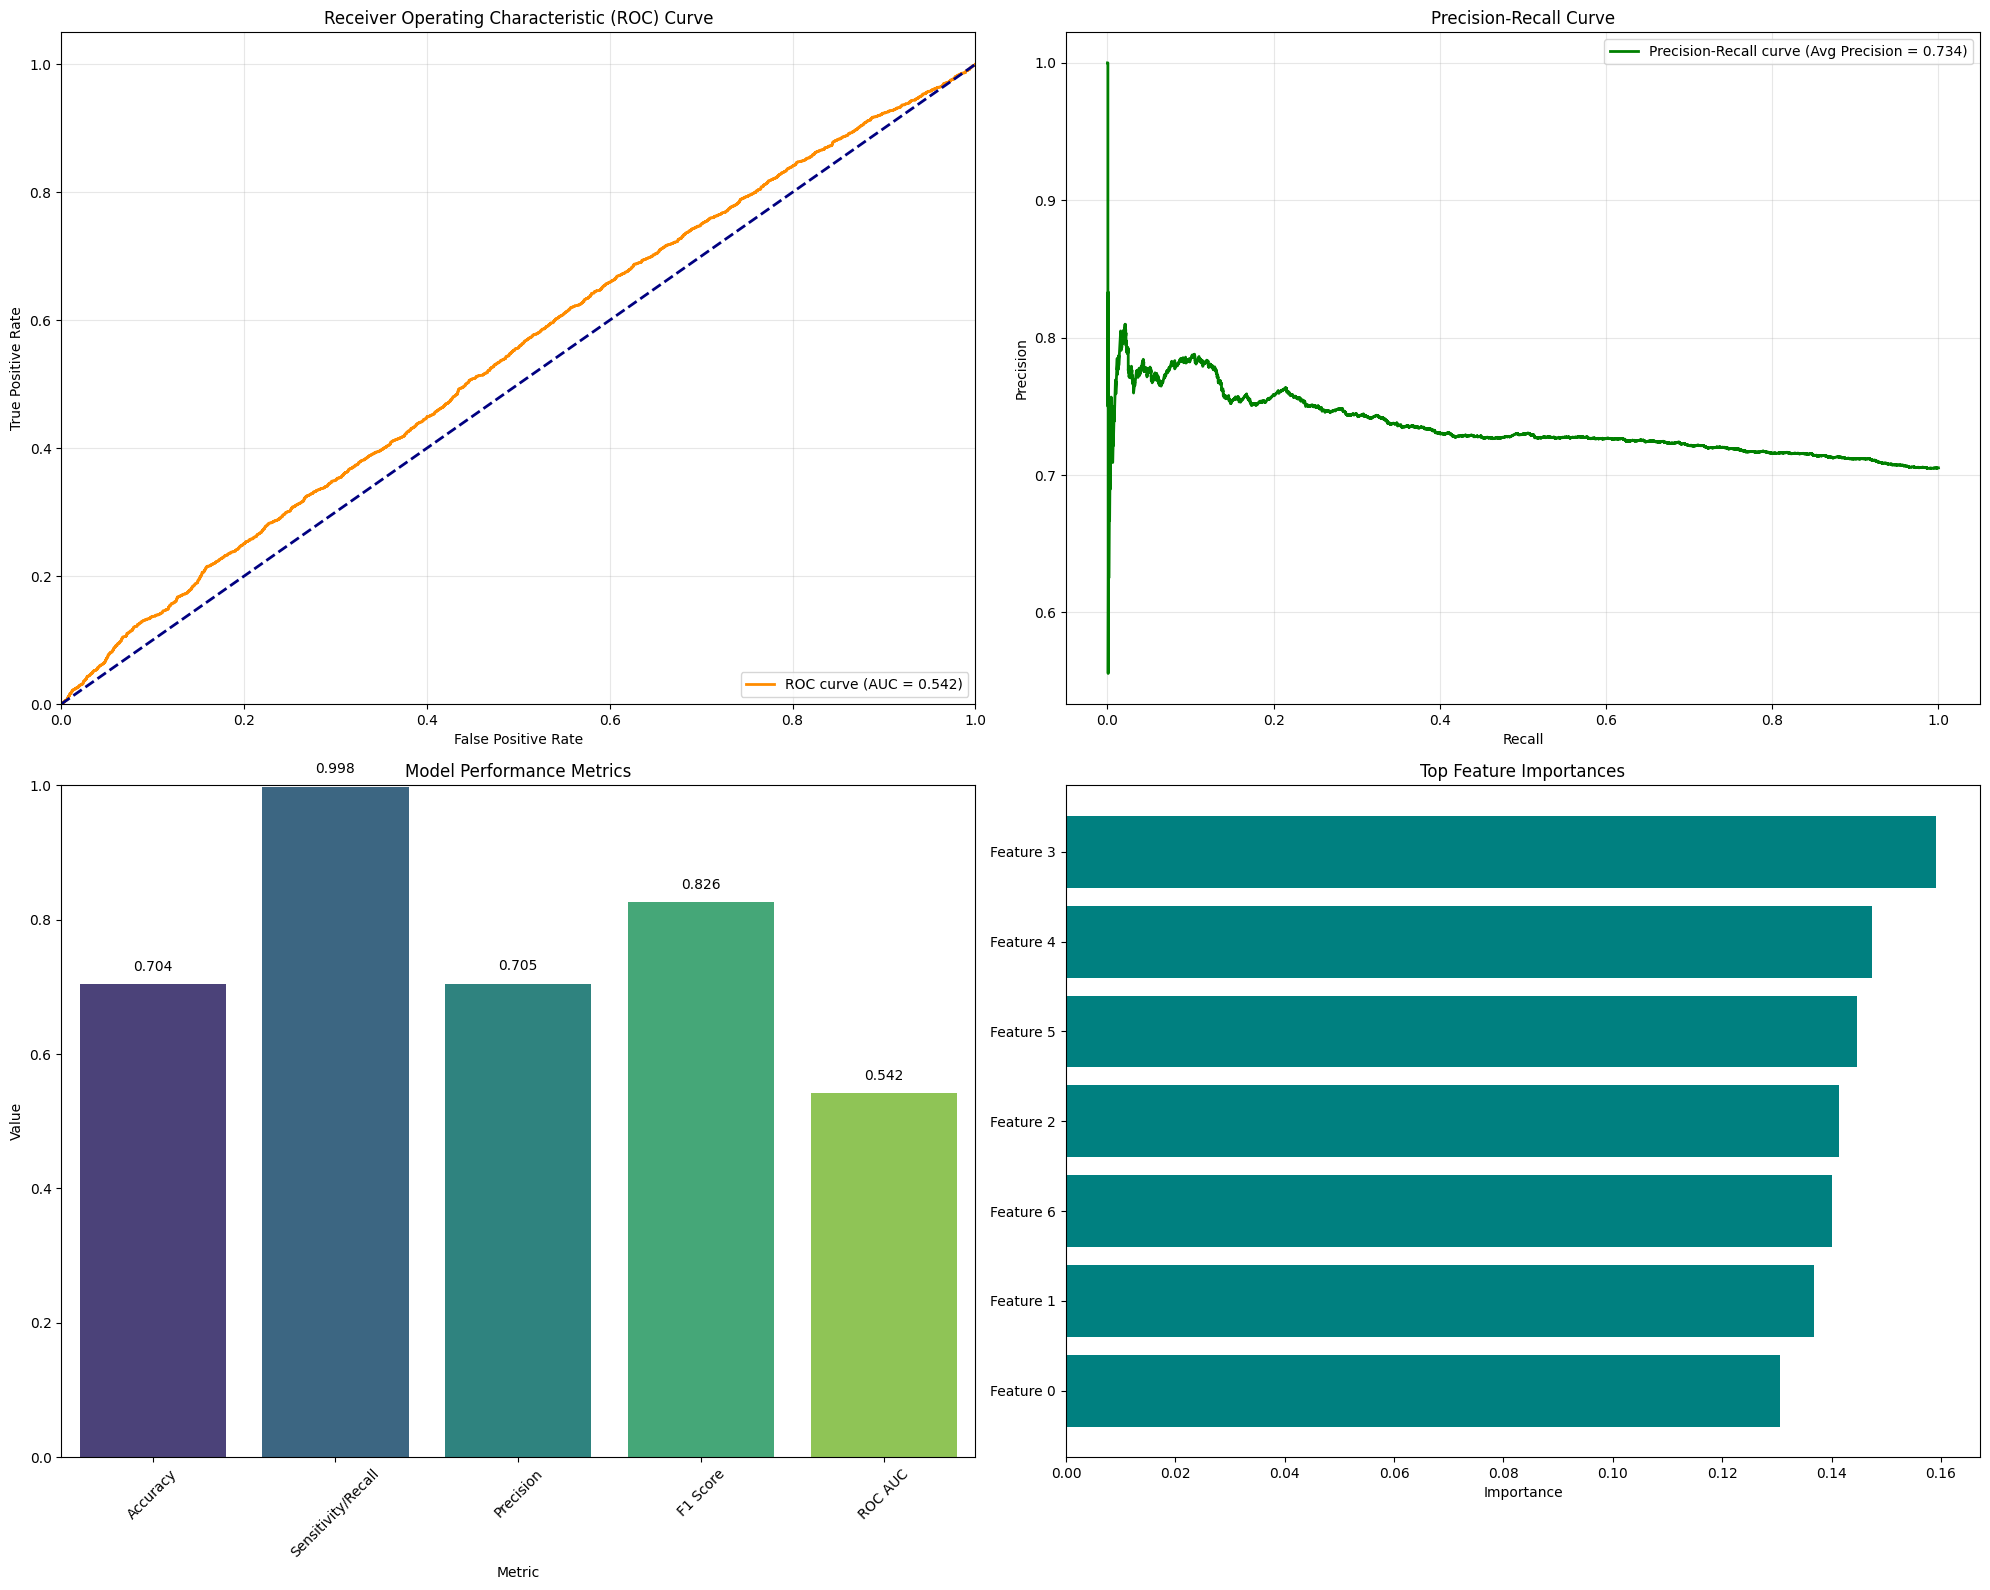


Model Performance Summary:
Accuracy: 0.7043
Sensitivity/Recall: 0.9981
Precision: 0.7051
F1 Score: 0.8264
ROC AUC: 0.5419


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_recall_curve
import joblib

best_rf = joblib.load("/content/drive/MyDrive/bestRandomForestModel.joblib")

# Generate predictions if you haven't already
# Assuming X_test and y_test are available from your previous script
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]  # Probability for positive class

# Set up the figure size for all plots
plt.figure(figsize=(20, 16))

# 1. ROC Curve Plot
plt.subplot(2, 2, 1)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 2. Precision-Recall Curve
plt.subplot(2, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = np.mean(precision)

plt.plot(recall, precision, color='green', lw=2,
         label=f'Precision-Recall curve (Avg Precision = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)

# 3. Model Performance Metrics
plt.subplot(2, 2, 3)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate / Recall
precision = tp / (tp + fp) if (tp + fp) > 0 else 0    # Positive Predictive Value
f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

metrics = {
    'Accuracy': accuracy,
    'Sensitivity/Recall': sensitivity,
    'Precision': precision,
    'F1 Score': f1,
    'ROC AUC': roc_auc
}

# Convert metrics to a format suitable for plotting
metrics_df = pd.Series(metrics).reset_index()
metrics_df.columns = ['Metric', 'Value']

# Create a bar chart for metrics
colors = sns.color_palette("viridis", len(metrics))
ax = sns.barplot(x='Metric', y='Value', data=metrics_df, palette=colors)
plt.ylim(0, 1.0)
plt.title('Model Performance Metrics')
plt.xticks(rotation=45)
plt.tight_layout()

# Add value labels on the bars
for i, v in enumerate(metrics_df['Value']):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center')

# 4. Feature Importance Plot
if hasattr(best_rf, 'feature_importances_'):
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot top 15 features or all if fewer than 15
    num_features = min(15, len(feature_names))
    plt.subplot(2, 2, 4)
    plt.title('Top Feature Importances')
    plt.barh(range(num_features), importances[indices[:num_features]], align='center', color='teal')
    plt.yticks(range(num_features), [feature_names[i] for i in indices[:num_features]])
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()  # To have the most important feature on top
    plt.tight_layout()

# Show all plots
plt.tight_layout()
plt.show()

# Print a summary of results
print("\nModel Performance Summary:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Optionally save the figure
plt.savefig("/content/drive/MyDrive/random_forest_evaluation.png", dpi=300, bbox_inches='tight')


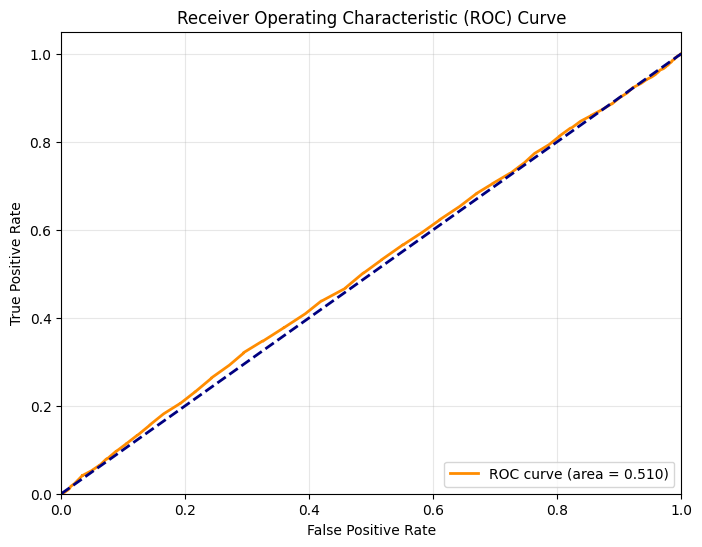

ROC AUC: 0.5104


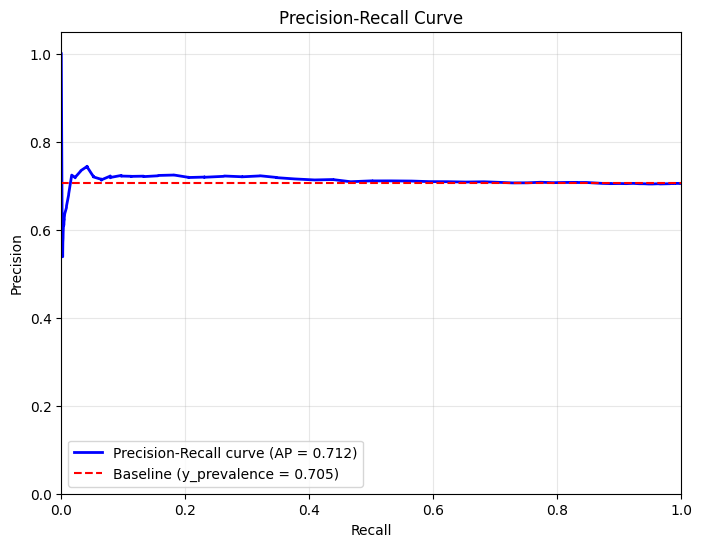

Average Precision: 0.7122


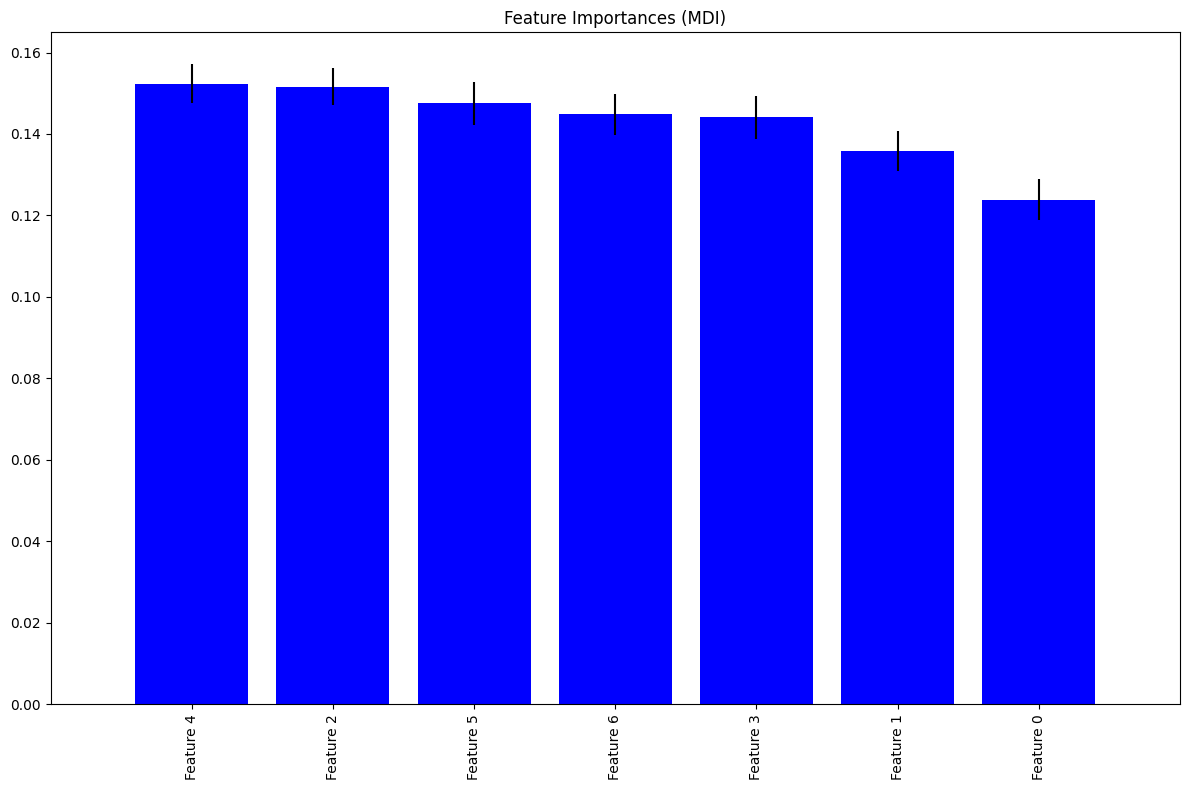

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

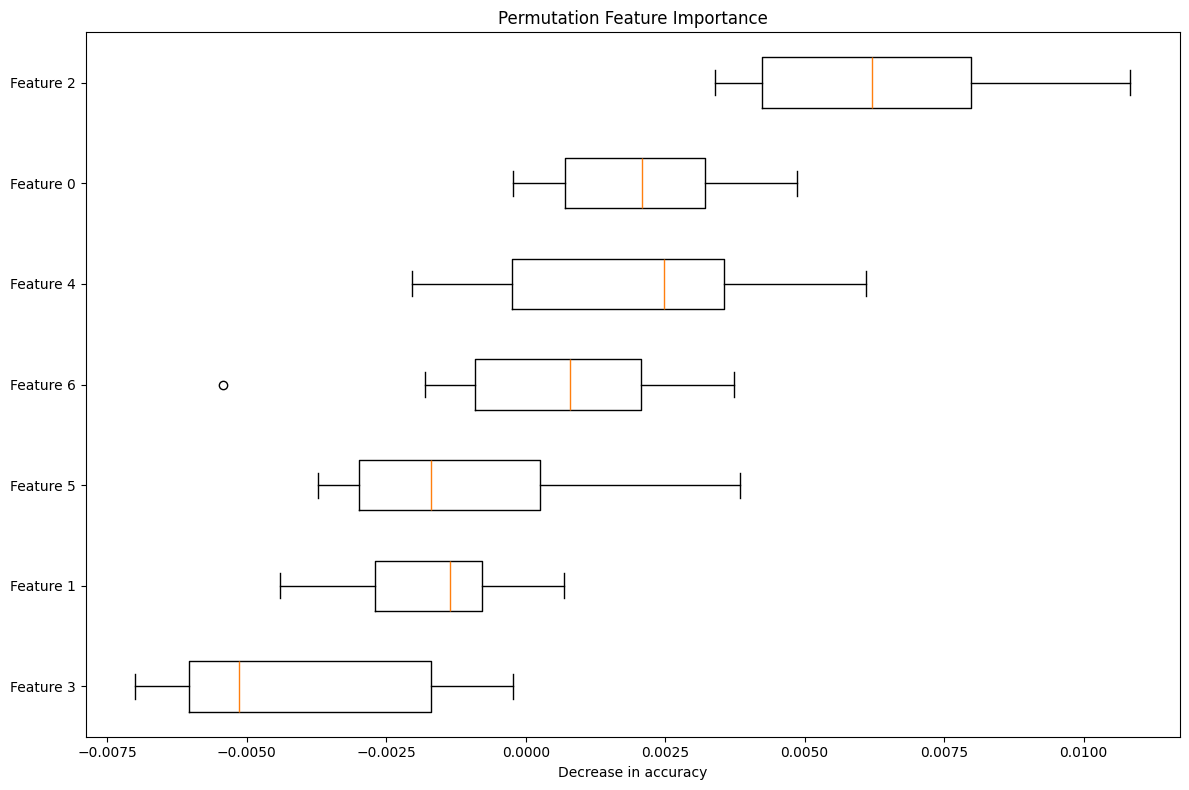

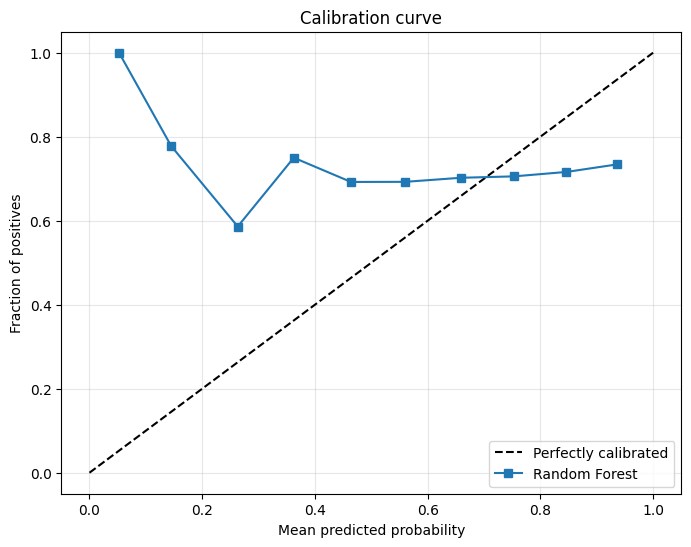

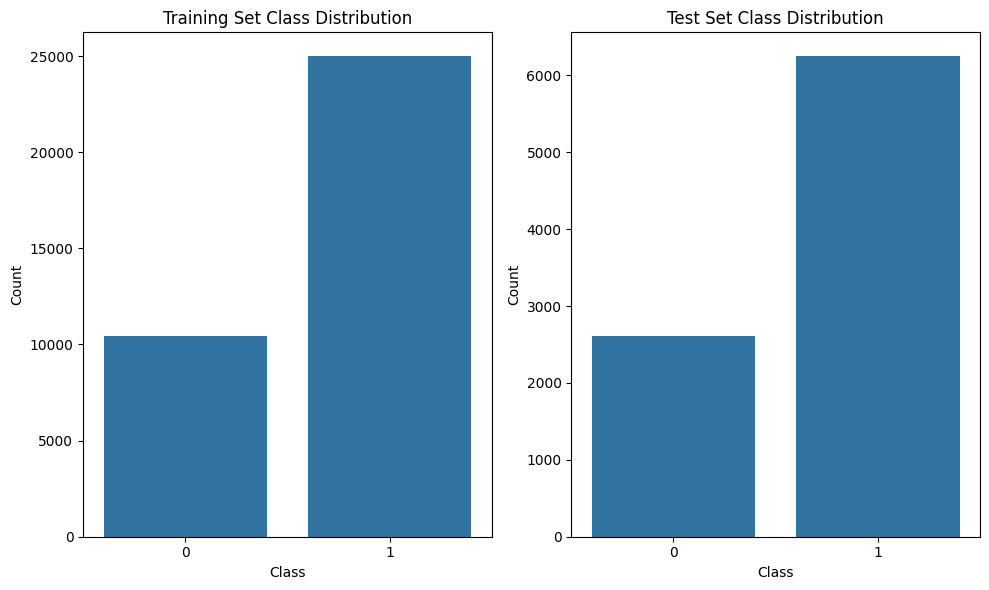

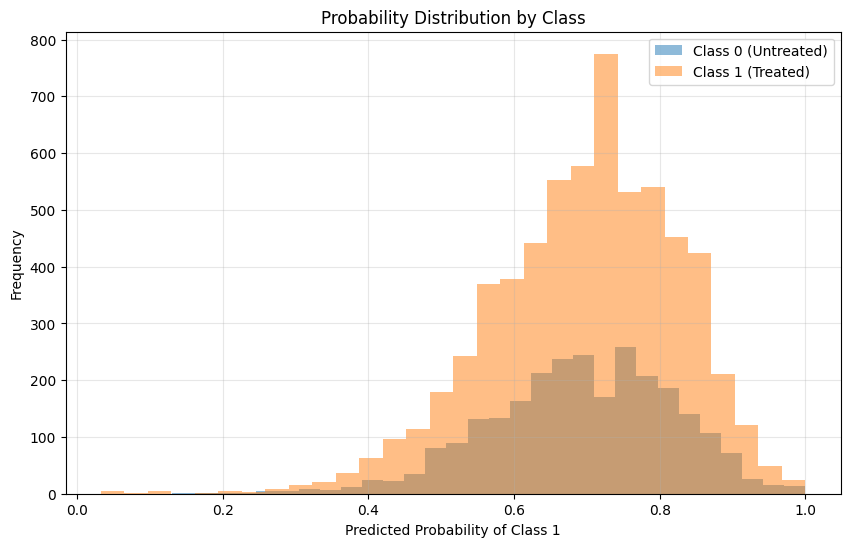

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
from sklearn.inspection import permutation_importance

# Assuming you have your model and test data already defined:
# clf, X_test, y_test, y_pred, y_proba

# 1. ROC Curve
def plot_roc_curve(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()
    return roc_auc

# 2. Precision-Recall Curve
def plot_precision_recall_curve(y_test, y_proba):
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
    plt.axhline(y=sum(y_test)/len(y_test), color='red', linestyle='--', label=f'Baseline (y_prevalence = {sum(y_test)/len(y_test):.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)
    plt.show()
    return avg_precision

# 3. Feature Importance Plot
def plot_feature_importance(clf, X_train):
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

    # Get feature importances
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12, 8))
        plt.title('Feature Importances (MDI)')
        plt.bar(range(X_train.shape[1]), importances[indices], color='b', yerr=std[indices], align='center')
        plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
        plt.xlim([-1, X_train.shape[1]])
        plt.tight_layout()
        plt.show()
    else:
        print("This model doesn't expose feature_importances_ attribute")

# 4. Permutation Feature Importance Plot (more reliable than MDI)
def plot_permutation_importance(clf, X_test, y_test):
    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature {i}' for i in range(X_test.shape[1])]

    # Calculate permutation importance
    result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = result.importances_mean.argsort()

    plt.figure(figsize=(12, 8))
    plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=[feature_names[i] for i in sorted_idx])
    plt.title("Permutation Feature Importance")
    plt.xlabel("Decrease in accuracy")
    plt.tight_layout()
    plt.show()

# 5. Learning Curve (requires partial_fit or retraining with different subset sizes)
def plot_learning_curve(clf, X, y, cv=5):
    from sklearn.model_selection import learning_curve

    train_sizes, train_scores, test_scores = learning_curve(
        clf, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.grid(True, alpha=0.3)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.show()

# 6. Calibration Plot
def plot_calibration_curve(clf, X_test, y_test):
    from sklearn.calibration import calibration_curve

    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    plt.plot(prob_pred, prob_true, 's-', label='Random Forest')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 7. Class Distribution Histogram
def plot_class_distribution(y_train, y_test):
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train)
    plt.title('Training Set Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    sns.countplot(x=y_test)
    plt.title('Test Set Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# 8. Probability Distribution Plot
def plot_probability_distribution(y_test, y_proba):
    plt.figure(figsize=(10, 6))

    plt.hist(y_proba[y_test == 0], bins=30, alpha=0.5, label='Class 0 (Untreated)')
    plt.hist(y_proba[y_test == 1], bins=30, alpha=0.5, label='Class 1 (Treated)')

    plt.xlabel('Predicted Probability of Class 1')
    plt.ylabel('Frequency')
    plt.title('Probability Distribution by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Execute these functions to see the plots:
# Note: Uncomment these lines to run the visualizations

# Plot ROC curve
roc_auc = plot_roc_curve(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# Plot precision-recall curve
avg_precision = plot_precision_recall_curve(y_test, y_proba)
print(f"Average Precision: {avg_precision:.4f}")

# Plot feature importance
plot_feature_importance(clf, X_train)

# Plot permutation importance
plot_permutation_importance(clf, X_test, y_test)

# Plot learning curve - this may take some time
# plot_learning_curve(clf, X, y)

# Plot calibration curve
plot_calibration_curve(clf, X_test, y_test)

# Plot class distribution
plot_class_distribution(y_train, y_test)

# Plot probability distribution
plot_probability_distribution(y_test, y_proba)

In [ ]:
import numpy as np
import cv2
import tifffile
from skimage.measure import label, regionprops

# Assume predict_mask, unet_model, and target_size are defined as before.
# Also, assume clf is your trained Random Forest classifier.

def detect_resistant_cells(image_path, unet_model, clf, target_size=(256,256)):
    # Step 1: Predict segmentation mask for the image.
    mask = predict_mask(image_path, unet_model, target_size)

    # Step 2: Load and convert the image to grayscale (for intensity measurements).
    image = tifffile.imread(image_path)
    if image.ndim == 3:
        image_gray = np.mean(image, axis=2)  # Convert RGB to grayscale by averaging channels.
    else:
        image_gray = image
    image_gray = cv2.resize(image_gray, target_size, interpolation=cv2.INTER_LINEAR)

    # Step 3: Label connected regions (cells) in the binary mask.
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask, intensity_image=image_gray)

    # Prepare a list to hold features for each cell.
    features_list = []
    cell_indices = []
    for i, region in enumerate(regions):
        # Only consider regions that are reasonably sized, if desired.
        if region.area < 10:
            continue
        cell_features = [
            region.area,
            region.perimeter,
            region.eccentricity,
            region.solidity,
            region.major_axis_length / (region.minor_axis_length + 1e-5),
            region.mean_intensity,
            np.std(region.intensity_image)
        ]
        features_list.append(cell_features)
        cell_indices.append(i)

    # If no cells were detected, return an empty result.
    if not features_list:
        return None, None

    # Convert to a NumPy array for prediction.
    X_cell_features = np.array(features_list)

    # Step 4: Predict resistance for each cell.
    predictions = clf.predict(X_cell_features)

    # Optionally, you can also get prediction probabilities:
    probabilities = clf.predict_proba(X_cell_features)[:, 1]

    # Return a mapping from cell index to predicted label and probability.
    results = {
        "cell_index": cell_indices,
        "prediction": predictions,
        "probability": probabilities
    }

    return results, X_cell_features

# Example usage:
image_path = "/content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/Clinical_Isolates_Titrations/220323_1_EC3_[0001]_AMR_combined_1_CIP+ETOH_posXY0.tif"
results, features = detect_resistant_cells(image_path, unet_model, clf)

if results is None:
    print("No cells detected in the image.")
else:
    for idx, pred, prob in zip(results["cell_index"], results["prediction"], results["probability"]):
        print(f"Cell {idx}: Prediction={pred} (0: Susceptible, 1: Resistant), Probability={prob:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Cell 0: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.68
Cell 1: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.53
Cell 2: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.76
Cell 3: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.58
Cell 4: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.72
Cell 5: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.80
Cell 6: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.68
Cell 7: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.78
Cell 8: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.66
Cell 9: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.86
Cell 10: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.81
Cell 11: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.69
Cell 12: Prediction=1 (0: Susceptible, 1: Resistant), Probability=0.75
Cell 13: Prediction=1 (0: Susceptible, 1: Resist

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


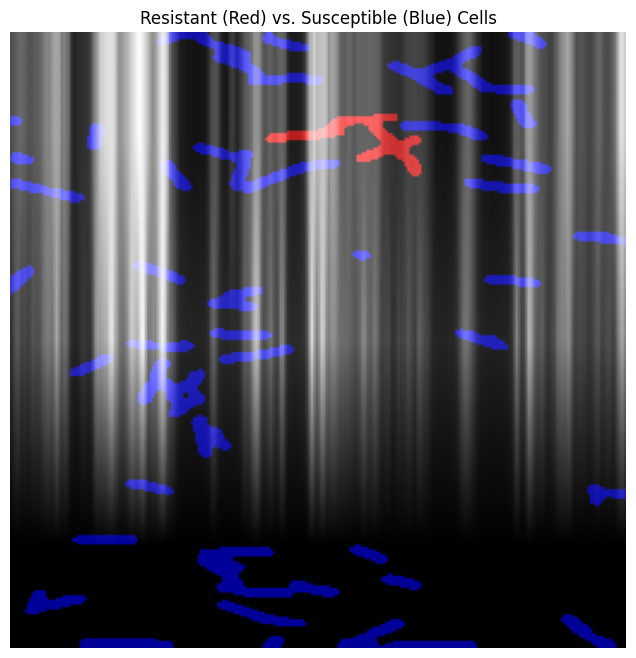

In [ ]:
import cv2
import numpy as np
import tifffile
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import tensorflow as tf  # if not already imported

def visualize_predictions(image_path, unet_model, clf, target_size=(256,256), threshold=0.5):
    """
    Visualizes cell classification results. Resistant cells are red, susceptible cells are blue.

    Args:
        image_path (str): Path to the input image.
        unet_model (tf.keras.Model): Trained U-Net segmentation model.
        clf: Trained classifier (e.g., RandomForest) that takes morphological features.
        target_size (tuple): Target size (width, height) for both image and mask.
        threshold (float): Threshold for converting the predicted mask into binary.

    Returns:
        None. Displays the visualization using matplotlib.
    """
    # --- Step 1: Predict the segmentation mask ---
    mask = predict_mask(image_path, unet_model, target_size)  # Ensure this is binary

    # --- Step 2: Load and preprocess original image ---
    orig_image = tifffile.imread(image_path)

    if orig_image.ndim == 3:
        # Convert to grayscale by averaging channels
        image_gray = np.mean(orig_image, axis=2)
    else:
        image_gray = orig_image

    # Normalize grayscale intensity values for better visualization
    image_gray = (image_gray - np.min(image_gray)) / (np.max(image_gray) - np.min(image_gray)) * 255
    image_gray = cv2.resize(image_gray.astype(np.uint8), target_size, interpolation=cv2.INTER_LINEAR)

    # --- Step 3: Label connected regions and extract features ---
    labeled_mask = label(mask)  # Identify separate bacteria regions
    regions = regionprops(labeled_mask, intensity_image=image_gray)

    features_list = []
    region_coords = []  # Store coordinates of each detected region

    for region in regions:
        if region.area < 10:
            continue  # Ignore very small detections

        # Extract morphological features
        cell_features = [
            region.area,
            region.perimeter,
            region.eccentricity,
            region.solidity,
            region.major_axis_length / (region.minor_axis_length + 1e-5),
            region.mean_intensity,
            np.std(region.intensity_image)
        ]
        features_list.append(cell_features)
        region_coords.append(region.coords)  # Store cell coordinates

    if not features_list:
        print("No cells detected in the image.")
        return

    # --- Step 4: Classify each detected cell ---
    X_features = np.array(features_list)
    predictions = clf.predict(X_features)  # 0 = susceptible (blue), 1 = resistant (red)

    # --- Step 5: Prepare overlay ---
    overlay = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

    # Assign colors based on classification
    for coords, pred in zip(region_coords, predictions):
        color = [0, 0, 255] if pred == 0 else [255, 0, 0]  # Blue for susceptible, red for resistant

        for (row, col) in coords:
            if 0 <= row < target_size[1] and 0 <= col < target_size[0]:  # Bounds check
                overlay[row, col, :] = color

    # --- Step 6: Blend overlay with the original image ---
    image_gray_3c = cv2.cvtColor(image_gray.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    blended = cv2.addWeighted(image_gray_3c, 1.0, overlay, 0.6, 0)  # Alpha blending

    # --- Step 7: Display the result ---
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))  # Convert to RGB for matplotlib
    plt.title("Resistant (Red) vs. Susceptible (Blue) Cells")
    plt.axis("off")
    plt.show()


# Example usage:
image_path = "/content/drive/MyDrive/bacteria_data/Zagajewski_Data/Data/Clinical_Isolates/All_images/WT+ETOH/211110_1_EC1_NA_AMR_combined_1_WT+ETOH_posXY0.tif"
visualize_predictions(test_image_path, unet_model, best_rf, target_size=(256,256))
